In [1]:
%matplotlib widget
import os, sys
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

In [2]:
sys.path.append(os.path.dirname(os.getcwd()))
from utils.nb import isnotebook
from utils.viz.viz import plot_fustrum, plot_crs, set_3d_axes_equal

## Findings:

### Solution #1: Triangulation + SVD

- At least two points are needed for each lidar point
- At least four points are needed to stable solution
- Uniformly weighs the lidar point, does not account for how many appearances are picked for a lidar point
- Direct approach, no need for initial guess

### Solution #2: Image point ray and lidar point distance minimization

- The minimum number of appearances or lidar points is less than for Solution #1.
- Not direct approach, need initial guess
- Need an optimizer which can be an issue for a javascript implementation, however a robust optimizer is provided below

### Solution with readjusting the model by defining the lidar points and appearances as tiepoints 


### Comparison on datasets
- Maysville Country Club (MCC) with RTK flight positions: Solution #1 beats #2 due to one point has just two appearances and it's located north east which is far from the rest of the points, which are located south west. So #1 overweighs that point which helps with estimating the orientation. Overall, none of the approaches provide usable result, errors are typically around a meter or more.

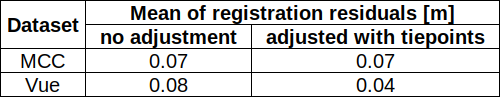


## Utility functions

In [3]:
def image2pixel(p, f, x_c, y_c, width, height):
    # output: coordinates in the image pixels crs which origin is upper left corner (cv standard axis directions)
    K = np.array([[f, 0, x_c + width/2.0], [0, -f, height/2.0 - y_c]])
    p_n = K.dot([p[0], p[1], 1])
    return True, p_n

def distort(p, f, x_c, y_c, k1, k2, k3, t1, t2):
    # p is the image point's normalized coordinates
    # f is the focal length
    # x_c, y_c are the principle point from the image center
    
    r2 = p[0] * p[0] + p[1] * p[1]    
    rp = 1 + k1*r2 + k2*r2*r2 + k3*r2*r2*r2

    rx = p[0] * rp
    ry = p[1] * rp

    tx = t2 * (r2 + 2 * p[0] * p[0]) - 2 * t1 * p[0] * p[1];
    ty = - t1 * (r2 + 2 * p[1] * p[1]) + 2 * t2 * p[0] * p[1];
    
    x = rx + tx;
    y = ry + ty;
    
    return True, np.array([x, y])


In [4]:
def pixel2image(p_d, f, x_c, y_c, width, height):
    K = np.array([[f, 0, x_c + width/2.0], [0, -f, height/2.0 - y_c], [0, 0, 1]])
    p_u = np.linalg.inv(K).dot([p_d[0], p_d[1], 1])
    return True, p_u[:2]

def undistort(p, distort_fn, epsilon=1e-10, max_iter_num=100, verbose=False):
    
    p_u = p.copy()
    
    result, p_d_i = distort_fn(p_u);
    if result == False:
        print('Distortion is unsuccessful!')
        return False, np.one((2, 1)) * np.nan
    delta_p = p_d_i - p_u
    
    epsilon = 1e-10
    iter_num = 0
    while np.max(np.abs(p_u - (p - delta_p))) > epsilon and iter_num < max_iter_num:
        p_u = p - delta_p
        result, p_d_i = distort_fn(p_u)
        if result == False:
            print('Distortion is unsuccessful!')
            return False, np.one((2, 1)) * np.nan
        delta_p = p_d_i - p_u
        iter_num += 1
        
        if verbose:
            num2str = lambda x: str(round(x, 10))
            print('#' + num2str(iter_num) + " x=" + num2str(p_u[0]) + 
                  " y=" + num2str(p_u[0]) + " delta=" + num2str(np.max(np.abs(p_u - (p - delta_p)))))
    
    if iter_num == max_iter_num:
        print('Did not converge! Delta:', np.max(np.abs(p_u - (p - delta_p))) )
        return False, p_u
    
    return True, p_u

In [5]:
def backproject(P_w, C, R, camera2pixel):
    P_c = R @ P_w - R @ C
    
    if P_c[2] == 0:
        print('Divider is zero!')
        return False, np.ones((1, 2)) * np.nan
    
    p_n = [-P_c[0]/P_c[2], -P_c[1]/P_c[2]]
    result, p_d = camera2pixel(p_n)

    if result == False:
        return False, p_d
        
    if (p_d[0] >= 0 and p_d[0] <= width and p_d[1] >= 0 and p_d[1] <= height and 
        f*p_n[0] > -width/2.0*1.25 and f*p_n[0] < width/2.0*1.25 and
        f*p_n[1] > -height/2.0*1.25 and f*p_n[1] < height/2.0*1.25):
        return True, p_d
    else:
        return False, p_d

In [6]:
def triangulate(backprojection_data, pixel2camera, views_rot, views_pos):

    if len(backprojection_data) < 2:
        print('Not enough observations!')
        return False, np.ones((1, 3)) * np.nan
    
    if backprojection_data.shape[1] < 3:
        print('Wrong backprojections array structure')
        return False, np.ones((1, 3)) * np.nan
    
    cam_indices = backprojection_data[:, 0].astype('int')
    img_pts = backprojection_data[:, 1:3]
    n_img_pts = img_pts.shape[0]

    A = np.zeros((n_img_pts*2, 3)) 
    b = np.zeros((n_img_pts*2, 1))
    for k in range(n_img_pts):
        cam_idx = cam_indices[k]
        R = views_rot[cam_idx]
        C = views_pos[cam_idx]
        img_pt = img_pts[k, :]
        
        result, p_c = pixel2camera(img_pt)
        x_i = f*p_c[0];
        y_i = f*p_c[1];
        z_i = -f

        #x_i = img_pt[0] - x_c - width/2.0;
        #y_i = -img_pt[1] - y_c + height/2.0;
        #z_i = -f

        p_i = np.array([x_i, y_i, z_i]).T
        p_i_w = R.T @ p_i

        x_n_w = p_i_w[0] / p_i_w[2]
        y_n_w = p_i_w[1] / p_i_w[2]

        A[k*2, :] = [-1, 0, x_n_w]
        b[k*2] = -C[0] + x_n_w*C[2];

        A[k*2+1, :] = [0, -1, y_n_w]
        b[k*2 + 1] = -C[1] + y_n_w*C[2];

    #P_hat = np.linalg.inv((A.T @ A)) @ A.T @ b
    P_hat = np.linalg.solve(A.T @ A, A.T @ b)
              
    return True, P_hat.T.squeeze(0)

## Problem definition

In [7]:
# Results from seven param
#bundle_mean_offset = np.array([540702.214,126931.369,369.762])
#bundle_data_str = '{"camera":{"focal_length":7471.27,"xo":19.499321327528516,"yo":-6.644968239965986,"pixel_width":7952,"pixel_height":5304,"k1":-0.009478270302244397,"k2":0.04629766820693931,"k3":-0.07699880304345112,"t1":0.00043476760052012665,"t2":0.00023383541355524783},"images":[{"name":"MCC_Flight_01_00002.JPG","position":{"x":82.35928286979,"y":-1.2556541964700036,"z":0.04799140128000081},"rotation":[[0.81146041,-0.57676876,-0.09417958],[0.57067828,0.81676599,-0.08496834],[0.12592976,0.01520221,0.99192267]],"reconstructed":true},{"name":"MCC_Flight_01_00003.JPG","position":{"x":93.12255396163,"y":22.443399079989998,"z":-0.97887273091},"rotation":[[0.77233411,-0.63420716,-0.03579525],[0.62925589,0.77157274,-0.09334093],[0.08681612,0.04956601,0.99499054]],"reconstructed":true},{"name":"MCC_Flight_01_00004.JPG","position":{"x":104.61753521614001,"y":45.666866466170006,"z":-1.6250601033700003},"rotation":[[0.82809178,-0.56037706,0.01554218],[0.56045358,0.82695099,-0.04520893],[0.01248143,0.04614781,0.99885664]],"reconstructed":true},{"name":"MCC_Flight_01_00005.JPG","position":{"x":115.70976815082001,"y":68.92001982130999,"z":-0.603760015349999},"rotation":[[0.79842229,-0.60206282,-0.00649641],[0.59808628,0.79429993,-0.10667909],[0.06938761,0.08128955,0.99427228]],"reconstructed":true},{"name":"MCC_Flight_01_00006.JPG","position":{"x":128.21136057617,"y":91.64647133678001,"z":-1.178327668049997},"rotation":[[0.70597676,-0.64525422,-0.29196542],[0.65153197,0.75332718,-0.08946645],[0.27767409,-0.12706357,0.95223524]],"reconstructed":true},{"name":"MCC_Flight_01_00007.JPG","position":{"x":95.62413725647001,"y":112.64874240729,"z":-4.161914070129999},"rotation":[[-0.97297229,0.18112469,-0.14324372],[-0.18589985,-0.98235329,0.02057312],[-0.13698964,0.04664606,0.98947359]],"reconstructed":true},{"name":"MCC_Flight_01_00008.JPG","position":{"x":83.11172268514,"y":88.55496592428,"z":-3.2256694674400004},"rotation":[[-0.96496574,0.25801613,0.04763179],[-0.25766626,-0.96614035,0.01345077],[0.04948951,0.00070642,0.99877439]],"reconstructed":true},{"name":"MCC_Flight_01_00009.JPG","position":{"x":71.75191918042,"y":65.23237656462,"z":-2.1187321533200003},"rotation":[[-0.98814891,0.15018319,0.03172906],[-0.15066549,-0.98849417,-0.01338614],[0.02935361,-0.01800797,0.99940686]],"reconstructed":true},{"name":"MCC_Flight_01_00010.JPG","position":{"x":61.26550996637,"y":41.79077550519,"z":-2.11152043601},"rotation":[[-0.992939,0.11146488,-0.04059208],[-0.11101198,-0.9937307,-0.01325245],[-0.04181477,-0.00865267,0.99908791]],"reconstructed":true},{"name":"MCC_Flight_01_00011.JPG","position":{"x":50.31861021579001,"y":18.350054653960004,"z":-2.3090450428200002},"rotation":[[-0.98326587,0.18157097,0.01483965],[-0.18165315,-0.98335291,-0.00438],[0.01379733,-0.00700238,0.99988029]],"reconstructed":true},{"name":"MCC_Flight_01_00012.JPG","position":{"x":39.40508526744,"y":-4.92087957888,"z":-2.28648902663},"rotation":[[-0.98798436,0.15417549,0.01080818],[-0.15433886,-0.98788193,-0.01639552],[0.00814942,-0.01786664,0.99980717]],"reconstructed":true},{"name":"MCC_Flight_01_00013.JPG","position":{"x":28.917448434870003,"y":-28.00198831267,"z":-1.67027076552},"rotation":[[-0.98664305,0.16162299,-0.02033483],[-0.16106783,-0.98658761,-0.0264961],[-0.02434447,-0.02286691,0.99944207]],"reconstructed":true},{"name":"MCC_Flight_01_00014.JPG","position":{"x":18.10250853016,"y":-51.489683263159996,"z":-1.1083055364199998},"rotation":[[-0.98562945,0.16489283,-0.03667337],[-0.16227466,-0.98456422,-0.06557612],[-0.04692032,-0.0586826,0.99717342]],"reconstructed":true},{"name":"MCC_Flight_01_00015.JPG","position":{"x":7.044001513579998,"y":-75.46038759319,"z":-0.7910420265299996},"rotation":[[-0.97013745,0.24254539,0.00225127],[-0.2418597,-0.96660876,-0.0846841],[-0.01836364,-0.08269971,0.99640531]],"reconstructed":true},{"name":"MCC_Flight_01_00016.JPG","position":{"x":-3.161367966759999,"y":-98.16694163632,"z":-1.047512299520001},"rotation":[[-0.97518899,0.2207943,-0.01600983],[-0.21938871,-0.97357662,-0.06338108],[-0.02958098,-0.05829616,0.99786097]],"reconstructed":true},{"name":"MCC_Flight_01_00017.JPG","position":{"x":-13.680380669489999,"y":-121.60292506934,"z":-1.8376736000900002},"rotation":[[-0.95164533,0.1859537,0.24452483],[-0.20343071,-0.97790988,-0.0480439],[0.23018931,-0.09546461,0.96845206]],"reconstructed":true},{"name":"MCC_Flight_01_00018.JPG","position":{"x":-19.76766954484,"y":-146.09661388199999,"z":-1.808656646549999},"rotation":[[-0.96774409,-0.10514983,0.22894298],[0.09280517,-0.99362104,-0.06406585],[0.23421908,-0.04075226,0.97132933]],"reconstructed":true},{"name":"MCC_Flight_01_00019.JPG","position":{"x":-60.14016739468001,"y":-129.04674883909001,"z":-3.1687698907399997},"rotation":[[0.84717226,-0.53068078,-0.02602057],[0.53045558,0.84757149,-0.0154739],[0.03026599,-0.0006937,0.99954164]],"reconstructed":true},{"name":"MCC_Flight_01_00020.JPG","position":{"x":-49.736570234910005,"y":-104.89088013374,"z":-2.761282659330001},"rotation":[[0.84542106,-0.53359383,-0.0232564],[0.53060448,0.84406466,-0.07754825],[0.06100917,0.05322097,0.99671732]],"reconstructed":true},{"name":"MCC_Flight_01_00021.JPG","position":{"x":-38.908213667800005,"y":-81.43625905133,"z":-2.5203271780200005},"rotation":[[0.8442514,-0.53579632,-0.01272295],[0.5330382,0.84190221,-0.08408887],[0.05576598,0.06421032,0.99637703]],"reconstructed":true},{"name":"MCC_Flight_01_00022.JPG","position":{"x":-28.139944134470003,"y":-58.621910630710005,"z":-4.00023137549},"rotation":[[0.78621803,-0.61791256,-0.00672865],[0.61662436,0.78519855,-0.05690025],[0.04044271,0.04058695,0.99835719]],"reconstructed":true},{"name":"MCC_Flight_01_00023.JPG","position":{"x":-17.116907261839998,"y":-35.5339959528,"z":-4.15937099287},"rotation":[[0.75716984,-0.65318285,-0.00678212],[0.65226313,0.7565834,-0.04619912],[0.03530771,0.03055686,0.99890923]],"reconstructed":true},{"name":"MCC_Flight_01_00024.JPG","position":{"x":-6.13455894869,"y":-12.317518911359999,"z":-3.22366808808},"rotation":[[0.77173619,-0.63351649,-0.05549882],[0.62836011,0.7730615,-0.08683022],[0.09791238,0.03213678,0.99467602]],"reconstructed":true},{"name":"MCC_Flight_01_00025.JPG","position":{"x":4.671635682690001,"y":11.0118296232,"z":-3.5716084394900003},"rotation":[[0.80931577,-0.58691602,0.02318541],[0.58694789,0.80659571,-0.06996816],[0.02236418,0.07023496,0.99727975]],"reconstructed":true},{"name":"MCC_Flight_01_00027.JPG","position":{"x":26.250723830640002,"y":57.949367483139994,"z":-5.6961660342},"rotation":[[0.79097984,-0.61184211,-0.00036331],[0.61176565,0.79087133,0.01628892],[-0.00967891,-0.01310647,0.99986726]],"reconstructed":true},{"name":"MCC_Flight_01_00028.JPG","position":{"x":36.59046139074,"y":81.71198875055,"z":-3.6204614655099996},"rotation":[[0.81964818,-0.56499592,-0.09463858],[0.56157756,0.82509063,-0.06209745],[0.11317021,-0.00224884,0.99357307]],"reconstructed":true},{"name":"MCC_Flight_01_00029.JPG","position":{"x":47.732835187730004,"y":104.71528108113,"z":-1.0625982732299992},"rotation":[[0.83553571,-0.54377853,0.0786447],[0.54943314,0.82645476,-0.12286477],[0.00181494,0.14586791,0.98930241]],"reconstructed":true},{"name":"MCC_Flight_01_00030.JPG","position":{"x":58.05423845682001,"y":128.09979489012,"z":-0.33234166097999956},"rotation":[[0.84313462,-0.50369388,-0.18819272],[0.47703803,0.86219713,-0.17044304],[0.24811034,0.05393134,0.96722938]],"reconstructed":true},{"name":"MCC_Flight_01_00031.JPG","position":{"x":73.81205143818,"y":148.43108441463,"z":-1.7613095092000006},"rotation":[[0.48994682,-0.87092278,0.0380214],[0.86912117,0.48461714,-0.09886663],[0.06767938,0.08148459,0.99437406]],"reconstructed":true},{"name":"MCC_Flight_01_00032.JPG","position":{"x":33.71100522276999,"y":162.29130884767997,"z":-0.27557475638000467},"rotation":[[-0.91442764,0.39851035,-0.0707926],[-0.38480167,-0.91019153,-0.15322876],[-0.12549807,-0.1128755,0.98565174]],"reconstructed":true},{"name":"MCC_Flight_01_00033.JPG","position":{"x":20.792106151920002,"y":139.80343628855,"z":0.08292356957000173},"rotation":[[-0.96833394,0.23055771,0.09577333],[-0.244152,-0.95465062,-0.17038779],[0.05214585,-0.18837553,0.98071172]],"reconstructed":true},{"name":"MCC_Flight_01_00034.JPG","position":{"x":9.98542457119,"y":115.78698611406,"z":0.21530175024000112},"rotation":[[-0.97833145,0.20405235,-0.03507447],[-0.19776487,-0.97112384,-0.1334449],[-0.0612914,-0.12361684,0.99043538]],"reconstructed":true},{"name":"MCC_Flight_01_00035.JPG","position":{"x":-0.5902691800900055,"y":92.26248659463,"z":0.3127222925699977},"rotation":[[-0.95594374,0.29299429,-0.0180531],[-0.28705537,-0.94588958,-0.15130141],[-0.06140669,-0.1394534,0.98832281]],"reconstructed":true},{"name":"MCC_Flight_01_00036.JPG","position":{"x":-11.638147093810003,"y":68.93972822484999,"z":-0.013600150680000188},"rotation":[[-0.99245868,0.12092224,-0.02008915],[-0.1182826,-0.98773201,-0.10195438],[-0.03217125,-0.09880931,0.99458621]],"reconstructed":true},{"name":"MCC_Flight_01_00037.JPG","position":{"x":-22.34653497239,"y":45.66889990758,"z":-0.66268300874},"rotation":[[-0.98547674,0.16005639,0.05672345],[-0.16666303,-0.97566928,-0.14245314],[0.0325428,-0.14983796,0.98817486]],"reconstructed":true},{"name":"MCC_Flight_01_00038.JPG","position":{"x":-32.81013874898,"y":21.782266128519996,"z":-2.22101869584},"rotation":[[-0.97509809,0.21911882,-0.03421473],[-0.21776232,-0.97520778,-0.03936188],[-0.0419914,-0.03093102,0.99863907]],"reconstructed":true},{"name":"MCC_Flight_01_00039.JPG","position":{"x":-43.53822496787999,"y":-1.5894559828100001,"z":-2.4054093520400004},"rotation":[[-0.97617853,0.21539647,0.02607355],[-0.21601095,-0.97610546,-0.02360933],[0.02036517,-0.02867909,0.99938119]],"reconstructed":true},{"name":"MCC_Flight_01_00040.JPG","position":{"x":-53.916672392699994,"y":-25.18909294514,"z":-1.014597333859999},"rotation":[[-0.97685412,0.15145382,-0.1510555],[-0.13843167,-0.98596314,-0.0933454],[-0.16307267,-0.07027398,0.98410816]],"reconstructed":true},{"name":"MCC_Flight_01_00041.JPG","position":{"x":-64.76839461377999,"y":-48.30428692779,"z":-1.0477234264099993},"rotation":[[-0.97897536,0.20382939,-0.00779894],[-0.20149134,-0.97228371,-0.11859861],[-0.03175666,-0.1145337,0.99291165]],"reconstructed":true},{"name":"MCC_Flight_01_00042.JPG","position":{"x":-75.66813160874001,"y":-71.59243443940001,"z":-1.8515199376600002},"rotation":[[-0.95284755,0.29670696,-0.06361237],[-0.28749935,-0.94977412,-0.12358499],[-0.09708591,-0.09946914,0.99029299]],"reconstructed":true},{"name":"MCC_Flight_01_00043.JPG","position":{"x":-87.09186540655,"y":-95.19713373465,"z":-3.1332040956699996},"rotation":[[-0.96144467,0.27294971,0.03350534],[-0.27471375,-0.95883661,-0.07186595],[0.01251035,-0.07829951,0.99685138]],"reconstructed":true},{"name":"MCC_Flight_01_00044.JPG","position":{"x":-96.024894215,"y":-119.05548145175001,"z":-2.1481782728599987},"rotation":[[-0.96091962,0.00411233,0.27679699],[-0.02838935,-0.99608173,-0.08375693],[0.27536799,-0.08834176,0.95727123]],"reconstructed":true},{"name":"MCC_Flight_01_00045.JPG","position":{"x":-100.27709690482,"y":-143.80235793981,"z":-1.921489684049998},"rotation":[[-0.99001498,-0.13769031,0.03019473],[0.13271828,-0.98265987,-0.12948141],[0.04749949,-0.12418114,0.99112201]],"reconstructed":true},{"name":"MCC_Flight_01_00046.JPG","position":{"x":-137.96524991956,"y":-118.62472987883,"z":-5.344320637020001},"rotation":[[0.78692129,-0.61635803,0.02928588],[0.6161882,0.78241995,-0.0901728],[0.03266487,0.08900451,0.99549546]],"reconstructed":true},{"name":"MCC_Flight_01_00047.JPG","position":{"x":-126.52651239014999,"y":-94.56778725398999,"z":-6.51435552789},"rotation":[[0.80168487,-0.59763897,-0.01135899],[0.59645085,0.80105289,-0.05060288],[0.03934141,0.03379249,0.99865426]],"reconstructed":true},{"name":"MCC_Flight_01_00049.JPG","position":{"x":-104.9072177317,"y":-47.66281310437001,"z":-4.70212894917},"rotation":[[0.766177,-0.64102299,-0.04541301],[0.6348236,0.76595913,-0.10151656],[0.09985895,0.04895041,0.99379678]],"reconstructed":true},{"name":"MCC_Flight_01_00050.JPG","position":{"x":-94.58161467375,"y":-24.3822444912,"z":-4.393112088869999},"rotation":[[0.83186022,-0.55498442,0.00092941],[0.55081729,0.82540698,-0.12370788],[0.06788881,0.1034196,0.99231824]],"reconstructed":true}]}'
#gcp_str = '[{"XYZ":[540825.86,127060.95,276.27],"appearances":[["MCC_Flight_01_00007.JPG",3672,4014],["MCC_Flight_01_00006.JPG",4516,610]]},{"XYZ":[540704.79,126897.92,270.62],"appearances":[["MCC_Flight_01_00015.JPG",4887,4302],["MCC_Flight_01_00014.JPG",5410,3107],["MCC_Flight_01_00012.JPG",5858,648],["MCC_Flight_01_00013.JPG",5696,1971],["MCC_Flight_01_00023.JPG",4729,1458],["MCC_Flight_01_00024.JPG",5473,2633],["MCC_Flight_01_00025.JPG",5108,4251],["MCC_Flight_01_00039.JPG",864,1306],["MCC_Flight_01_00040.JPG",2089,2041],["MCC_Flight_01_00041.JPG",640,3417],["MCC_Flight_01_00042.JPG",1165,4983]]},{"XYZ":[540684.4,126880.9,267.57],"appearances":[["MCC_Flight_01_00022.JPG",4103,1463],["MCC_Flight_01_00016.JPG",5570,4650],["MCC_Flight_01_00013.JPG",6653,859],["MCC_Flight_01_00014.JPG",6382,1976],["MCC_Flight_01_00015.JPG",5739,3111],["MCC_Flight_01_00023.JPG",4452,2958],["MCC_Flight_01_00024.JPG",5136,4054],["MCC_Flight_01_00039.JPG",1854,152],["MCC_Flight_01_00040.JPG",3040,962],["MCC_Flight_01_00041.JPG",1562,2268],["MCC_Flight_01_00042.JPG",1034.2571235428882,4353.277428469248]]},{"XYZ":[540653.43,126904.21,270.62],"appearances":[["MCC_Flight_01_00023.JPG",2245,3103],["MCC_Flight_01_00022.JPG",1867,1476],["MCC_Flight_01_00015.JPG",7720,3975],["MCC_Flight_01_00024.JPG",2992,4142],["MCC_Flight_01_00039.JPG",3832,1054],["MCC_Flight_01_00040.JPG",4878,1970],["MCC_Flight_01_00041.JPG",3467,3209],["MCC_Flight_01_00042.JPG",3825,4600],["MCC_Flight_01_00050.JPG",6305,259]]}]'

# Readjusted with lidar points as tiepoints
# bundle_mean_offset = np.array([540702.214,126931.369,369.762])
# bundle_data_str = '{"camera":{"focal_length":7475.84,"xo":16.898720410714827,"yo":-3.8143881804946758,"pixel_width":7952,"pixel_height":5304,"k1":-0.007766085705971658,"k2":0.03979231245570214,"k3":-0.05740629060190895,"t1":0.0002868898716742599,"t2":0.00007148316521926627},"images":[{"name":"MCC_Flight_01_00002.JPG","position":{"x":83.34562825747001,"y":-0.8823152326499977,"z":1.6453483799000013},"rotation":[[0.81480497,-0.57164445,-0.0965167],[0.56551537,0.82037412,-0.08472703],[0.12761355,0.01445433,0.99171864]],"reconstructed":true},{"name":"MCC_Flight_01_00003.JPG","position":{"x":94.07928516452999,"y":23.138884945189993,"z":0.612233399030002},"rotation":[[0.77615984,-0.6293834,-0.03811086],[0.62429166,0.77555349,-0.09368405],[0.08852019,0.0489215,0.99487228]],"reconstructed":true},{"name":"MCC_Flight_01_00004.JPG","position":{"x":105.57173717185,"y":46.71812621159,"z":-0.01841935005000003},"rotation":[[0.83162035,-0.55518841,0.01316916],[0.55515045,0.83046893,-0.04614467],[0.0146824,0.04568571,0.99884796]],"reconstructed":true},{"name":"MCC_Flight_01_00005.JPG","position":{"x":116.62398391733001,"y":70.23906340692999,"z":1.02975504632},"rotation":[[0.80219222,-0.59700065,-0.00882399],[0.59279349,0.7981299,-0.10763155],[0.0712988,0.08111038,0.99415169]],"reconstructed":true},{"name":"MCC_Flight_01_00006.JPG","position":{"x":129.10463945632,"y":93.39453137647997,"z":0.4752583023599989},"rotation":[[0.70959102,-0.64076775,-0.29308236],[0.64631925,0.75756737,-0.09145006],[0.28062788,-0.12453263,0.95170353]],"reconstructed":true},{"name":"MCC_Flight_01_00007.JPG","position":{"x":96.17471338622,"y":114.51365775158001,"z":-2.6640396225400016},"rotation":[[-0.97460563,0.1743285,-0.14054696],[-0.17936041,-0.98349384,0.02386862],[-0.13406609,0.04847105,0.98978626]],"reconstructed":true},{"name":"MCC_Flight_01_00008.JPG","position":{"x":83.52988402042,"y":89.99414701053,"z":-1.70237265349},"rotation":[[-0.96655907,0.25175695,0.0488057],[-0.25129251,-0.9677866,0.01553007],[0.05114331,0.00274622,0.99868755]],"reconstructed":true},{"name":"MCC_Flight_01_00009.JPG","position":{"x":72.2023859102,"y":66.34796304356999,"z":-0.5628759030799997},"rotation":[[-0.9890354,0.14395709,0.03294427],[-0.14441314,-0.98944596,-0.01189725],[0.03088388,-0.01652439,0.99938638]],"reconstructed":true},{"name":"MCC_Flight_01_00010.JPG","position":{"x":61.78110833922,"y":42.59625553426999,"z":-0.5442251294500002},"rotation":[[-0.99367132,0.10526225,-0.03920685],[-0.10486025,-0.9944124,-0.01217797],[-0.04026966,-0.00798966,0.9991569]],"reconstructed":true},{"name":"MCC_Flight_01_00011.JPG","position":{"x":50.8498170063,"y":18.836717191400002,"z":-0.7368728202500001},"rotation":[[-0.98434503,0.17553375,0.01589888],[-0.17561205,-0.98445265,-0.00365951],[0.01500933,-0.00639425,0.99986691]],"reconstructed":true},{"name":"MCC_Flight_01_00012.JPG","position":{"x":39.98709358079,"y":-4.76656694427,"z":-0.7263966323800001},"rotation":[[-0.98892051,0.14796871,0.01189509],[-0.14815033,-0.98883218,-0.01619848],[0.00936538,-0.01778127,0.99979804]],"reconstructed":true},{"name":"MCC_Flight_01_00013.JPG","position":{"x":29.548717347270003,"y":-28.19575355308,"z":-0.11825664471999991},"rotation":[[-0.98764951,0.15550182,-0.01917353],[-0.15496455,-0.98755376,-0.02689886],[-0.02311771,-0.02359543,0.99945426]],"reconstructed":true},{"name":"MCC_Flight_01_00014.JPG","position":{"x":18.688753139010007,"y":-51.97918309331,"z":0.3928271271600001},"rotation":[[-0.98668668,0.15856058,-0.03616539],[-0.15594617,-0.98553841,-0.06629356],[-0.04615393,-0.05977111,0.99714454]],"reconstructed":true},{"name":"MCC_Flight_01_00015.JPG","position":{"x":7.67525478704,"y":-76.14184281068,"z":0.7694809137199997},"rotation":[[-0.97151311,0.23697114,0.00263775],[-0.23633726,-0.96797147,-0.08471083],[-0.01752075,-0.08292108,0.99640209]],"reconstructed":true},{"name":"MCC_Flight_01_00016.JPG","position":{"x":-2.4244541470599987,"y":-99.11958127603,"z":0.5941302439499996},"rotation":[[-0.97648736,0.21502633,-0.01536629],[-0.21366838,-0.97484894,-0.0633669],[-0.02860536,-0.05859369,0.99787199]],"reconstructed":true},{"name":"MCC_Flight_01_00017.JPG","position":{"x":-13.04166068239,"y":-122.85931912857,"z":-0.08739963225999973},"rotation":[[-0.95283931,0.18059917,0.24388766],[-0.19797976,-0.97900407,-0.04852879],[0.23000276,-0.09452496,0.96858854]],"reconstructed":true},{"name":"MCC_Flight_01_00018.JPG","position":{"x":-19.0589664602,"y":-147.65851744859998,"z":0.08371606226000179},"rotation":[[-0.96743364,-0.11044841,0.22775711],[0.09816264,-0.9930703,-0.06461792],[0.23331577,-0.04015631,0.97157152]],"reconstructed":true},{"name":"MCC_Flight_01_00019.JPG","position":{"x":-59.98694900179001,"y":-130.76376385135,"z":-1.4042477328099996},"rotation":[[0.84998739,-0.52614,-0.02642224],[0.52599004,0.85039291,-0.01289917],[0.02925606,-0.0029337,0.99956764]],"reconstructed":true},{"name":"MCC_Flight_01_00020.JPG","position":{"x":-49.600238160809994,"y":-106.27925942211,"z":-1.09102674432},"rotation":[[0.84833285,-0.52893369,-0.02367544],[0.52606338,0.84710159,-0.07534066],[0.05990572,0.05145918,0.99687675]],"reconstructed":true},{"name":"MCC_Flight_01_00021.JPG","position":{"x":-38.7717375277,"y":-82.54217771257001,"z":-0.8870128960200019},"rotation":[[0.84725311,-0.53102062,-0.01338961],[0.52834086,0.84504886,-0.08214838],[0.05493736,0.06252619,0.99653016]],"reconstructed":true},{"name":"MCC_Flight_01_00022.JPG","position":{"x":-28.10460408443,"y":-59.493146749110004,"z":-2.38282657148},"rotation":[[0.78988683,-0.61320688,-0.00749106],[0.61198949,0.78898467,-0.0545165],[0.03934023,0.03847742,0.99848477]],"reconstructed":true},{"name":"MCC_Flight_01_00023.JPG","position":{"x":-17.07567358482,"y":-35.939597040609996,"z":-2.6113409501200002},"rotation":[[0.76122399,-0.64845098,-0.0070253],[0.64756466,0.76067254,-0.04513655],[0.03461279,0.02980969,0.99895612]],"reconstructed":true},{"name":"MCC_Flight_01_00024.JPG","position":{"x":-6.130789943020001,"y":-12.413628040219999,"z":-1.69648239985},"rotation":[[0.7754392,-0.6289789,-0.05549403],[0.62387822,0.77675482,-0.08618531],[0.097314,0.03220995,0.99473238]],"reconstructed":true},{"name":"MCC_Flight_01_00025.JPG","position":{"x":4.637190673019999,"y":11.102139184839999,"z":-2.0915143604199997},"rotation":[[0.81274677,-0.58217473,0.02269976],[0.58221046,0.81010737,-0.06897123],[0.02176407,0.06927218,0.99736036]],"reconstructed":true},{"name":"MCC_Flight_01_00027.JPG","position":{"x":26.285094055200002,"y":58.64808983156,"z":-4.23696380238},"rotation":[[0.79481342,-0.60685224,-0.00141119],[0.60679572,0.7947029,0.01569268],[-0.00840166,-0.01332906,0.99987587]],"reconstructed":true},{"name":"MCC_Flight_01_00028.JPG","position":{"x":36.53976869891001,"y":82.74399846089001,"z":-2.115426309300001},"rotation":[[0.82312649,-0.55981485,-0.0952372],[0.55626233,0.82861695,-0.06297763],[0.11417097,-0.00113831,0.99346046]],"reconstructed":true},{"name":"MCC_Flight_01_00029.JPG","position":{"x":47.69616208651,"y":106.0258229593,"z":0.4761205522500015},"rotation":[[0.83917466,-0.53831508,0.07747751],[0.5438564,0.82996004,-0.12404253],[0.00247073,0.14622998,0.98924754]],"reconstructed":true},{"name":"MCC_Flight_01_00030.JPG","position":{"x":57.90333986331,"y":129.74753541824,"z":1.1509898171399964},"rotation":[[0.84627,-0.4982347,-0.1886512],[0.47106189,0.86519384,-0.17187298],[0.24885294,0.05658456,0.96688696]],"reconstructed":true},{"name":"MCC_Flight_01_00031.JPG","position":{"x":73.67657588066,"y":150.34796824807,"z":-0.19282253289000048},"rotation":[[0.4960057,-0.86747854,0.03820112],[0.86563264,0.49053417,-0.10028143],[0.06825304,0.0828083,0.99422548]],"reconstructed":true},{"name":"MCC_Flight_01_00032.JPG","position":{"x":33.154122841420005,"y":164.22380797003,"z":1.1702479749700005},"rotation":[[-0.91725754,0.39192195,-0.07096335],[-0.37870008,-0.91337327,-0.14945072],[-0.12338904,-0.11021097,0.98621939]],"reconstructed":true},{"name":"MCC_Flight_01_00033.JPG","position":{"x":20.180115664640002,"y":141.41691300476,"z":1.574428107740004},"rotation":[[-0.96986516,0.22422296,0.09531858],[-0.23765223,-0.95683577,-0.16729234],[0.05369345,-0.18490369,0.98128876]],"reconstructed":true},{"name":"MCC_Flight_01_00034.JPG","position":{"x":9.43548079019,"y":117.04807769867999,"z":1.6978215383899984},"rotation":[[-0.97966935,0.19748012,-0.03534925],[-0.19135072,-0.97272801,-0.13109205],[-0.06027328,-0.12166276,0.99073978]],"reconstructed":true},{"name":"MCC_Flight_01_00035.JPG","position":{"x":-1.115377456660003,"y":93.19711472,"z":1.7593636753299982},"rotation":[[-0.95781163,0.28678598,-0.01872659],[-0.28092499,-0.94800352,-0.1495676],[-0.06064676,-0.13799681,0.98857415]],"reconstructed":true},{"name":"MCC_Flight_01_00036.JPG","position":{"x":-12.14068101764,"y":69.60282483655999,"z":1.4122861627399987},"rotation":[[-0.99317691,0.11474467,-0.02081544],[-0.11211451,-0.98861541,-0.10034894],[-0.03209297,-0.09733054,0.99473454]],"reconstructed":true},{"name":"MCC_Flight_01_00037.JPG","position":{"x":-22.82086241135,"y":46.02671381532999,"z":0.7755274756199998},"rotation":[[-0.98648369,0.15409256,0.05572616],[-0.16056986,-0.97686285,-0.14126677],[0.03266865,-0.1483053,0.98840189]],"reconstructed":true},{"name":"MCC_Flight_01_00038.JPG","position":{"x":-33.2317014612,"y":21.81882053712,"z":-0.78743185908},"rotation":[[-0.97640683,0.21305694,-0.03516308],[-0.21170226,-0.97657116,-0.03861246],[-0.0425659,-0.03025737,0.99863539]],"reconstructed":true},{"name":"MCC_Flight_01_00039.JPG","position":{"x":-43.941776685099995,"y":-1.9020354936499984,"z":-0.9511695300300002},"rotation":[[-0.97753748,0.20928872,0.02487375],[-0.20986254,-0.97745443,-0.02324962],[0.01944707,-0.02794744,0.99942021]],"reconstructed":true},{"name":"MCC_Flight_01_00040.JPG","position":{"x":-54.293803443520005,"y":-25.782310448159997,"z":0.4996074739199989},"rotation":[[-0.97753067,0.14575015,-0.15228486],[-0.13257013,-0.98675971,-0.09343679],[-0.16388699,-0.07114891,0.98391]],"reconstructed":true},{"name":"MCC_Flight_01_00041.JPG","position":{"x":-65.27818778366,"y":-49.217480752,"z":0.4999195304600006},"rotation":[[-0.98005203,0.1984862,-0.01006181],[-0.1958947,-0.97331469,-0.11951479],[-0.03351535,-0.11515966,0.99278143]],"reconstructed":true},{"name":"MCC_Flight_01_00042.JPG","position":{"x":-76.10250420424,"y":-72.79492763096,"z":-0.344432132460001},"rotation":[[-0.95423956,0.29177298,-0.06553926],[-0.28227007,-0.95118669,-0.12476973],[-0.09874451,-0.10056044,0.99001875]],"reconstructed":true},{"name":"MCC_Flight_01_00043.JPG","position":{"x":-87.44081160535,"y":-96.60040578293001,"z":-1.53672000755},"rotation":[[-0.96296115,0.26776637,0.03173309],[-0.26941476,-0.96028098,-0.07263697],[0.01102294,-0.07849594,0.99685349]],"reconstructed":true},{"name":"MCC_Flight_01_00044.JPG","position":{"x":-96.39805144616999,"y":-120.73143497603999,"z":-0.4554417667900032},"rotation":[[-0.96169947,-0.00099297,0.27410426],[-0.02296408,-0.99618603,-0.08417868],[0.27314242,-0.08724914,0.95800877]],"reconstructed":true},{"name":"MCC_Flight_01_00045.JPG","position":{"x":-100.53268096759,"y":-145.75518033404,"z":-0.06739567997000234},"rotation":[[-0.98937033,-0.14275866,0.02768254],[0.13805281,-0.98190046,-0.12966457],[0.04569224,-0.12446462,0.99117142]],"reconstructed":true},{"name":"MCC_Flight_01_00046.JPG","position":{"x":-138.74918938304998,"y":-120.65275630824,"z":-3.67230610276},"rotation":[[0.78991356,-0.61248986,0.02987889],[0.61250268,0.7857016,-0.08668016],[0.02961483,0.08677074,0.99578803]],"reconstructed":true},{"name":"MCC_Flight_01_00047.JPG","position":{"x":-127.2938115934,"y":-96.22794421743998,"z":-4.94664163249},"rotation":[[0.80476376,-0.59350238,-0.01049854],[0.59244899,0.80418271,-0.04789938],[0.03687115,0.03232783,0.99879699]],"reconstructed":true},{"name":"MCC_Flight_01_00049.JPG","position":{"x":-105.74537813898,"y":-48.70518081913001,"z":-3.216289437490001},"rotation":[[0.76971216,-0.63686079,-0.04417608],[0.6309367,0.76944482,-0.09936573],[0.0972732,0.0486107,0.99406988]],"reconstructed":true},{"name":"MCC_Flight_01_00050.JPG","position":{"x":-95.45476815897,"y":-25.116680621690005,"z":-2.98944631855},"rotation":[[0.83511409,-0.55007129,0.00245649],[0.54620553,0.8286997,-0.12213238],[0.06514583,0.10333622,0.99251078]],"reconstructed":true}]}'
# gcp_str = '[{"XYZ":[540825.86,127060.95,276.27],"appearances":[["MCC_Flight_01_00006.JPG",4516,610],["MCC_Flight_01_00007.JPG",3672,4014]]},{"XYZ":[540704.79,126897.92,270.62],"appearances":[["MCC_Flight_01_00012.JPG",5858,648],["MCC_Flight_01_00013.JPG",5696,1971],["MCC_Flight_01_00014.JPG",5409,3108],["MCC_Flight_01_00015.JPG",4887,4302],["MCC_Flight_01_00023.JPG",4729,1458],["MCC_Flight_01_00024.JPG",5473,2633],["MCC_Flight_01_00025.JPG",5108,4251],["MCC_Flight_01_00039.JPG",864,1306],["MCC_Flight_01_00040.JPG",2089,2041],["MCC_Flight_01_00041.JPG",640,3417],["MCC_Flight_01_00042.JPG",1165,4983]]},{"XYZ":[540684.4,126880.9,267.57],"appearances":[["MCC_Flight_01_00013.JPG",6653,859],["MCC_Flight_01_00014.JPG",6382,1976],["MCC_Flight_01_00015.JPG",5739,3111],["MCC_Flight_01_00016.JPG",5570,4650],["MCC_Flight_01_00022.JPG",4103,1463],["MCC_Flight_01_00023.JPG",4453,2959],["MCC_Flight_01_00024.JPG",5136,4054],["MCC_Flight_01_00039.JPG",1854,152],["MCC_Flight_01_00040.JPG",3040,962],["MCC_Flight_01_00041.JPG",1562,2268],["MCC_Flight_01_00042.JPG",1079.2637086594968,4371.709779957391]]},{"XYZ":[540653.43,126904.21,270.62],"appearances":[["MCC_Flight_01_00015.JPG",7720,3975],["MCC_Flight_01_00022.JPG",1867,1476],["MCC_Flight_01_00023.JPG",2245,3103],["MCC_Flight_01_00024.JPG",2992,4142],["MCC_Flight_01_00039.JPG",3832,1054],["MCC_Flight_01_00040.JPG",4878,1970],["MCC_Flight_01_00041.JPG",3465,3206],["MCC_Flight_01_00042.JPG",3825,4600],["MCC_Flight_01_00050.JPG",6305,259]]}]'

# Vue: from seven param
#bundle_mean_offset = np.array([454235.211, 4436045.291, 115.731])
#bundle_data_str = '{"camera":{"focal_length":3165.16,"xo":-4.963128111346504,"yo":-4.627177364429638,"pixel_width":6000,"pixel_height":4000,"k1":-0.0018012894964021526,"k2":-0.0012472952261069292,"k3":0.0004546016021401165,"t1":0.000102209075394501,"t2":-0.0000987710746763226},"images":[{"name":"00000000000000003282767105112212_1343681199675926_1343681199681963.jpg","position":{"x":-122.94622500658,"y":18.6535631862,"z":-0.33256540402000195},"rotation":[[0.99664444,0.02794408,0.07693501],[-0.01682025,0.98977978,-0.14160885],[-0.08010584,0.1398396,0.98692854]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681204675451_1343681204681479.jpg","position":{"x":-110.81064220228998,"y":16.696855389250008,"z":-0.21260490854999992},"rotation":[[-0.23416081,0.96811172,0.08904168],[-0.97213273,-0.23422132,-0.0099165],[0.01125518,-0.08888239,0.99597853]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681209675717_1343681209681808.jpg","position":{"x":-85.95725651884,"y":20.24249713171,"z":1.0903865690399999},"rotation":[[-0.23335737,0.9717396,0.03558761],[-0.97195113,-0.23419628,0.02151985],[0.02924617,-0.02956761,0.99913483]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681214676406_1343681214682438.jpg","position":{"x":-61.18929507234,"y":24.01064620805001,"z":1.2914657501000002},"rotation":[[-0.23900959,0.96752621,0.08226454],[-0.97094952,-0.23913399,-0.00848304],[0.01146468,-0.08190224,0.99657442]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681219675037_1343681219681129.jpg","position":{"x":-36.37374597019,"y":27.542414554969998,"z":1.11941518223},"rotation":[[-0.26564178,0.9636985,0.02682612],[-0.96406834,-0.26546334,-0.01007259],[-0.00258559,-0.02853791,0.99958937]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681224675096_1343681224681130.jpg","position":{"x":-11.41835648279,"y":31.469424000140005,"z":1.7514350584500002},"rotation":[[-0.25537391,0.96538861,0.0529999],[-0.96631562,-0.25666026,0.01896404],[0.03191064,-0.04637171,0.99841443]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681229675521_1343681229681550.jpg","position":{"x":13.570439865209998,"y":35.31798562558,"z":1.9925691117100002},"rotation":[[-0.23585888,0.97117327,0.03454073],[-0.97170041,-0.23521342,-0.02174755],[-0.01299619,-0.03869259,0.99916664]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681234676803_1343681234682834.jpg","position":{"x":38.49211141899,"y":39.093394352349996,"z":2.26519013532},"rotation":[[-0.23770458,0.97092808,0.02819916],[-0.97127557,-0.23726143,-0.01818708],[-0.01096777,-0.03171231,0.99943686]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681239675668_1343681239681701.jpg","position":{"x":63.46946789986,"y":42.443814814540005,"z":2.51779078242},"rotation":[[-0.2271949,0.97384558,-0.00269386],[-0.97367734,-0.22720589,-0.01816378],[-0.01830078,-0.00150377,0.9998314]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681244716110_1343681244722145.jpg","position":{"x":86.14300380684,"y":46.21145073842,"z":2.736409668479997},"rotation":[[-0.19551431,0.9795698,0.0470868],[-0.95370462,-0.17872504,-0.24187779],[-0.22852059,-0.09219747,0.96916354]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681249675994_1343681249682030.jpg","position":{"x":92.78822081659,"y":32.129281180629995,"z":1.5215366335200011},"rotation":[[0.93656976,0.32172575,0.13903101],[-0.3318814,0.94161301,0.05674223],[-0.11265797,-0.09928487,0.98866106]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681259675412_1343681259681450.jpg","position":{"x":68.26199881583001,"y":16.47023324263,"z":-0.4378256554799995},"rotation":[[0.18760344,-0.97863531,0.08413015],[0.97326774,0.19675919,0.11847252],[-0.13249477,0.0596553,0.98938687]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681264675219_1343681264681252.jpg","position":{"x":43.59314389066001,"y":13.39279926999,"z":-0.8565576232699994},"rotation":[[0.20076708,-0.97960007,0.00873417],[0.9683481,0.19979497,0.1496126],[-0.14830556,-0.02157957,0.98870612]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681269675983_1343681269682015.jpg","position":{"x":18.957699477159995,"y":9.73892329951,"z":-0.96400302324},"rotation":[[0.20302364,-0.97914671,0.00728882],[0.971495,0.20235633,0.12348836],[-0.12238816,-0.01799,0.99231925]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681274675553_1343681274681582.jpg","position":{"x":-5.94306294111,"y":6.188884795970001,"z":-0.9187474016},"rotation":[[0.20129829,-0.9795262,-0.00272459],[0.97615172,0.20037245,0.08353861],[-0.08128233,-0.01947579,0.99650082]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681279641344_1343681279647382.jpg","position":{"x":-30.447749237260002,"y":2.5851486335200002,"z":-0.6161485387899999},"rotation":[[0.19126837,-0.98147089,0.01145897],[0.97046383,0.19084628,0.14757253],[-0.14702504,-0.01710544,0.98898485]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681284675511_1343681284681540.jpg","position":{"x":-55.4452347689,"y":-1.1113264137599996,"z":-0.8027225049700002},"rotation":[[0.20164166,-0.9794541,-0.00320909],[0.9738485,0.20013528,0.1075405],[-0.10468874,-0.02480981,0.99419553]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681289676188_1343681289682217.jpg","position":{"x":-80.26375137105,"y":-4.92223608045,"z":-0.5043543702500008},"rotation":[[0.20387639,-0.97895141,0.00941074],[0.97633869,0.20402133,0.07168019],[-0.07209141,-0.00542583,0.99738327]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681294676501_1343681294682529.jpg","position":{"x":-104.98094536552,"y":-8.689133274229997,"z":-0.22500903725000015},"rotation":[[0.20101728,-0.97949715,0.01331875],[0.97481294,0.20135977,0.09588527],[-0.0966012,-0.00629131,0.99530328]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681304675811_1343681304681846.jpg","position":{"x":-127.09887891359001,"y":-33.03285266914,"z":-0.2207431133700011},"rotation":[[0.99819298,0.06001464,-0.00300356],[-0.05981203,0.98753738,-0.14557625],[-0.00577058,0.14549284,0.98934248]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681309716724_1343681309722760.jpg","position":{"x":-125.15587110888,"y":-40.88853246766,"z":0.2229504091299993},"rotation":[[0.05135254,0.98715193,-0.15130758],[-0.97092696,0.08481878,0.22384507],[0.23380282,0.13541359,0.96280808]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681314675714_1343681314681750.jpg","position":{"x":-101.33163468498002,"y":-35.750524295620004,"z":1.2054659483499996},"rotation":[[-0.23377247,0.97091788,0.05166142],[-0.97177862,-0.23504446,0.02001057],[0.03157135,-0.04552554,0.99846416]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681319675658_1343681319681692.jpg","position":{"x":-76.47467888788,"y":-31.87523105815,"z":1.83921049969},"rotation":[[-0.24754872,0.96768985,0.04791656],[-0.96861572,-0.24832457,0.01088528],[0.02243244,-0.04371809,0.99879203]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681324675897_1343681324681932.jpg","position":{"x":-51.26421930017,"y":-28.205330290939997,"z":1.94129841528},"rotation":[[-0.24747913,0.96753096,0.05136063],[-0.96848994,-0.2485576,0.0156955],[0.02795196,-0.04585794,0.99855683]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681329675845_1343681329681888.jpg","position":{"x":-26.43969959754,"y":-24.48923778834,"z":1.5537918684900003},"rotation":[[-0.24590515,0.96838258,0.0420218],[-0.96867139,-0.24706967,0.02514609],[0.03473335,-0.03452177,0.9988002]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681334676127_1343681334682161.jpg","position":{"x":-1.6165508075500008,"y":-20.505080727600003,"z":1.42166773116},"rotation":[[-0.24463405,0.96604017,0.08318994],[-0.9692416,-0.2460204,0.00668469],[0.0269241,-0.07899585,0.99651129]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681339675561_1343681339681595.jpg","position":{"x":23.205314513010002,"y":-16.839561244360002,"z":1.2289778992299998},"rotation":[[-0.24834938,0.96057127,0.12500167],[-0.96778723,-0.25155791,0.0103194],[0.04135768,-0.1184122,0.99210286]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681344675169_1343681344681212.jpg","position":{"x":48.05337591335001,"y":-13.141734316699996,"z":0.8813819032999999},"rotation":[[-0.2505194,0.96607925,0.06269695],[-0.96715108,-0.25262959,0.02823254],[0.04311397,-0.05356463,0.99763321]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681349715609_1343681349721652.jpg","position":{"x":73.15133602772,"y":-9.68024413637,"z":1.41446136874},"rotation":[[-0.25597874,0.96616181,0.03172132],[-0.96655343,-0.25634278,0.00792783],[0.01579109,-0.028631,0.99946531]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681354676070_1343681354682109.jpg","position":{"x":96.90609466890001,"y":-5.80320805804,"z":2.217703082069999},"rotation":[[-0.249344,0.96833045,0.01279516],[-0.96058805,-0.24563073,-0.13013892],[-0.1228746,-0.04474024,0.99141321]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681359675833_1343681359681877.jpg","position":{"x":105.04210153800999,"y":-14.780119450889995,"z":1.97091631829},"rotation":[[0.93016176,0.36330166,0.05301886],[-0.36439045,0.93116609,0.01221963],[-0.04492995,-0.0306858,0.99851874]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681364676217_1343681364682260.jpg","position":{"x":109.53958949232,"y":-30.170294125819996,"z":0.7741507006699981},"rotation":[[0.65527626,-0.67328366,0.342494],[0.64989135,0.73359119,0.19870885],[-0.385038,0.0923747,0.91826611]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681369676102_1343681369682134.jpg","position":{"x":87.28136763982,"y":-33.968020042640006,"z":0.5549563766800005},"rotation":[[0.21517219,-0.97552419,-0.04531535],[0.97348466,0.21057073,0.08937327],[-0.0776437,-0.06334444,0.9949668]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681374675636_1343681374681678.jpg","position":{"x":63.67003456659,"y":-37.38849832245,"z":0.7220348075099993},"rotation":[[0.17785171,-0.9839173,0.01659854],[0.97370188,0.17839569,0.14170259],[-0.14238474,-0.00904001,0.98977011]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681379715789_1343681379721832.jpg","position":{"x":55.12532218312,"y":-32.774701272499996,"z":1.0860967463999998},"rotation":[[-0.95487572,-0.27275597,-0.1175438],[0.25430842,-0.95529045,0.15082239],[-0.15342618,0.11412426,0.98154779]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681384676637_1343681384682694.jpg","position":{"x":48.36677927818,"y":-9.275228464660001,"z":1.0102225245000003},"rotation":[[-0.95370785,-0.29613428,-0.05240067],[0.29414792,-0.95481783,0.0424253],[-0.06259668,0.0250478,0.99772454]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681389675918_1343681389681954.jpg","position":{"x":42.00973783700999,"y":14.775935701069999,"z":1.5438998341999999},"rotation":[[-0.94794788,-0.31570344,-0.04154706],[0.31509957,-0.94883653,0.02053064],[-0.04590296,0.00637052,0.99892559]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681394675402_1343681394681423.jpg","position":{"x":35.815976309149995,"y":38.85145491637,"z":2.0964903377099997},"rotation":[[-0.94382071,-0.32762109,-0.04320761],[0.32672345,-0.94474511,0.02661705],[-0.04954049,0.01100479,0.99871149]],"reconstructed":true}]}'
#gcp_str = '[{"XYZ":[454226.02,4436049.7,68.47],"appearances":[["00000000000000003282767105112212_1343681219675037_1343681219681129.jpg",950,3319],["00000000000000003282767105112212_1343681224675096_1343681224681130.jpg",1047,1745],["00000000000000003282767105112212_1343681274675553_1343681274681582.jpg",3058,2522],["00000000000000003282767105112212_1343681279641344_1343681279647382.jpg",3088,1084],["00000000000000003282767105112212_1343681329675845_1343681329681888.jpg",4434,3640],["00000000000000003282767105112212_1343681334676127_1343681334682161.jpg",4400,1949],["00000000000000003282767105112212_1343681339675561_1343681339681595.jpg",4401,434]]},{"XYZ":[454284.63,4436070.85,73.82000000000001],"appearances":[["00000000000000003282767105112212_1343681234676803_1343681234682834.jpg",1768,2520],["00000000000000003282767105112212_1343681239675668_1343681239681701.jpg",2056,694],["00000000000000003282767105112212_1343681259675412_1343681259681450.jpg",1618,3794],["00000000000000003282767105112212_1343681264675219_1343681264681252.jpg",2114,1819],["00000000000000003282767105112212_1343681344675169_1343681344681212.jpg",5498,2917],["00000000000000003282767105112212_1343681349715609_1343681349721652.jpg",5814,1055],["00000000000000003282767105112212_1343681389675918_1343681389681954.jpg",2325,2674],["00000000000000003282767105112212_1343681394675402_1343681394681423.jpg",2488,882]]},{"XYZ":[454323.11,4436004.68,68.98],"appearances":[["00000000000000003282767105112212_1343681349715609_1343681349721652.jpg",574,2499],["00000000000000003282767105112212_1343681354676070_1343681354682109.jpg",735,400],["00000000000000003282767105112212_1343681359675833_1343681359681877.jpg",1124,3281],["00000000000000003282767105112212_1343681369676102_1343681369682134.jpg",3610,2311],["00000000000000003282767105112212_1343681374675636_1343681374681678.jpg",3433,929],["00000000000000003282767105112212_1343681379715789_1343681379721832.jpg",1532,1465]]},{"XYZ":[454150.73,4436015.25,63.74],"appearances":[["00000000000000003282767105112212_1343681289676188_1343681289682217.jpg",4454,2845],["00000000000000003282767105112212_1343681294676501_1343681294682529.jpg",4452,1384],["00000000000000003282767105112212_1343681304675811_1343681304681846.jpg",5661,1510],["00000000000000003282767105112212_1343681314675714_1343681314681750.jpg",2937,3119],["00000000000000003282767105112212_1343681319675658_1343681319681692.jpg",3076,1580],["00000000000000003282767105112212_1343681324675897_1343681324681932.jpg",3221,117]]}]'
 
# Vue: readjusted as tiepoints
#bundle_mean_offset = np.array([454235.211, 4436045.291, 115.731])
#bundle_data_str = '{"camera":{"focal_length":3167.59,"xo":-4.727991187675879,"yo":-0.07840896246371254,"pixel_width":6000,"pixel_height":4000,"k1":-0.000936297706508321,"k2":-0.0011251790203145849,"k3":0.0001377614647246666,"t1":-0.00011848441014557488,"t2":-0.00008123778585072829},"images":[{"name":"00000000000000003282767105112212_1343681199675926_1343681199681963.jpg","position":{"x":-122.63100922128,"y":18.6641327485,"z":-1.162849321910001},"rotation":[[0.99641395,0.02844567,0.07968736],[-0.01671556,0.98941116,-0.144174],[-0.08294469,0.14232497,0.98633857]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681204675451_1343681204681479.jpg","position":{"x":-110.53085158991999,"y":16.662411399990003,"z":-0.9328011939100002},"rotation":[[-0.23457525,0.96830227,0.08582055],[-0.97204174,-0.23459533,-0.00999469],[0.01045522,-0.08576567,0.99626048]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681209675717_1343681209681808.jpg","position":{"x":-85.84335725745999,"y":20.148569006000002,"z":0.51645288233},"rotation":[[-0.2339601,0.9716769,0.03326669],[-0.9718671,-0.23468735,0.01990447],[0.02714798,-0.02767395,0.99924829]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681214676406_1343681214682438.jpg","position":{"x":-61.07797639971,"y":23.92908552016,"z":0.7870180965000002},"rotation":[[-0.23941506,0.96760815,0.0800931],[-0.97085654,-0.2395071,-0.00859818],[0.01086319,-0.07981744,0.9967503]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681219675037_1343681219681129.jpg","position":{"x":-36.293055027150004,"y":27.458614480399998,"z":0.64774059266},"rotation":[[-0.2659091,0.96367525,0.0249472],[-0.96399511,-0.26575464,-0.00937578],[-0.00240537,-0.02654208,0.9996448]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681224675096_1343681224681130.jpg","position":{"x":-11.42014059248,"y":31.358275611300005,"z":1.2749886106400001},"rotation":[[-0.25550563,0.96544205,0.05136647],[-0.96626408,-0.25678255,0.01991102],[0.03241295,-0.0445462,0.99848137]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681229675521_1343681229681550.jpg","position":{"x":13.55016090233,"y":35.21711031211,"z":1.46547091978},"rotation":[[-0.23636808,0.97110026,0.03308204],[-0.97159863,-0.23582157,-0.01960331],[-0.01123532,-0.03677606,0.99926037]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681234676803_1343681234682834.jpg","position":{"x":38.3864022201,"y":38.99440686803,"z":1.6740634666500003},"rotation":[[-0.23840442,0.97079592,0.0268072],[-0.97112497,-0.23804988,-0.01576545],[-0.00892359,-0.02979169,0.9995163]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681239675668_1343681239681701.jpg","position":{"x":63.28852786188,"y":42.38250771679,"z":1.78642629716},"rotation":[[-0.22795058,0.97366097,-0.0047788],[-0.97354988,-0.22799704,-0.01476425],[-0.01546493,0.00128688,0.99987958]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681244716110_1343681244722145.jpg","position":{"x":85.8497223157,"y":46.13350732056001,"z":1.826551866300004},"rotation":[[-0.19643874,0.9794882,0.0448852],[-0.95410006,-0.18039192,-0.23906451],[-0.22606394,-0.0897865,0.96996571]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681249675994_1343681249682030.jpg","position":{"x":92.54184227299999,"y":32.12168924992,"z":0.6770047653800002},"rotation":[[0.9365403,0.32304229,0.13614681],[-0.33292648,0.9412377,0.05684664],[-0.10978264,-0.09856605,0.98905637]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681259675412_1343681259681450.jpg","position":{"x":68.15263800883,"y":16.478718569429997,"z":-1.0383207405700006},"rotation":[[0.18879409,-0.97831245,0.08521471],[0.97319398,0.19799796,0.11700552],[-0.13134029,0.06084049,0.98946863]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681264675219_1343681264681252.jpg","position":{"x":43.548679528440005,"y":13.385569910370002,"z":-1.3639310207299997},"rotation":[[0.20127431,-0.97948681,0.00970806],[0.9682986,0.20045256,0.14905232],[-0.14794079,-0.0206001,0.98878165]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681269675983_1343681269682015.jpg","position":{"x":18.997128727459998,"y":9.711196779,"z":-1.43651010593},"rotation":[[0.20371116,-0.9789972,0.00813967],[0.9713976,0.20315204,0.12294697],[-0.12201833,-0.01713882,0.99237986]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681274675553_1343681274681582.jpg","position":{"x":-5.81211206861,"y":6.18333117493,"z":-1.35162961964},"rotation":[[0.20161682,-0.97946317,-0.0016015],[0.97610317,0.2007893,0.08310396],[-0.08107571,-0.01831839,0.9965396]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681279641344_1343681279647382.jpg","position":{"x":-30.298176111479997,"y":2.57508935831,"z":-1.01796507157},"rotation":[[0.19172322,-0.98136553,0.01280215],[0.97022723,0.19148185,0.14830315],[-0.14799098,-0.01601216,0.98885908]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681284675511_1343681284681540.jpg","position":{"x":-55.24178201822001,"y":-1.1316510736800003,"z":-1.2395542263700003},"rotation":[[0.20205014,-0.97937342,-0.00185623],[0.9736147,0.2006561,0.1086809],[-0.10606672,-0.02376625,0.99407495]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681289676188_1343681289682217.jpg","position":{"x":-79.99546897623,"y":-4.92623433739,"z":-0.9856798399000001},"rotation":[[0.20421392,-0.97886356,0.01108162],[0.97613853,0.20447303,0.07310504],[-0.07382575,-0.00411187,0.99726268]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681294676501_1343681294682529.jpg","position":{"x":-104.60201852382,"y":-8.6995203771,"z":-0.7533007556399979},"rotation":[[0.20143854,-0.97938606,0.01501521],[0.97455033,0.20193615,0.09733159],[-0.09835732,-0.00497326,0.99513874]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681304675811_1343681304681846.jpg","position":{"x":-126.64188272868002,"y":-32.886802795810006,"z":-0.7934877232900001},"rotation":[[0.99812712,0.06112573,-0.0024288],[-0.06081656,0.98722777,-0.14725035],[-0.006603,0.14712228,0.98909627]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681309716724_1343681309722760.jpg","position":{"x":-124.64452027202,"y":-40.75147172172,"z":-0.33320212583999953},"rotation":[[0.05017485,0.98688703,-0.15341601],[-0.97068094,0.08434196,0.22508877],[0.23507659,0.1376242,0.96218427]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681314675714_1343681314681750.jpg","position":{"x":-101.03772363175,"y":-35.65704946766,"z":0.6693102258300001},"rotation":[[-0.23408114,0.97095051,0.04960973],[-0.97170541,-0.23530843,0.02045818],[0.03153747,-0.04341717,0.99855913]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681319675658_1343681319681692.jpg","position":{"x":-76.23953301860999,"y":-31.823329282979998,"z":1.40546154107},"rotation":[[-0.2479528,0.9676414,0.04679244],[-0.96850273,-0.2487335,0.0115802],[0.02284433,-0.04244726,0.99883751]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681324675897_1343681324681932.jpg","position":{"x":-51.159033559090005,"y":-28.16394461766,"z":1.5670784804500002},"rotation":[[-0.24794208,0.96747812,0.05010795],[-0.96838775,-0.2489733,0.01540968],[0.02738407,-0.04470322,0.99862492]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681329675845_1343681329681888.jpg","position":{"x":-26.35088525155,"y":-24.407348553739997,"z":1.2465465801499998},"rotation":[[-0.24614981,0.96840427,0.04004287],[-0.96856735,-0.24730057,0.0268277],[0.03588269,-0.03218058,0.99883775]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681334676127_1343681334682161.jpg","position":{"x":-1.6009868924500001,"y":-20.466850262029997,"z":1.0962731632399998},"rotation":[[-0.24516516,0.96598553,0.08225576],[-0.96907654,-0.24663069,0.00799786],[0.02801261,-0.07775133,0.99657916]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681339675561_1343681339681595.jpg","position":{"x":23.152839163039996,"y":-16.81696555685,"z":0.8463903154200002},"rotation":[[-0.24921784,0.96045723,0.12414662],[-0.967517,-0.25254215,0.01154636],[0.04244204,-0.11723641,0.9921967]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681344675169_1343681344681212.jpg","position":{"x":47.99872227675,"y":-13.0896618129,"z":0.40687529390000005},"rotation":[[-0.25129057,0.96592303,0.06201415],[-0.96682391,-0.25352914,0.0312171],[0.04587571,-0.0521122,0.99758696]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681349715609_1343681349721652.jpg","position":{"x":72.94296503304,"y":-9.632996263540003,"z":0.8083821476200004},"rotation":[[-0.25712361,0.965863,0.03156112],[-0.96621803,-0.25753895,0.00981825],[0.0176113,-0.02797042,0.9994536]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681354676070_1343681354682109.jpg","position":{"x":96.59018555133001,"y":-5.72784723981,"z":1.5270749173900027},"rotation":[[-0.25046902,0.96804736,0.0122304],[-0.96055175,-0.24691295,-0.12796223],[-0.12085365,-0.04379851,0.99170363]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681359675833_1343681359681877.jpg","position":{"x":104.74849097767,"y":-14.608249491010001,"z":1.2861877290500001},"rotation":[[0.92971347,0.36467363,0.05143942],[-0.36573784,0.93063084,0.01273097],[-0.04322846,-0.0306495,0.99859497]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681364676217_1343681364682260.jpg","position":{"x":109.28357441325,"y":-29.952110578169993,"z":0.12224187569000607},"rotation":[[0.65690607,-0.67214621,0.34160487],[0.64887368,0.73472026,0.19786128],[-0.38397572,0.09168213,0.91878019]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681369676102_1343681369682134.jpg","position":{"x":87.16214692918001,"y":-33.796048250679995,"z":-0.05758169493999946},"rotation":[[0.21654842,-0.9752195,-0.04531792],[0.97326941,0.21201197,0.08830391],[-0.07650776,-0.06322862,0.99506216]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681374675636_1343681374681678.jpg","position":{"x":63.66283858187,"y":-37.22174338164,"z":0.24625895669999923},"rotation":[[0.17944003,-0.98362314,0.01693491],[0.97365439,0.18003095,0.13994995],[-0.14070682,-0.00862387,0.99001375]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681379715789_1343681379721832.jpg","position":{"x":55.07030152793,"y":-32.724746444459996,"z":0.5972143201100001},"rotation":[[-0.95475747,-0.27388976,-0.11585579],[0.25559681,-0.95490336,0.15109549],[-0.15201459,0.11464718,0.98170647]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681384676637_1343681384682694.jpg","position":{"x":48.32981477924999,"y":-9.259228300910005,"z":0.5171076842999995},"rotation":[[-0.95351197,-0.29711907,-0.05035063],[0.29511453,-0.95446679,0.04359532],[-0.06101101,0.02670946,0.99777967]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681389675918_1343681389681954.jpg","position":{"x":41.96294485094001,"y":14.697221739040002,"z":0.99657355948},"rotation":[[-0.94777827,-0.3164407,-0.03976973],[0.31580069,-0.9485791,0.02162461],[-0.04456764,0.00793602,0.99897485]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681394675402_1343681394681423.jpg","position":{"x":35.762450969519996,"y":38.68316275521,"z":1.5167449422899997},"rotation":[[-0.94363671,-0.32836592,-0.04154002],[0.32742284,-0.94446405,0.02796335],[-0.04841526,0.01278609,0.99874545]],"reconstructed":true}]}'
#gcp_str = '[{"XYZ":[454323.11,4436004.68,68.98],"appearances":[["00000000000000003282767105112212_1343681349715609_1343681349721652.jpg",574,2499],["00000000000000003282767105112212_1343681354676070_1343681354682109.jpg",735,400],["00000000000000003282767105112212_1343681359675833_1343681359681877.jpg",1124,3281],["00000000000000003282767105112212_1343681369676102_1343681369682134.jpg",3610,2311],["00000000000000003282767105112212_1343681374675636_1343681374681678.jpg",3433,929],["00000000000000003282767105112212_1343681379715789_1343681379721832.jpg",1532,1465]]},{"XYZ":[454284.63,4436070.85,73.82000000000001],"appearances":[["00000000000000003282767105112212_1343681234676803_1343681234682834.jpg",1768,2520],["00000000000000003282767105112212_1343681239675668_1343681239681701.jpg",2056,694],["00000000000000003282767105112212_1343681259675412_1343681259681450.jpg",1618,3794],["00000000000000003282767105112212_1343681264675219_1343681264681252.jpg",2113,1820],["00000000000000003282767105112212_1343681344675169_1343681344681212.jpg",5498,2917],["00000000000000003282767105112212_1343681349715609_1343681349721652.jpg",5814,1055],["00000000000000003282767105112212_1343681389675918_1343681389681954.jpg",2325,2674],["00000000000000003282767105112212_1343681394675402_1343681394681423.jpg",2488,882]]},{"XYZ":[454150.73,4436015.25,63.74],"appearances":[["00000000000000003282767105112212_1343681289676188_1343681289682217.jpg",4454,2845],["00000000000000003282767105112212_1343681294676501_1343681294682529.jpg",4452,1384],["00000000000000003282767105112212_1343681304675811_1343681304681846.jpg",5661,1510],["00000000000000003282767105112212_1343681314675714_1343681314681750.jpg",2937,3119],["00000000000000003282767105112212_1343681319675658_1343681319681692.jpg",3076,1580],["00000000000000003282767105112212_1343681324675897_1343681324681932.jpg",3221,117]]},{"XYZ":[454226.02,4436049.7,68.47],"appearances":[["00000000000000003282767105112212_1343681219675037_1343681219681129.jpg",950,3319],["00000000000000003282767105112212_1343681224675096_1343681224681130.jpg",1047,1745],["00000000000000003282767105112212_1343681274675553_1343681274681582.jpg",3058,2522],["00000000000000003282767105112212_1343681279641344_1343681279647382.jpg",3088,1084],["00000000000000003282767105112212_1343681329675845_1343681329681888.jpg",4434,3640],["00000000000000003282767105112212_1343681334676127_1343681334682161.jpg",4400,1949],["00000000000000003282767105112212_1343681339675561_1343681339681595.jpg",4401,434]]}]'

#bundle_mean_offset = np.array([207526.603, 894197.524, 118.322])
##bundle_mean_offset = np.array([894136.1246874616, 207930.603838106, 60.231120689655185])
#gcp_str =  '[{"XYZ":[207505.84,894196.5800000001,60.49],"appearances":[["MAX_0006.JPG",2700,194],["MAX_0007.JPG",2680,690],["MAX_0008.JPG",2657,1253],["MAX_0009.JPG",2628,1870],["MAX_0010.JPG",2592,2558],["MAX_0011.JPG",2546,3321],["MAX_0015.JPG",4633,3276],["MAX_0156.JPG",878,23],["MAX_0157.JPG",696,462],["MAX_0217.JPG",947,378],["MAX_0218.JPG",5399,1612]]},{"XYZ":[207508.78,894201.27,56.64],"appearances":[["MAX_0006.JPG",2233,239],["MAX_0007.JPG",2193,705],["MAX_0008.JPG",2148,1231],["MAX_0009.JPG",2098,1802],["MAX_0010.JPG",2032,2436],["MAX_0011.JPG",1961,3130],["MAX_0015.JPG",5165,3448],["MAX_0156.JPG",1402,363],["MAX_0157.JPG",1248,797],["MAX_0217.JPG",886,967],["MAX_0218.JPG",4676,1562],["MAX_0219.JPG",4727,2027],["MAX_0220.JPG",4769,2603],["MAX_0221.JPG",4818,3209],["MAX_0246.JPG",4128,20],["MAX_0247.JPG",4202,448],["MAX_0248.JPG",4286,919],["MAX_0249.JPG",4377,1431],["MAX_0250.JPG",4481,1973]]},{"XYZ":[207532.29,894192.62,58.33],"appearances":[["MAX_0152.JPG",1930,107],["MAX_0153.JPG",1800,533],["MAX_0154.JPG",1655,1018],["MAX_0155.JPG",1497,1528],["MAX_0156.JPG",1316,2109],["MAX_0244.JPG",4708,562],["MAX_0245.JPG",4816,1043],["MAX_0246.JPG",4935,1575],["MAX_0247.JPG",5065,2156],["MAX_0248.JPG",5213,2803]]},{"XYZ":[207542.35,894190.75,61.300000000000004],"appearances":[["MAX_0010.JPG",1753,2],["MAX_0011.JPG",1685,473],["MAX_0012.JPG",1609,990],["MAX_0013.JPG",1586,1010],["MAX_0152.JPG",1786,496],["MAX_0153.JPG",1639,976],["MAX_0154.JPG",1470,1528],["MAX_0155.JPG",1285,2117],["MAX_0156.JPG",1071,2793],["MAX_0157.JPG",845,3496],["MAX_0220.JPG",4126,115],["MAX_0221.JPG",4145,524],["MAX_0222.JPG",4165,978],["MAX_0223.JPG",4186,1467],["MAX_0224.JPG",4197,1994],["MAX_0232.JPG",1768,2452],["MAX_0243.JPG",4846,583],["MAX_0244.JPG",4945,1019],["MAX_0245.JPG",5077,1567],["MAX_0246.JPG",5225,2181],["MAX_0247.JPG",5388,2857]]}]'
#bundle_data_str = '{"camera":{"focal_length":4275.86,"xo":6.2245865710026855,"yo":16.738885567312067,"pixel_width":5472,"pixel_height":3648,"k1":0.0717101737190393,"k2":-0.1956511751939482,"k3":0.2332325821975199,"t1":0.0018955170441872133,"t2":0.00011935409448584774},"images":[{"name":"MAX_0001.JPG","position":{"x":-112.96520400399001,"y":-17.4013431198,"z":-2.0366563262900073},"rotation":[[0.04655096,-0.99887756,-0.0087533],[0.92992445,0.04013412,0.36555407],[-0.36479245,-0.0251568,0.93074895]],"reconstructed":true},{"name":"MAX_0002.JPG","position":{"x":-104.21521930313999,"y":-17.158112872380002,"z":-2.018381542649999},"rotation":[[0.03440542,-0.99940633,-0.00180439],[0.93438172,0.03152618,0.3548759],[-0.35460834,-0.01389564,0.93491167]],"reconstructed":true},{"name":"MAX_0003.JPG","position":{"x":-94.11676131102,"y":-17.16259745908,"z":-2.049655399640001},"rotation":[[0.03473813,-0.99939628,-0.00058743],[0.93617299,0.03233479,0.35004941],[-0.34981908,-0.01270999,0.93673105]],"reconstructed":true},{"name":"MAX_0004.JPG","position":{"x":-84.36174346152002,"y":-17.1504831612,"z":-2.065156850939999},"rotation":[[0.03597207,-0.9993526,-0.000623],[0.937305,0.03352239,0.3468942],[-0.34664874,-0.01306244,0.93790406]],"reconstructed":true},{"name":"MAX_0005.JPG","position":{"x":-74.48847496529001,"y":-17.12451511683,"z":-2.1124720388200022},"rotation":[[0.03737851,-0.99930085,-0.00081688],[0.93798931,0.03480322,0.34491273],[-0.34464315,-0.01365855,0.9386344]],"reconstructed":true},{"name":"MAX_0006.JPG","position":{"x":-64.60745105026,"y":-17.08482367847,"z":-2.1401624385200035},"rotation":[[0.03954047,-0.99921746,-0.00100683],[0.93854335,0.0367937,0.3431947],[-0.34288909,-0.01451503,0.93926375]],"reconstructed":true},{"name":"MAX_0007.JPG","position":{"x":-54.85617187582,"y":-17.035586399390002,"z":-2.1353587301400014},"rotation":[[0.04121028,-0.99915024,-0.00071568],[0.93893309,0.03848168,0.34194124],[-0.34162314,-0.01476347,0.93972106]],"reconstructed":true},{"name":"MAX_0008.JPG","position":{"x":-44.81537849048,"y":-17.021383666029998,"z":-2.149435505620001},"rotation":[[0.04331489,-0.99906063,-0.0012929],[0.93934735,0.04028522,0.3405931],[-0.34022107,-0.01596724,0.94020991]],"reconstructed":true},{"name":"MAX_0009.JPG","position":{"x":-34.876730381840005,"y":-16.988574952860002,"z":-2.1824443456799996},"rotation":[[0.04544419,-0.99896524,-0.00180936],[0.9398294,0.04213995,0.33903528],[-0.33860822,-0.01710768,0.94077192]],"reconstructed":true},{"name":"MAX_0010.JPG","position":{"x":-24.99851626826,"y":-16.997341682349997,"z":-2.1744128854700007},"rotation":[[0.04739245,-0.99887417,-0.00208583],[0.94013344,0.04389971,0.33796735],[-0.33749529,-0.01797806,0.94115552]],"reconstructed":true},{"name":"MAX_0011.JPG","position":{"x":-15.367254850740002,"y":-16.99444817768,"z":-2.1494538894700006},"rotation":[[0.04880548,-0.99880575,-0.00225804],[0.94041738,0.04519051,0.3370059],[-0.33650138,-0.01857123,0.94149983]],"reconstructed":true},{"name":"MAX_0012.JPG","position":{"x":-5.78419098815,"y":-16.985705411639998,"z":-2.1423752362600004},"rotation":[[0.04944737,-0.9987726,-0.00287342],[0.94069194,0.04560472,0.3361828],[-0.33563913,-0.01932636,0.94179237]],"reconstructed":true},{"name":"MAX_0013.JPG","position":{"x":-5.24239730444,"y":-16.97422291022,"z":-2.2098007528299997},"rotation":[[0.04087084,-0.99915731,-0.0037752],[0.94241288,0.03729389,0.33236596],[-0.33194508,-0.01714188,0.94314295]],"reconstructed":true},{"name":"MAX_0014.JPG","position":{"x":-9.3514878444,"y":-27.902105393790002,"z":-2.15574232033},"rotation":[[-0.94069134,0.33923505,0.00440288],[-0.31769664,-0.88537073,0.33939287],[0.11903214,0.31786515,0.94063441]],"reconstructed":true},{"name":"MAX_0015.JPG","position":{"x":-14.25244402417,"y":-39.23848208759,"z":-2.1143053517699997},"rotation":[[0.01212633,0.99983865,0.01325207],[-0.94021152,0.00688981,0.34052141],[0.34037516,-0.01658902,0.94014337]],"reconstructed":true},{"name":"MAX_0016.JPG","position":{"x":-22.50458087767,"y":-39.19637643657,"z":-2.1352401633299998},"rotation":[[0.00912135,0.99986953,0.01333125],[-0.94195114,0.00411677,0.33572475],[0.33562606,-0.01561964,0.94186579]],"reconstructed":true},{"name":"MAX_0017.JPG","position":{"x":-31.790574627199998,"y":-39.257447361749996,"z":-2.1352596900999994},"rotation":[[0.00697243,0.99988788,0.01325225],[-0.94286333,0.002159,0.33317274],[0.33310677,-0.01481809,0.94277267]],"reconstructed":true},{"name":"MAX_0018.JPG","position":{"x":-41.201527215,"y":-39.27506334527,"z":-2.11969635932},"rotation":[[0.0051496,0.99989348,0.013657],[-0.94343082,0.00033009,0.33156928],[0.33152945,-0.01459189,0.94333202]],"reconstructed":true},{"name":"MAX_0019.JPG","position":{"x":-50.698473789459996,"y":-39.26977234817,"z":-2.086030899060001},"rotation":[[0.00326955,0.99990271,0.01355992],[-0.94397124,-0.00138888,0.33002481],[0.33001154,-0.01387921,0.94387486]],"reconstructed":true},{"name":"MAX_0020.JPG","position":{"x":-59.87692007409999,"y":-39.30724641775,"z":-2.089438368499999},"rotation":[[0.0012219,0.99990818,0.01349619],[-0.94447986,-0.00328045,0.32855293],[0.32856703,-0.01314833,0.94438913]],"reconstructed":true},{"name":"MAX_0021.JPG","position":{"x":-69.11337041152,"y":-39.307324816379996,"z":-2.105190771249999},"rotation":[[-0.00026265,0.99990891,0.0134946],[-0.94478409,-0.00467022,0.32766019],[0.32769337,-0.01266342,0.94469926]],"reconstructed":true},{"name":"MAX_0022.JPG","position":{"x":-78.42524374529,"y":-39.3115485703,"z":-2.107040474729997},"rotation":[[-0.00197741,0.99990909,0.01333778],[-0.94511106,-0.00622675,0.32668993],[0.32674328,-0.01195969,0.94503746]],"reconstructed":true},{"name":"MAX_0023.JPG","position":{"x":-87.92549807844999,"y":-39.3247981111,"z":-2.0854201558999987},"rotation":[[-0.00371203,0.99990805,0.0130428],[-0.94546,-0.00775762,0.32564583],[0.32571707,-0.01112264,0.94540186]],"reconstructed":true},{"name":"MAX_0024.JPG","position":{"x":-97.35389813145001,"y":-39.35109401796001,"z":-2.0502559654799972},"rotation":[[-0.00509844,0.99990712,0.01263952],[-0.94565306,-0.00893072,0.32505466],[0.32513735,-0.01029532,0.94561076]],"reconstructed":true},{"name":"MAX_0025.JPG","position":{"x":-106.41503606826001,"y":-39.393579173789995,"z":-2.015694335330001},"rotation":[[-0.00653132,0.99989911,0.01261379],[-0.94586527,-0.01027066,0.32439698],[0.32449381,-0.00981221,0.94583693]],"reconstructed":true},{"name":"MAX_0026.JPG","position":{"x":-115.8847579897,"y":-39.34060619277,"z":-2.0250031230300016},"rotation":[[-0.00787806,0.99988817,0.0127119],[-0.9459402,-0.01157384,0.32413451],[0.32424538,-0.00947114,0.94592559]],"reconstructed":true},{"name":"MAX_0027.JPG","position":{"x":-125.02777328628,"y":-39.35899952956001,"z":-1.9918126319799991},"rotation":[[-0.00901366,0.99988343,0.01232376],[-0.9460781,-0.01251825,0.32369666],[0.3238132,-0.00874155,0.94608065]],"reconstructed":true},{"name":"MAX_0028.JPG","position":{"x":-134.50976373743,"y":-39.38446565377,"z":-1.9680462520199942},"rotation":[[-0.01007252,0.99987231,0.01240566],[-0.94624842,-0.01354181,0.32315716],[0.32328389,-0.00848383,0.946264]],"reconstructed":true},{"name":"MAX_0029.JPG","position":{"x":-143.56861328837002,"y":-39.34208322647,"z":-1.9353434017699942},"rotation":[[-0.01063434,0.9998672,0.01234894],[-0.9464498,-0.01404983,0.32254515],[0.32267581,-0.0082576,0.94647352]],"reconstructed":true},{"name":"MAX_0030.JPG","position":{"x":-152.82097968758,"y":-39.40916939849,"z":-1.9751902953199951},"rotation":[[-0.01169382,0.99985369,0.01248396],[-0.94725978,-0.01507556,0.32011192],[0.32025329,-0.00808222,0.94729748]],"reconstructed":true},{"name":"MAX_0137.JPG","position":{"x":32.15939914955,"y":58.11338479719,"z":-1.722495300319997},"rotation":[[-0.95801491,0.28667649,-0.0049013],[-0.27284854,-0.90628578,0.32279989],[0.08809716,0.31058442,0.94645455]],"reconstructed":true},{"name":"MAX_0138.JPG","position":{"x":28.97657737936,"y":46.901741592360004,"z":-1.7014108327499997},"rotation":[[0.14583019,-0.98909843,-0.02044145],[0.93020656,0.13005402,0.34322254],[-0.33682238,-0.06906698,0.93903165]],"reconstructed":true},{"name":"MAX_0139.JPG","position":{"x":37.187403025260004,"y":46.8801275154,"z":-1.6534280297500017},"rotation":[[0.15653972,-0.98755951,-0.01488412],[0.9290173,0.14211073,0.34165977],[-0.33529416,-0.06731093,0.93970584]],"reconstructed":true},{"name":"MAX_0140.JPG","position":{"x":46.71051525693,"y":46.721653281730006,"z":-1.656475617999997},"rotation":[[0.16416638,-0.98635311,-0.0125277],[0.92802451,0.15012816,0.3409282],[-0.33439483,-0.06759496,0.94000586]],"reconstructed":true},{"name":"MAX_0141.JPG","position":{"x":55.83911476844,"y":46.71636105028999,"z":-1.648037083450004},"rotation":[[0.17019949,-0.9853484,-0.01098442],[0.92696134,0.15631244,0.3410412],[-0.3343274,-0.06822717,0.93998417]],"reconstructed":true},{"name":"MAX_0142.JPG","position":{"x":65.07116350106,"y":46.84926806042999,"z":-1.524092329679999},"rotation":[[0.17595598,-0.98435679,-0.00901184],[0.9260379,0.16241222,0.3406994],[-0.33390613,-0.0682934,0.94012909]],"reconstructed":true},{"name":"MAX_0143.JPG","position":{"x":74.33629363824001,"y":46.907185470010006,"z":-1.6658094075099976},"rotation":[[0.18131074,-0.98340459,-0.00646752],[0.92495277,0.16829266,0.34079312],[-0.33404908,-0.06777161,0.94011607]],"reconstructed":true},{"name":"MAX_0144.JPG","position":{"x":83.68756642321,"y":47.00297761685001,"z":-1.6653250927900018},"rotation":[[0.18520818,-0.98269088,-0.00406862],[0.92425365,0.17278497,0.3404417],[-0.33384596,-0.06681302,0.94025683]],"reconstructed":true},{"name":"MAX_0145.JPG","position":{"x":92.85740206485998,"y":46.979128874820006,"z":-1.6561904237700011},"rotation":[[0.1879625,-0.98217454,-0.00180835],[0.92375548,0.1761565,0.34006572],[-0.33368534,-0.06559008,0.94039993]],"reconstructed":true},{"name":"MAX_0146.JPG","position":{"x":101.77731522866,"y":46.69714664054,"z":-1.615755177280004},"rotation":[[0.19034343,-0.98171726,0.00077256],[0.92303768,0.17923403,0.34040654],[-0.33432145,-0.06408105,0.94027804]],"reconstructed":true},{"name":"MAX_0147.JPG","position":{"x":103.17334464705999,"y":35.90973882755001,"z":-1.6326337651500002},"rotation":[[-0.96390742,-0.26623476,0.00124167],[0.24994546,-0.90330561,0.34866349],[-0.09170473,0.33638968,0.93724715]],"reconstructed":true},{"name":"MAX_0148.JPG","position":{"x":103.41620974944,"y":24.674097029690003,"z":-1.673149779809998},"rotation":[[-0.1787127,0.9838734,0.00740963],[-0.92284028,-0.17022871,0.34552569],[0.34121487,0.05491192,0.93838004]],"reconstructed":true},{"name":"MAX_0149.JPG","position":{"x":95.1638415871,"y":24.750624211210003,"z":-1.6160352470499986},"rotation":[[-0.17839208,0.98392042,0.00876797],[-0.92487416,-0.1707146,0.33980041],[0.33583338,0.05250843,0.9404567]],"reconstructed":true},{"name":"MAX_0150.JPG","position":{"x":86.07794317684998,"y":24.815869046579998,"z":-1.6339456182099945},"rotation":[[-0.17724213,0.98412312,0.00932237],[-0.92590781,-0.16995318,0.33735835],[0.33358651,0.05116246,0.94133014]],"reconstructed":true},{"name":"MAX_0151.JPG","position":{"x":76.58213525487,"y":24.766557781599996,"z":-1.6274317165700014},"rotation":[[-0.17717389,0.9841348,0.00938703],[-0.92659243,-0.1700141,0.33544252],[0.33171658,0.0507337,0.94201391]],"reconstructed":true},{"name":"MAX_0152.JPG","position":{"x":67.47522311697,"y":24.694836564570004,"z":-1.6389703871299988},"rotation":[[-0.17742339,0.98408532,0.00984968],[-0.92700099,-0.17047527,0.33407685],[0.33043925,0.05014238,0.94249437]],"reconstructed":true},{"name":"MAX_0153.JPG","position":{"x":58.32204350278,"y":24.65310757492,"z":-1.6846541484599977},"rotation":[[-0.17776309,0.9840179,0.01044291],[-0.92726743,-0.17104554,0.33304435],[0.32950781,0.04951962,0.94285333]],"reconstructed":true},{"name":"MAX_0154.JPG","position":{"x":48.8150477322,"y":24.639880225259997,"z":-1.6925171122199978},"rotation":[[-0.17827114,0.9839214,0.01086625],[-0.9275418,-0.17172182,0.33193046],[0.32845946,0.04909472,0.94324127]],"reconstructed":true},{"name":"MAX_0155.JPG","position":{"x":39.584432338810004,"y":24.620367181269998,"z":-1.7093389456600017},"rotation":[[-0.17903587,0.98377405,0.01160964],[-0.92775109,-0.17274429,0.33081312],[0.32745086,0.04845655,0.94362487]],"reconstructed":true},{"name":"MAX_0156.JPG","position":{"x":30.063240061380004,"y":24.60812570435,"z":-1.7141760238200014},"rotation":[[-0.18047752,0.98350019,0.01245924],[-0.92785278,-0.17444183,0.32963504],[0.32636954,0.04793138,0.94402622]],"reconstructed":true},{"name":"MAX_0157.JPG","position":{"x":21.19749929936,"y":24.705206213079997,"z":-1.69249573744},"rotation":[[-0.18179703,0.98325175,0.01287751],[-0.92777855,-0.17585049,0.32909507],[0.32584782,0.04788103,0.94420898]],"reconstructed":true},{"name":"MAX_0209.JPG","position":{"x":18.0641851144,"y":55.12846526987,"z":-1.7822537973799986},"rotation":[[-0.95806022,0.28655839,0.00221476],[-0.26888783,-0.90160051,0.33884487],[0.09909567,0.32403827,0.94083965]],"reconstructed":true},{"name":"MAX_0210.JPG","position":{"x":14.235955310860001,"y":43.80286758676999,"z":-1.7168561745999997},"rotation":[[0.03233427,0.99939114,0.01310923],[-0.93920822,0.02589617,0.34237013],[0.3418222,-0.02338259,0.9394737]],"reconstructed":true},{"name":"MAX_0211.JPG","position":{"x":5.7578018669099995,"y":43.82470245057,"z":-1.7195555814500003},"rotation":[[0.03801149,0.99918795,0.01336255],[-0.94106819,0.03129677,0.33676576],[0.33607408,-0.02537604,0.94149364]],"reconstructed":true},{"name":"MAX_0212.JPG","position":{"x":-3.84359019467,"y":43.67800805828,"z":-1.7013326747900002},"rotation":[[0.04119291,0.99905612,0.01378471],[-0.94167772,0.03420799,0.33477287],[0.33398534,-0.02677102,0.94219802]],"reconstructed":true},{"name":"MAX_0213.JPG","position":{"x":-13.296915839399999,"y":43.7360161697,"z":-1.6946555862399997},"rotation":[[0.04369971,0.99896335,0.01274962],[-0.94207076,0.03695616,0.33337206],[0.3325553,-0.02657931,0.94270914]],"reconstructed":true},{"name":"MAX_0214.JPG","position":{"x":-22.606564640810003,"y":43.654738758469996,"z":-1.6932249245700004},"rotation":[[0.04612846,0.99885796,0.01244786],[-0.94252254,0.03939174,0.33181251],[0.33094323,-0.02703839,0.94326322]],"reconstructed":true},{"name":"MAX_0215.JPG","position":{"x":-31.923442732609995,"y":43.65059090825,"z":-1.6635380020500001},"rotation":[[0.04894258,0.99872531,0.01234395],[-0.94253627,0.04209251,0.33144169],[0.33049962,-0.02785623,0.94339495]],"reconstructed":true},{"name":"MAX_0216.JPG","position":{"x":-41.03508912513,"y":43.577598428049996,"z":-1.6772035245200025},"rotation":[[0.05209118,0.99856693,0.01227175],[-0.94243198,0.04509085,0.33134389],[0.33031571,-0.02882538,0.94343025]],"reconstructed":true},{"name":"MAX_0217.JPG","position":{"x":-41.81724656146,"y":32.67722945289,"z":-1.660479097200001},"rotation":[[-0.99741017,0.07073544,-0.01301721],[-0.07107397,-0.94162493,0.32907594],[0.01102,0.32914887,0.94421374]],"reconstructed":true},{"name":"MAX_0218.JPG","position":{"x":-41.13292043295,"y":21.176832104480003,"z":-1.6150802629400016},"rotation":[[0.05560364,-0.99822573,-0.02129857],[0.93847741,0.04496992,0.34240014],[-0.34083484,-0.03902692,0.93931279]],"reconstructed":true},{"name":"MAX_0219.JPG","position":{"x":-33.63436935176,"y":21.422132403280003,"z":-1.6007610573599997},"rotation":[[0.0620895,-0.99793582,-0.01640126],[0.93904553,0.05284232,0.33970748],[-0.33813958,-0.0364938,0.94038812]],"reconstructed":true},{"name":"MAX_0220.JPG","position":{"x":-25.06710264894,"y":21.37188638534,"z":-1.6500085326900014},"rotation":[[0.06568522,-0.99775564,-0.01300505],[0.93928294,0.05742623,0.33830428],[-0.33679818,-0.03443701,0.94094691]],"reconstructed":true},{"name":"MAX_0221.JPG","position":{"x":-16.92370909964,"y":21.32843387932,"z":-1.6764084916999993},"rotation":[[0.06852277,-0.99758759,-0.01111911],[0.93913134,0.06073851,0.33814666],[-0.33665556,-0.03361305,0.94102774]],"reconstructed":true},{"name":"MAX_0222.JPG","position":{"x":-8.52742211981,"y":21.364848819009996,"z":-1.68359421226},"rotation":[[0.07057203,-0.99746435,-0.00919016],[0.9392727,0.0633474,0.33727423],[-0.33583685,-0.03243419,0.94136159]],"reconstructed":true},{"name":"MAX_0223.JPG","position":{"x":-0.22146412170000015,"y":21.3909890812,"z":-1.6794249847799998},"rotation":[[0.0719134,-0.99738131,-0.00768051],[0.93953383,0.06515349,0.33620115],[-0.33482033,-0.03139347,0.94175889]],"reconstructed":true},{"name":"MAX_0224.JPG","position":{"x":7.904003189429999,"y":21.30835771435,"z":-1.71198084087},"rotation":[[0.07307318,-0.99730799,-0.00608932],[0.93904013,0.0667446,0.33726665],[-0.33595229,-0.03036327,0.94138947]],"reconstructed":true},{"name":"MAX_0232.JPG","position":{"x":13.522430989290001,"y":-10.61722963994,"z":-2.40660708058},"rotation":[[-0.03545601,-0.99936992,-0.00162538],[0.92891604,-0.03355619,0.36876682],[-0.36858901,0.01156516,0.92952052]],"reconstructed":true},{"name":"MAX_0233.JPG","position":{"x":21.81719037014,"y":-10.27486814818,"z":-2.3319751628599983},"rotation":[[-0.0461234,-0.99892733,0.00410109],[0.93288069,-0.04160499,0.35777457],[-0.35722017,0.02032761,0.93379898]],"reconstructed":true},{"name":"MAX_0234.JPG","position":{"x":31.584846985610003,"y":-10.21599551387,"z":-2.310090104050002},"rotation":[[-0.04572637,-0.99894069,0.00515698],[0.93453786,-0.04095342,0.35349937],[-0.3529137,0.02098364,0.93542055]],"reconstructed":true},{"name":"MAX_0235.JPG","position":{"x":41.07839232918,"y":-10.257519254680002,"z":-2.3026192864799997},"rotation":[[-0.04458282,-0.99899256,0.0051223],[0.93536918,-0.03994161,0.35141025],[-0.35085163,0.0204581,0.93620756]],"reconstructed":true},{"name":"MAX_0236.JPG","position":{"x":50.67016583574,"y":-10.20575210375,"z":-2.2861716001299985},"rotation":[[-0.04347284,-0.99904259,0.00490121],[0.93591876,-0.03900873,0.35004913],[-0.34952279,0.01980476,0.93671852]],"reconstructed":true},{"name":"MAX_0237.JPG","position":{"x":59.91596987833999,"y":-10.18015146873,"z":-2.2972738309699987},"rotation":[[-0.04251192,-0.99908511,0.00465543],[0.9364001,-0.0382191,0.34884688],[-0.3483498,0.0191895,0.93716817]],"reconstructed":true},{"name":"MAX_0238.JPG","position":{"x":69.47077854339,"y":-10.190964396270001,"z":-2.260297668449993},"rotation":[[-0.0411513,-0.99914422,0.00417226],[0.93686187,-0.03713407,0.34772243],[-0.34726992,0.01821806,0.93758824]],"reconstructed":true},{"name":"MAX_0239.JPG","position":{"x":79.20619565681999,"y":-10.13836598924,"z":-2.2346654334400036},"rotation":[[-0.03936887,-0.99921956,0.00321979],[0.93737776,-0.0358159,0.34646813],[-0.34608241,0.01665822,0.93805622]],"reconstructed":true},{"name":"MAX_0240.JPG","position":{"x":88.35178771537,"y":-10.07102765646,"z":-2.2456084382399997},"rotation":[[-0.03768927,-0.99928709,0.00219692],[0.93773536,-0.03460793,0.34562218],[-0.34529976,0.01508638,0.93837118]],"reconstructed":true},{"name":"MAX_0241.JPG","position":{"x":88.68091781176001,"y":-10.06554818286,"z":-2.290818704579997},"rotation":[[-0.03588531,-0.99935381,0.00205248],[0.93872236,-0.03300348,0.34309052],[-0.34280108,0.01423862,0.9393001]],"reconstructed":true},{"name":"MAX_0242.JPG","position":{"x":78.68832779577,"y":-21.127293221419997,"z":-2.2260175265100006},"rotation":[[-0.72030504,0.69361168,-0.00796781],[-0.65365467,-0.67487634,0.34245803],[0.2321556,0.25188244,0.93949934]],"reconstructed":true},{"name":"MAX_0243.JPG","position":{"x":67.73047558052,"y":-32.43341638438,"z":-2.2293078508399984},"rotation":[[0.03347641,0.99943951,0.00006074],[-0.94168534,0.03152156,0.33501508],[0.3348254,-0.0112723,0.94221276]],"reconstructed":true},{"name":"MAX_0244.JPG","position":{"x":59.600287057390005,"y":-32.40289464047,"z":-2.2394687142900027},"rotation":[[0.03413559,0.99941699,0.00066429],[-0.94264304,0.0319756,0.33226746],[0.3320525,-0.01196833,0.94318497]],"reconstructed":true},{"name":"MAX_0245.JPG","position":{"x":50.41542833359,"y":-32.47789306307,"z":-2.2661571760599997},"rotation":[[0.03450501,0.99940412,0.00090256],[-0.94308755,0.03226175,0.3309759],[0.33074956,-0.01227153,0.94363878]],"reconstructed":true},{"name":"MAX_0246.JPG","position":{"x":41.19799357298,"y":-32.5060715921,"z":-2.2905092523700015},"rotation":[[0.03496009,0.99938778,0.00135971],[-0.94327923,0.0325478,0.33040117],[0.33015463,-0.01283344,0.94383962]],"reconstructed":true},{"name":"MAX_0247.JPG","position":{"x":32.04695248059,"y":-32.50188518225,"z":-2.3209924898999974},"rotation":[[0.03522211,0.99937863,0.00132337],[-0.94349187,0.03281576,0.3297669],[0.32951857,-0.01286367,0.94406146]],"reconstructed":true},{"name":"MAX_0248.JPG","position":{"x":22.80706417324,"y":-32.518077420900006,"z":-2.3317272755300005},"rotation":[[0.03538914,0.99937251,0.00147936],[-0.94385109,0.03293644,0.32872527],[0.32847028,-0.0130296,0.94442443]],"reconstructed":true},{"name":"MAX_0249.JPG","position":{"x":13.610960026909998,"y":-32.516465817690005,"z":-2.3637380042799996},"rotation":[[0.03534653,0.99937432,0.00126041],[-0.94400701,0.03297425,0.32827346],[0.32802651,-0.01279316,0.94458189]],"reconstructed":true},{"name":"MAX_0250.JPG","position":{"x":4.89888879162,"y":-32.61292874518,"z":-2.3542822326199997},"rotation":[[0.03489786,0.99939056,0.0008104],[-0.94380411,0.03269014,0.3288847],[0.32865777,-0.01224223,0.94436973]],"reconstructed":true},{"name":"MAX_0251.JPG","position":{"x":0.19917595238999905,"y":-43.51933475332,"z":-2.377538849730001},"rotation":[[-0.93209596,0.36194279,-0.01394742],[-0.34570171,-0.87745808,0.33250209],[0.10810846,0.3147455,0.94299938]],"reconstructed":true}]}'

bundle_mean_offset = np.array([207524.935, 894196.973, 117.3])
#gcp_str =  '[{"XYZ":[207543.94,894199.3200000001,55.27],"appearances":[["MAX_0152.JPG",1929,104],["MAX_0153.JPG",1800,532],["MAX_0154.JPG",1654,1016],["MAX_0155.JPG",1498,1529],["MAX_0156.JPG",1318,2110],["MAX_0243.JPG",4626,178],["MAX_0244.JPG",4708,562],["MAX_0245.JPG",4818,1043],["MAX_0246.JPG",4935,1575],["MAX_0247.JPG",5067,2155]]},{"XYZ":[207554.2,894211.55,54.33],"appearances":[["MAX_0010.JPG",1143,124],["MAX_0011.JPG",1050,576],["MAX_0012.JPG",950,1069],["MAX_0013.JPG",923,1095],["MAX_0151.JPG",2600,310],["MAX_0152.JPG",2502,744],["MAX_0153.JPG",2391,1218],["MAX_0154.JPG",2265,1753],["MAX_0155.JPG",2130,2327],["MAX_0156.JPG",1971,2981],["MAX_0220.JPG",3398,231],["MAX_0221.JPG",3387,622],["MAX_0222.JPG",3376,1052],["MAX_0232.JPG",1008,2536],["MAX_0243.JPG",5450,691]]},{"XYZ":[207528.52000000002,894214.5800000001,54.44],"appearances":[["MAX_0008.JPG",894,403],["MAX_0009.JPG",787,892],["MAX_0010.JPG",668,1430],["MAX_0011.JPG",535,2010],["MAX_0012.JPG",387,2652],["MAX_0013.JPG",371,2701],["MAX_0211.JPG",716,3139],["MAX_0218.JPG",3203,696],["MAX_0219.JPG",3204,1078],["MAX_0220.JPG",3179,1551],["MAX_0221.JPG",3155,2046],["MAX_0222.JPG",3130,2602],["MAX_0223.JPG",3102,3205]]},{"XYZ":[207517.5,894197.11,58.32],"appearances":[["MAX_0007.JPG",1844,351],["MAX_0008.JPG",1780,875],["MAX_0009.JPG",1708,1449],["MAX_0010.JPG",1621,2086],["MAX_0011.JPG",1522,2783],["MAX_0012.JPG",1410,3566],["MAX_0013.JPG",1412,3611],["MAX_0156.JPG",1604,466],["MAX_0157.JPG",1448,940],["MAX_0217.JPG",494,1175],["MAX_0218.JPG",4373,1208],["MAX_0219.JPG",4418,1669],["MAX_0220.JPG",4449,2244],["MAX_0221.JPG",4482,2852],["MAX_0222.JPG",4525,3542],["MAX_0246.JPG",4571,34],["MAX_0247.JPG",4669,493],["MAX_0248.JPG",4781,1001],["MAX_0249.JPG",4906,1559],["MAX_0250.JPG",5043,2151]]}]'
gcp_str =  '[{"XYZ":[207504.12,894196.09,58.1],"appearances":[["MAX_0007.JPG",1844,351],["MAX_0008.JPG",1780,875],["MAX_0009.JPG",1708,1449],["MAX_0010.JPG",1621,2086],["MAX_0011.JPG",1522,2783],["MAX_0012.JPG",1410,3566],["MAX_0013.JPG",1412,3611],["MAX_0156.JPG",1604,466],["MAX_0157.JPG",1448,940],["MAX_0217.JPG",494,1175],["MAX_0218.JPG",4373,1208],["MAX_0219.JPG",4418,1669],["MAX_0220.JPG",4449,2244],["MAX_0221.JPG",4482,2852],["MAX_0222.JPG",4525,3542],["MAX_0246.JPG",4571,34],["MAX_0247.JPG",4669,493],["MAX_0248.JPG",4781,1001],["MAX_0249.JPG",4906,1559],["MAX_0250.JPG",5043,2151]]},{"XYZ":[207530.64,894192.09,55.92],"appearances":[["MAX_0152.JPG",1929,104],["MAX_0153.JPG",1800,532],["MAX_0154.JPG",1654,1016],["MAX_0155.JPG",1498,1529],["MAX_0156.JPG",1318,2110],["MAX_0243.JPG",4626,178],["MAX_0244.JPG",4708,562],["MAX_0245.JPG",4818,1043],["MAX_0246.JPG",4935,1575],["MAX_0247.JPG",5067,2155]]},{"XYZ":[207519.29,894210.31,54.63],"appearances":[["MAX_0008.JPG",894,403],["MAX_0009.JPG",787,892],["MAX_0010.JPG",668,1430],["MAX_0011.JPG",535,2010],["MAX_0012.JPG",387,2652],["MAX_0013.JPG",371,2701],["MAX_0211.JPG",716,3139],["MAX_0218.JPG",3203,696],["MAX_0219.JPG",3204,1078],["MAX_0220.JPG",3179,1551],["MAX_0221.JPG",3155,2046],["MAX_0222.JPG",3130,2602],["MAX_0223.JPG",3102,3205]]},{"XYZ":[207543.59,894201.42,55.4],"appearances":[["MAX_0010.JPG",1143,124],["MAX_0011.JPG",1050,576],["MAX_0012.JPG",950,1069],["MAX_0013.JPG",923,1095],["MAX_0151.JPG",2600,310],["MAX_0152.JPG",2502,744],["MAX_0153.JPG",2391,1218],["MAX_0154.JPG",2265,1753],["MAX_0155.JPG",2130,2327],["MAX_0156.JPG",1971,2981],["MAX_0220.JPG",3398,231],["MAX_0221.JPG",3387,622],["MAX_0222.JPG",3376,1052],["MAX_0232.JPG",1008,2536],["MAX_0243.JPG",5450,691]]}]'
bundle_data_str = '{"camera":{"focal_length":4283.98,"xo":7.722699353122989,"yo":24.165157084195904,"pixel_width":5472,"pixel_height":3648,"k1":0.07168646457668224,"k2":-0.1956909135754735,"k3":0.2356233250678818,"t1":0.0015820217621218084,"t2":0.0006508980380865783},"images":[{"name":"MAX_0001.JPG","position":{"x":-111.40945350931999,"y":-16.87027075993,"z":-0.9593456306700056},"rotation":[[0.04640212,-0.99888677,-0.00848857],[0.92884894,0.04001884,0.36829083],[-0.36754114,-0.02497407,0.92967188]],"reconstructed":true},{"name":"MAX_0002.JPG","position":{"x":-102.62934060194,"y":-16.60914812985,"z":-0.905172169669999},"rotation":[[0.03419788,-0.99941407,-0.00142461],[0.93353078,0.03143444,0.35711644],[-0.35686242,-0.01354254,0.93405879]],"reconstructed":true},{"name":"MAX_0003.JPG","position":{"x":-92.5016553141,"y":-16.604902663340003,"z":-0.9211190486799996},"rotation":[[0.03474438,-0.99939623,-0.00003838],[0.93546478,0.03250826,0.35192165],[-0.35170792,-0.01226321,0.93602946]],"reconstructed":true},{"name":"MAX_0004.JPG","position":{"x":-82.72052377658999,"y":-16.59339484796,"z":-0.9273209103199953},"rotation":[[0.03579348,-0.9993592,-0.00010093],[0.93671706,0.03351467,0.34847944],[-0.34825275,-0.01256783,0.93731642]],"reconstructed":true},{"name":"MAX_0005.JPG","position":{"x":-72.79726418359,"y":-16.55217606928,"z":-0.9548937916600032},"rotation":[[0.0371698,-0.99930896,-0.00012806],[0.93764813,0.03483198,0.34583627],[-0.34559282,-0.01297474,0.93829487]],"reconstructed":true},{"name":"MAX_0006.JPG","position":{"x":-62.88401488855,"y":-16.54164868008,"z":-0.9587203574700017},"rotation":[[0.03949319,-0.99921953,-0.00078381],[0.93840293,0.03681996,0.34357565],[-0.34327864,-0.01430442,0.93912468]],"reconstructed":true},{"name":"MAX_0007.JPG","position":{"x":-53.172458761129995,"y":-16.43403308563,"z":-0.9843839768100007},"rotation":[[0.04106933,-0.99915621,0.00041551],[0.93855081,0.03872083,0.34296221],[-0.34268891,-0.01369525,0.93934911]],"reconstructed":true},{"name":"MAX_0008.JPG","position":{"x":-43.107834066630005,"y":-16.411487478410002,"z":-0.9976962813899976},"rotation":[[0.04340373,-0.99905761,-0.00001903],[0.93908882,0.0407919,0.34124508],[-0.34092272,-0.01482918,0.93997436]],"reconstructed":true},{"name":"MAX_0009.JPG","position":{"x":-33.150148034800004,"y":-16.37851531059,"z":-1.0224736082399999},"rotation":[[0.04540474,-0.99896853,-0.00054052],[0.93967749,0.04252622,0.33940791],[-0.33903484,-0.01591865,0.94063913]],"reconstructed":true},{"name":"MAX_0010.JPG","position":{"x":-23.35093279516,"y":-16.4154695016,"z":-1.0402621781299994},"rotation":[[0.04713156,-0.99888784,-0.0013007],[0.93959242,0.04389173,0.33946959],[-0.33903496,-0.01722186,0.94061613]],"reconstructed":true},{"name":"MAX_0011.JPG","position":{"x":-13.6911047752,"y":-16.400840652499998,"z":-1.0040947258500004},"rotation":[[0.04841989,-0.99882619,-0.00132733],[0.9400692,0.0451224,0.33798502],[-0.3375284,-0.01761298,0.94115055]],"reconstructed":true},{"name":"MAX_0012.JPG","position":{"x":-4.149548573070001,"y":-16.42586977906,"z":-1.00888308016},"rotation":[[0.04922338,-0.9987851,-0.0023202],[0.94011202,0.04554704,0.33780889],[-0.33729281,-0.01880934,0.94121186]],"reconstructed":true},{"name":"MAX_0013.JPG","position":{"x":-3.5949316250399996,"y":-16.304322404139995,"z":-1.1245583747599999},"rotation":[[0.03993474,-0.99920023,-0.00202733],[0.94170291,0.03695826,0.33440949],[-0.33406712,-0.0152637,0.94242569]],"reconstructed":true},{"name":"MAX_0014.JPG","position":{"x":-7.564717742040001,"y":-27.44559778323,"z":-1.0360729765200016},"rotation":[[-0.94062379,0.33938491,0.00669042],[-0.31709362,-0.88553549,0.33952692],[0.12115492,0.31724561,0.94057254]],"reconstructed":true},{"name":"MAX_0015.JPG","position":{"x":-12.49808853495,"y":-38.820340107579995,"z":-1.0126125156900003},"rotation":[[0.01236545,0.99980143,0.01562666],[-0.93950975,0.00626713,0.34246482],[0.34229888,-0.01891613,0.93940069]],"reconstructed":true},{"name":"MAX_0016.JPG","position":{"x":-20.764762262090002,"y":-38.78082167876,"z":-1.0174381376699997},"rotation":[[0.00942469,0.99983211,0.01571412],[-0.94134304,0.00357001,0.33743226],[0.33731951,-0.01797257,0.94121865]],"reconstructed":true},{"name":"MAX_0017.JPG","position":{"x":-30.02605136391,"y":-38.86683627883,"z":-1.0151725878200002},"rotation":[[0.00732479,0.99984498,0.01601149],[-0.94214571,0.00153421,0.33520009],[0.33512357,-0.01754042,0.9420109]],"reconstructed":true},{"name":"MAX_0018.JPG","position":{"x":-39.467167114729996,"y":-38.84055244267,"z":-0.9951991282100011},"rotation":[[0.00529825,0.99986071,0.0158271],[-0.94285456,-0.00027822,0.33320444],[0.33316243,-0.01668805,0.94272175]],"reconstructed":true},{"name":"MAX_0019.JPG","position":{"x":-48.97622960262,"y":-38.84446145964,"z":-0.9491073088200008},"rotation":[[0.00358594,0.99986801,0.01584639],[-0.94347737,-0.00186899,0.33143168],[0.33141755,-0.01613921,0.94334614]],"reconstructed":true},{"name":"MAX_0020.JPG","position":{"x":-58.16262174523,"y":-38.89272296181001,"z":-0.9477184173200012},"rotation":[[0.0014467,0.99987149,0.01596595],[-0.94400654,-0.00390203,0.32990367],[0.32992357,-0.01554923,0.94387958]],"reconstructed":true},{"name":"MAX_0021.JPG","position":{"x":-67.4119992743,"y":-38.87663259858,"z":-0.968198258629998},"rotation":[[-0.00019374,0.99987587,0.01575463],[-0.94435486,-0.00536508,0.32888465],[0.32892835,-0.01481424,0.94423868]],"reconstructed":true},{"name":"MAX_0022.JPG","position":{"x":-76.73291205525,"y":-38.87508506394,"z":-0.970061962670003},"rotation":[[-0.00194688,0.99987742,0.01553552],[-0.94471183,-0.00693308,0.32782844],[0.32789597,-0.01403834,0.94460953]],"reconstructed":true},{"name":"MAX_0023.JPG","position":{"x":-86.21168817088001,"y":-38.890240917519996,"z":-0.9475836357799977},"rotation":[[-0.0034904,0.99987842,0.01519756],[-0.9449796,-0.00826934,0.32702473],[0.32711064,-0.01321993,0.94489357]],"reconstructed":true},{"name":"MAX_0024.JPG","position":{"x":-95.66026567065,"y":-38.91120824194,"z":-0.9125386525899983},"rotation":[[-0.0051634,0.99987719,0.01479662],[-0.94522969,-0.00970936,0.32626149],[0.32636509,-0.01230159,0.94516374]],"reconstructed":true},{"name":"MAX_0025.JPG","position":{"x":-104.72065384483,"y":-38.931718900339995,"z":-0.8786152744399975},"rotation":[[-0.00668892,0.99987369,0.01441766],[-0.9454208,-0.01102058,0.32566555],[0.32578331,-0.01145241,0.9453751]],"reconstructed":true},{"name":"MAX_0026.JPG","position":{"x":-114.19308760016,"y":-38.86957300576,"z":-0.8851235035600022},"rotation":[[-0.00817896,0.9998632,0.01437681],[-0.94549097,-0.01241321,0.32541164],[0.32554559,-0.01093161,0.94546315]],"reconstructed":true},{"name":"MAX_0027.JPG","position":{"x":-123.33161935968,"y":-38.8998892306,"z":-0.8559510054400057},"rotation":[[-0.00945722,0.9998548,0.01417514],[-0.94558125,-0.01355293,0.32510372],[0.32524863,-0.01032917,0.94557212]],"reconstructed":true},{"name":"MAX_0028.JPG","position":{"x":-132.8168114551,"y":-38.926228640720005,"z":-0.828002467649999},"rotation":[[-0.01060764,0.99984276,0.01421052],[-0.94573582,-0.01464716,0.32460625],[0.32476335,-0.00999609,0.94574248]],"reconstructed":true},{"name":"MAX_0029.JPG","position":{"x":-141.90632214856998,"y":-38.89932133192,"z":-0.7837830867300059},"rotation":[[-0.01126857,0.99983428,0.01429815],[-0.94606677,-0.01529039,0.32361069],[0.32377568,-0.00988038,0.94608228]],"reconstructed":true},{"name":"MAX_0030.JPG","position":{"x":-151.08193611168,"y":-38.9716133328,"z":-0.7596159039100085},"rotation":[[-0.01247328,0.99981798,0.01443681],[-0.94643571,-0.01646362,0.3224723],[0.32265129,-0.00964123,0.9464688]],"reconstructed":true},{"name":"MAX_0031.JPG","position":{"x":-145.56934709827,"y":-49.96253122863999,"z":-0.7756286321399998},"rotation":[[-0.87947818,-0.47589699,-0.00633903],[0.44705163,-0.83059373,0.33205254],[-0.16328797,0.28919909,0.94323959]],"reconstructed":true},{"name":"MAX_0137.JPG","position":{"x":33.90694811288,"y":58.660304894090004,"z":-0.5699063183900042},"rotation":[[-0.95788163,0.28714295,-0.00342154],[-0.2727046,-0.90585441,0.32412959],[0.08997211,0.31141085,0.9460065]],"reconstructed":true},{"name":"MAX_0138.JPG","position":{"x":30.67574511327,"y":47.5157375214,"z":-0.5344854687899975},"rotation":[[0.14498449,-0.98924681,-0.01924188],[0.93004382,0.12961987,0.34382727],[-0.3376359,-0.06774541,0.93883575]],"reconstructed":true},{"name":"MAX_0139.JPG","position":{"x":38.865382696290006,"y":47.50139898295,"z":-0.5034482469199987},"rotation":[[0.15595019,-0.98767299,-0.01347636],[0.92873418,0.14197087,0.34248664],[-0.33635155,-0.06592682,0.93942604]],"reconstructed":true},{"name":"MAX_0140.JPG","position":{"x":48.37919463858,"y":47.31385575654,"z":-0.5150734011899977},"rotation":[[0.16351942,-0.98647326,-0.01148517],[0.92768881,0.14979357,0.34198737],[-0.335641,-0.06657624,0.93963436]],"reconstructed":true},{"name":"MAX_0141.JPG","position":{"x":57.510835156380004,"y":47.34465466955,"z":-0.49635436487999773},"rotation":[[0.16963418,-0.98546325,-0.00929625],[0.92670896,0.15629672,0.34173357],[-0.3353129,-0.06658461,0.9397509]],"reconstructed":true},{"name":"MAX_0142.JPG","position":{"x":66.70750725162,"y":47.46949597531,"z":-0.39220392390000375},"rotation":[[0.17567943,-0.98442097,-0.00721694],[0.92555324,0.16266745,0.34189252],[-0.33539221,-0.06674315,0.93971135]],"reconstructed":true},{"name":"MAX_0143.JPG","position":{"x":75.96548538232001,"y":47.52602361868,"z":-0.5326325377600001},"rotation":[[0.18099136,-0.98347356,-0.00467728],[0.92444596,0.16850154,0.34206272],[-0.33562151,-0.06623429,0.93966548]],"reconstructed":true},{"name":"MAX_0144.JPG","position":{"x":85.29607257095999,"y":47.61698197141,"z":-0.5404078899499996},"rotation":[[0.18498874,-0.98273809,-0.00223671],[0.9236202,0.1730821,0.3420063],[-0.33571549,-0.06533319,0.939695]],"reconstructed":true},{"name":"MAX_0145.JPG","position":{"x":94.47049351093,"y":47.59095997715,"z":-0.5254521440699949},"rotation":[[0.18772872,-0.98222091,-0.00002159],[0.92316437,0.17643393,0.34152395],[-0.33544815,-0.06413378,0.93987307]],"reconstructed":true},{"name":"MAX_0146.JPG","position":{"x":103.40560290897001,"y":47.30135184974,"z":-0.4806282721600015},"rotation":[[0.19023697,-0.9817352,0.00242716],[0.92252701,0.17960835,0.34159152],[-0.33578835,-0.06274422,0.93984538]],"reconstructed":true},{"name":"MAX_0147.JPG","position":{"x":104.83275185778,"y":36.466626752139994,"z":-0.47911657467999996},"rotation":[[-0.96392562,-0.26616571,0.00179479],[0.24994037,-0.90280534,0.34996047],[-0.09152713,0.33778446,0.93676275]],"reconstructed":true},{"name":"MAX_0148.JPG","position":{"x":105.02393090232,"y":25.1197424716,"z":-0.46441662792000743},"rotation":[[-0.17810246,0.9839722,0.00884481],[-0.92288889,-0.17015123,0.345434],[0.34140241,0.05335987,0.93840136]],"reconstructed":true},{"name":"MAX_0149.JPG","position":{"x":96.77216443663,"y":25.195073932450004,"z":-0.4133201090399979},"rotation":[[-0.17754298,0.98405964,0.01025251],[-0.92498486,-0.17042339,0.33964521],[0.33597841,0.0508182,0.94049775]],"reconstructed":true},{"name":"MAX_0150.JPG","position":{"x":87.69547873996001,"y":25.23282260239,"z":-0.4396800090800017},"rotation":[[-0.17664965,0.98420853,0.0113344],[-0.92590138,-0.17006909,0.33731756],[0.33391845,0.04909249,0.94132268]],"reconstructed":true},{"name":"MAX_0151.JPG","position":{"x":78.16386926331,"y":25.17247989143,"z":-0.4362437319100012},"rotation":[[-0.17639934,0.98425183,0.01147162],[-0.92680217,-0.17000604,0.33486668],[0.33154339,0.04843834,0.94219569]],"reconstructed":true},{"name":"MAX_0152.JPG","position":{"x":69.04014124102,"y":25.116789186669997,"z":-0.45242348599000126},"rotation":[[-0.1767277,0.98418865,0.01183305],[-0.92729208,-0.17051763,0.33324636],[0.32999503,0.04792117,0.94276553]],"reconstructed":true},{"name":"MAX_0153.JPG","position":{"x":59.92767630831,"y":25.09637323381,"z":-0.5123628821099985},"rotation":[[-0.17711855,0.98411185,0.01236489],[-0.9273495,-0.17108399,0.33279601],[0.32962393,0.04747777,0.94291777]],"reconstructed":true},{"name":"MAX_0154.JPG","position":{"x":50.45259672686,"y":25.113534941020003,"z":-0.5481401941399991},"rotation":[[-0.17787257,0.9839729,0.01259678],[-0.92740296,-0.17189958,0.33222626],[0.32906702,0.04741165,0.9431156]],"reconstructed":true},{"name":"MAX_0155.JPG","position":{"x":41.278156131379994,"y":25.110577396479997,"z":-0.577741201319999},"rotation":[[-0.17905073,0.98375052,0.01325727],[-0.92720074,-0.17323364,0.33209772],[0.32899791,0.04717019,0.94315182]],"reconstructed":true},{"name":"MAX_0156.JPG","position":{"x":31.767392600710004,"y":25.119579206020003,"z":-0.5760793301200005},"rotation":[[-0.18059885,0.98346006,0.01379736],[-0.9272799,-0.1749257,0.33098789],[0.32792689,0.04698202,0.94353413]],"reconstructed":true},{"name":"MAX_0157.JPG","position":{"x":22.96962475709,"y":25.230369019310004,"z":-0.5549493557399986},"rotation":[[-0.18204235,0.98319011,0.0140637],[-0.9268603,-0.1763531,0.33140545],[0.32831474,0.04729474,0.94338361]],"reconstructed":true},{"name":"MAX_0209.JPG","position":{"x":19.774410032170003,"y":55.62870956340001,"z":-0.5797150397699977},"rotation":[[-0.95808943,0.28644746,0.00353543],[-0.26832618,-0.90166418,0.33912058],[0.10032801,0.32395919,0.94073627]],"reconstructed":true},{"name":"MAX_0210.JPG","position":{"x":15.938918595510001,"y":44.32886233129,"z":-0.5795065527600003},"rotation":[[0.03261714,0.99937337,0.01374721],[-0.93864722,0.02590449,0.34390456],[0.34333295,-0.02412096,0.93890397]],"reconstructed":true},{"name":"MAX_0211.JPG","position":{"x":7.4025182881500005,"y":44.31364188335,"z":-0.5661458163799998},"rotation":[[0.03835153,0.9991583,0.01455547],[-0.94078603,0.03119345,0.33756274],[0.33682458,-0.02663963,0.94119049]],"reconstructed":true},{"name":"MAX_0212.JPG","position":{"x":-2.15094289225,"y":44.17330891465,"z":-0.5667903022299998},"rotation":[[0.04138006,0.99903098,0.01499308],[-0.9411746,0.03393789,0.33621214],[0.33537751,-0.02802358,0.94166693]],"reconstructed":true},{"name":"MAX_0213.JPG","position":{"x":-11.57901196696,"y":44.20086640284,"z":-0.57235841792},"rotation":[[0.04383235,0.99893488,0.01441662],[-0.94142946,0.036471,0.33523192],[0.33434906,-0.02826624,0.94202533]],"reconstructed":true},{"name":"MAX_0214.JPG","position":{"x":-20.89437856931,"y":44.135293627879996,"z":-0.5547602375899999},"rotation":[[0.04645774,0.9988241,0.01386007],[-0.94191497,0.03918218,0.33355802],[0.33262272,-0.02855136,0.94262768]],"reconstructed":true},{"name":"MAX_0215.JPG","position":{"x":-30.26418514887,"y":44.14992785829999,"z":-0.5128450890299998},"rotation":[[0.04921405,0.99869635,0.0135492],[-0.94225036,0.04192455,0.33227486],[0.33127365,-0.02911933,0.94308527]],"reconstructed":true},{"name":"MAX_0216.JPG","position":{"x":-39.38832018934,"y":44.06222902665,"z":-0.5104160663999984},"rotation":[[0.05231905,0.99853658,0.0136901],[-0.94220352,0.04481525,0.3320303],[0.33093088,-0.03027038,0.94316937]],"reconstructed":true},{"name":"MAX_0217.JPG","position":{"x":-40.070932490020006,"y":33.25998601558,"z":-0.5059367062999991},"rotation":[[-0.9974044,0.07105151,-0.01166805],[-0.07090834,-0.94110386,0.33059874],[0.0125087,0.330568,0.94369928]],"reconstructed":true},{"name":"MAX_0218.JPG","position":{"x":-39.428560937949996,"y":21.82189967556,"z":-0.4460547614899991},"rotation":[[0.05548277,-0.99826836,-0.01954361],[0.93826675,0.0454345,0.34291574],[-0.34143398,-0.03736304,0.93916284]],"reconstructed":true},{"name":"MAX_0219.JPG","position":{"x":-32.01803469892,"y":22.05485797724,"z":-0.4726577471600004},"rotation":[[0.06241444,-0.99794372,-0.0145869],[0.93837532,0.05369832,0.34142093],[-0.33993558,-0.03499758,0.9397973]],"reconstructed":true},{"name":"MAX_0220.JPG","position":{"x":-23.47196457335,"y":21.97583480584,"z":-0.5223076476500008},"rotation":[[0.06566425,-0.99777233,-0.01177232],[0.93848989,0.05774606,0.34044401],[-0.33900581,-0.0334032,0.94019109]],"reconstructed":true},{"name":"MAX_0221.JPG","position":{"x":-15.308383711800001,"y":21.924553425620005,"z":-0.5375673355799994},"rotation":[[0.06840894,-0.99760793,-0.00993137],[0.93843007,0.06096571,0.34004734],[-0.33862845,-0.03258217,0.94035588]],"reconstructed":true},{"name":"MAX_0222.JPG","position":{"x":-6.88386560896,"y":21.93798330344,"z":-0.5415356396699998},"rotation":[[0.07042639,-0.99748171,-0.00838861],[0.93871974,0.06342835,0.33879505],[-0.33740979,-0.03173467,0.9408228]],"reconstructed":true},{"name":"MAX_0223.JPG","position":{"x":1.4257519581999998,"y":21.9740830758,"z":-0.52446041305},"rotation":[[0.07214539,-0.99737211,-0.0066277],[0.93900389,0.06568005,0.33757639],[-0.33625397,-0.03057801,0.9412748]],"reconstructed":true},{"name":"MAX_0224.JPG","position":{"x":9.559845117450001,"y":21.915388291059998,"z":-0.5579184381200006},"rotation":[[0.07327855,-0.99729992,-0.00480949],[0.938544,0.06732878,0.33852917],[-0.3372913,-0.02932084,0.94094361]],"reconstructed":true},{"name":"MAX_0232.JPG","position":{"x":15.294506483490002,"y":-10.05892037988,"z":-1.2149484087199995},"rotation":[[-0.03543954,-0.99937112,-0.00118175],[0.92907667,-0.03338238,0.36837773],[-0.36818551,0.0119572,0.92967546]],"reconstructed":true},{"name":"MAX_0233.JPG","position":{"x":23.514867345579997,"y":-9.7468694272,"z":-1.1807931235200009},"rotation":[[-0.04591184,-0.99893689,0.0041468],[0.9326042,-0.04137485,0.3585213],[-0.35796857,0.02032769,0.93351234]],"reconstructed":true},{"name":"MAX_0234.JPG","position":{"x":33.232744946539995,"y":-9.651308416820001,"z":-1.1812026700299993},"rotation":[[-0.04562835,-0.99894217,0.00570911],[0.93396547,-0.04063129,0.35504592],[-0.35443837,0.02153227,0.93483143]],"reconstructed":true},{"name":"MAX_0235.JPG","position":{"x":42.701518385940005,"y":-9.69553258294,"z":-1.177755325849999},"rotation":[[-0.04449868,-0.99899366,0.00561575],[0.93462407,-0.03964472,0.35342065],[-0.35284235,0.02097537,0.93544765]],"reconstructed":true},{"name":"MAX_0236.JPG","position":{"x":52.31325125148,"y":-9.65328931272,"z":-1.1545779604199982},"rotation":[[-0.04333564,-0.99904678,0.00524822],[0.93525915,-0.03872043,0.35183953],[-0.35130094,0.02015564,0.93604562]],"reconstructed":true},{"name":"MAX_0237.JPG","position":{"x":61.56040731585999,"y":-9.641831441719999,"z":-1.163777474200001},"rotation":[[-0.04226008,-0.99909522,0.00477774],[0.93574125,-0.0379035,0.35064459],[-0.35014624,0.019289,0.93649642]],"reconstructed":true},{"name":"MAX_0238.JPG","position":{"x":71.11871575334,"y":-9.64420946456,"z":-1.1197858229800028},"rotation":[[-0.04084961,-0.99915574,0.00437206],[0.93623594,-0.0367481,0.34944506],[-0.34898937,0.01836797,0.93694666]],"reconstructed":true},{"name":"MAX_0239.JPG","position":{"x":80.85014643762001,"y":-9.59365217929,"z":-1.0873311530499994},"rotation":[[-0.0388455,-0.99923946,0.00339513],[0.93676477,-0.03523377,0.3481815],[-0.34779707,0.01670572,0.93742099]],"reconstructed":true},{"name":"MAX_0240.JPG","position":{"x":89.99667981941,"y":-9.517771471429999,"z":-1.0899052074600017},"rotation":[[-0.0370403,-0.99931069,0.00248382],[0.93716839,-0.03387389,0.347229],[-0.34690551,0.01518922,0.93777708]],"reconstructed":true},{"name":"MAX_0241.JPG","position":{"x":90.34163383866999,"y":-9.52618214932,"z":-1.13026174785},"rotation":[[-0.03522047,-0.99937736,0.00210167],[0.93825191,-0.03234192,0.34443775],[-0.34415531,0.01410316,0.93880681]],"reconstructed":true},{"name":"MAX_0242.JPG","position":{"x":80.46329319699001,"y":-20.644452324450008,"z":-1.1039976354000007},"rotation":[[-0.72012003,0.69382213,-0.00616498],[-0.65317263,-0.67487875,0.3433718],[0.23407833,0.25129571,0.93917932]],"reconstructed":true},{"name":"MAX_0243.JPG","position":{"x":69.51509521949001,"y":-31.93571954292,"z":-1.1357323354900009},"rotation":[[0.03373119,0.99943028,0.00114591],[-0.9409511,0.031371,0.33708588],[0.33685789,-0.01244856,0.94147321]],"reconstructed":true},{"name":"MAX_0244.JPG","position":{"x":61.358528622979996,"y":-31.926983944089997,"z":-1.1323191054500008},"rotation":[[0.03417152,0.99941364,0.00216475],[-0.94202875,0.03148588,0.33405161],[0.33378757,-0.01345431,0.9425523]],"reconstructed":true},{"name":"MAX_0245.JPG","position":{"x":52.18183438669,"y":-32.02383877914,"z":-1.152078694109996},"rotation":[[0.03445395,0.99940251,0.00274734],[-0.9424418,0.03157518,0.33287604],[0.33259041,-0.0140581,0.94296659]],"reconstructed":true},{"name":"MAX_0246.JPG","position":{"x":42.95271137822,"y":-32.06478548306,"z":-1.1635458876200002},"rotation":[[0.03453771,0.99939741,0.00345901],[-0.94270592,0.03142896,0.33214118],[0.33183232,-0.01473223,0.94322334]],"reconstructed":true},{"name":"MAX_0247.JPG","position":{"x":33.778311260600006,"y":-32.02037074422999,"z":-1.1815231739300007},"rotation":[[0.03499031,0.99938381,0.00277028],[-0.9430281,0.03209921,0.33116105],[0.33086807,-0.01419988,0.94357018]],"reconstructed":true},{"name":"MAX_0248.JPG","position":{"x":24.53081092586,"y":-32.02661341634,"z":-1.1910354231999998},"rotation":[[0.03521449,0.99937615,0.002692],[-0.94341535,0.03235363,0.33003138],[0.3297384,-0.01416156,0.94396612]],"reconstructed":true},{"name":"MAX_0249.JPG","position":{"x":15.343599299690002,"y":-32.02901819276,"z":-1.23354937228},"rotation":[[0.03514269,0.99937918,0.00249779],[-0.94351921,0.03235428,0.3297343],[0.32944878,-0.01394446,0.94407047]],"reconstructed":true},{"name":"MAX_0250.JPG","position":{"x":6.5326823179,"y":-32.158294027189996,"z":-1.1849782755699996},"rotation":[[0.03448147,0.99940168,0.00270328],[-0.94381011,0.03167362,0.32896694],[0.32868449,-0.01389465,0.94433757]],"reconstructed":true},{"name":"MAX_0251.JPG","position":{"x":1.8676738568699969,"y":-42.92046433447,"z":-1.2517504732500002},"rotation":[[-0.93229338,0.36141156,-0.01451707],[-0.3451652,-0.87695289,0.33438693],[0.10812051,0.31675751,0.94232406]],"reconstructed":true}]}'
lcs_shift = np.array([207928.935269208, 894135.573756089, 59.482083333333314])

bundle_mean_offset = np.array([207526.603,894197.524,118.322])
bundle_data_str = '{"camera":{"focal_length":4267.19,"xo":6.59071145320091,"yo":14.167298061340329,"pixel_width":5472,"pixel_height":3648,"k1":0.07016318571322985,"k2":-0.19395830839250386,"k3":0.23207786331536032,"t1":0.0019417585616794322,"t2":0.00035975821763940493},"images":[{"name":"MAX_0001.JPG","position":{"x":-112.95517975674,"y":-17.384272626559998,"z":-2.2921996352700025},"rotation":[[0.04828676,-0.99881321,-0.00636914],[0.92932299,0.04258832,0.36680378],[-0.36609721,-0.02363076,0.93027653]],"reconstructed":true},{"name":"MAX_0002.JPG","position":{"x":-104.23763245145999,"y":-17.137843383379998,"z":-2.2615314628100007},"rotation":[[0.0361925,-0.99934474,0.00043891],[0.93371031,0.03397201,0.35641404],[-0.3561954,-0.0124897,0.93432802]],"reconstructed":true},{"name":"MAX_0003.JPG","position":{"x":-94.16548534078,"y":-17.13154089375,"z":-2.272634697730003},"rotation":[[0.03664208,-0.9993272,0.00158203],[0.93543172,0.03485615,0.3517848],[-0.35160326,-0.01141025,0.93607957]],"reconstructed":true},{"name":"MAX_0004.JPG","position":{"x":-84.42990461855,"y":-17.10682715957,"z":-2.2613581624799965},"rotation":[[0.03762245,-0.999291,0.00143191],[0.93654856,0.03575993,0.34870909],[-0.34851306,-0.01177824,0.93722992]],"reconstructed":true},{"name":"MAX_0005.JPG","position":{"x":-74.55580381719,"y":-17.064208300959997,"z":-2.2808978628099985},"rotation":[[0.03873189,-0.99924894,0.00118583],[0.93729066,0.03674165,0.3466068],[-0.34639005,-0.01231327,0.93800976]],"reconstructed":true},{"name":"MAX_0006.JPG","position":{"x":-64.68150710204,"y":-17.01759014032,"z":-2.282074602760001},"rotation":[[0.04068475,-0.99917167,0.00085131],[0.93785835,0.03848201,0.34487802],[-0.34462511,-0.01323287,0.93864713]],"reconstructed":true},{"name":"MAX_0007.JPG","position":{"x":-54.89688625307001,"y":-16.986976584260002,"z":-2.2265733139599964},"rotation":[[0.04230516,-0.99910455,0.00060386],[0.9385016,0.03994632,0.34295633],[-0.34267335,-0.0139421,0.93935115]],"reconstructed":true},{"name":"MAX_0008.JPG","position":{"x":-45.00105756141001,"y":-16.923847489739998,"z":-2.2490721051800007},"rotation":[[0.04380201,-0.99904002,0.00065098],[0.93818109,0.04135764,0.34366521],[-0.34336222,-0.01444249,0.93909201]],"reconstructed":true},{"name":"MAX_0009.JPG","position":{"x":-35.04650759028,"y":-16.86489152202,"z":-2.24024954042},"rotation":[[0.04566741,-0.99895663,0.00036238],[0.93882756,0.04304256,0.3416872],[-0.3413463,-0.01526376,0.93981366]],"reconstructed":true},{"name":"MAX_0010.JPG","position":{"x":-25.12528852756,"y":-16.873113012880005,"z":-2.1775935613599997},"rotation":[[0.04744472,-0.99887387,0.00002263],[0.93940613,0.04462781,0.33988893],[-0.33950718,-0.01610467,0.94046559]],"reconstructed":true},{"name":"MAX_0011.JPG","position":{"x":-15.568864390769997,"y":-16.90358602709,"z":-2.14527773843},"rotation":[[0.04832645,-0.99883133,-0.00072559],[0.93934922,0.04520156,0.33997038],[-0.33954027,-0.01711114,0.94043586]],"reconstructed":true},{"name":"MAX_0012.JPG","position":{"x":-5.960502505070001,"y":-16.88269291844,"z":-2.08692963707},"rotation":[[0.0495061,-0.99877332,-0.00100538],[0.93983023,0.04624374,0.33849765],[-0.33803593,-0.01770259,0.9409667]],"reconstructed":true},{"name":"MAX_0013.JPG","position":{"x":-5.40602182006,"y":-16.75666132073,"z":-2.17853610468},"rotation":[[0.0391286,-0.99923388,-0.0007833],[0.9415497,0.03660725,0.3348792],[-0.33459397,-0.01384087,0.94226074]],"reconstructed":true},{"name":"MAX_0014.JPG","position":{"x":-9.56120909481,"y":-27.856909282769998,"z":-2.1377917363799988},"rotation":[[-0.94083647,0.33885804,0.00140171],[-0.31833221,-0.88524945,0.33911358],[0.11615223,0.31860422,0.94074439]],"reconstructed":true},{"name":"MAX_0015.JPG","position":{"x":-14.464232327120001,"y":-39.12173875958,"z":-2.09455375335},"rotation":[[0.01144206,0.9998625,0.01200251],[-0.94133526,0.00672202,0.3374059],[0.33727882,-0.015159,0.94128274]],"reconstructed":true},{"name":"MAX_0016.JPG","position":{"x":-22.696885757660002,"y":-39.087145518759996,"z":-2.1444669327300003},"rotation":[[0.00828402,0.99989184,0.01215263],[-0.94299047,0.00376778,0.3327984],[0.33271661,-0.01421672,0.94291969]],"reconstructed":true},{"name":"MAX_0017.JPG","position":{"x":-31.96906724206,"y":-39.15258391348001,"z":-2.1706296005100016},"rotation":[[0.00593656,0.99990973,0.01205396],[-0.94386579,0.00162173,0.33032521],[0.33027584,-0.01333831,0.94379021]],"reconstructed":true},{"name":"MAX_0018.JPG","position":{"x":-41.37315260638999,"y":-39.16951326898,"z":-2.1785872599600014},"rotation":[[0.00391232,0.99991606,0.01235184],[-0.94444677,-0.00036466,0.32866422],[0.32864114,-0.0129515,0.94436606]],"reconstructed":true},{"name":"MAX_0019.JPG","position":{"x":-50.83131205005,"y":-39.18180981245,"z":-2.1710803968600016},"rotation":[[0.00195564,0.99992158,0.01236936],[-0.94484507,-0.00220349,0.32751022],[0.32751179,-0.01232762,0.94476667]],"reconstructed":true},{"name":"MAX_0020.JPG","position":{"x":-59.976393459209994,"y":-39.232032312259996,"z":-2.196483990310001},"rotation":[[-0.00011923,0.99992384,0.01234069],[-0.94524462,-0.00414023,0.32633644],[0.32636268,-0.01162606,0.94517313]],"reconstructed":true},{"name":"MAX_0021.JPG","position":{"x":-69.19724531634,"y":-39.24198434289,"z":-2.2331623611899962},"rotation":[[-0.00176934,0.99992271,0.01230642],[-0.9455157,-0.00567945,0.32552697],[0.3255717,-0.01105995,0.94545267]],"reconstructed":true},{"name":"MAX_0022.JPG","position":{"x":-78.49145032839999,"y":-39.259330158030004,"z":-2.253333494840001},"rotation":[[-0.00362535,0.99991957,0.01215376],[-0.9457978,-0.00737543,0.32467234],[0.32473587,-0.01031795,0.94574846]],"reconstructed":true},{"name":"MAX_0023.JPG","position":{"x":-87.95919510146999,"y":-39.28826414533,"z":-2.24692322798},"rotation":[[-0.00530481,0.99991553,0.01186542],[-0.94606912,-0.008862,0.3238436],[0.3239214,-0.00950758,0.94603622]],"reconstructed":true},{"name":"MAX_0024.JPG","position":{"x":-97.37085848835999,"y":-39.328566530429995,"z":-2.225420560680002},"rotation":[[-0.00681502,0.99991104,0.01146558],[-0.94622884,-0.01015673,0.32333856],[0.32342625,-0.0086455,0.94621389]],"reconstructed":true},{"name":"MAX_0025.JPG","position":{"x":-106.40539402167,"y":-39.38622793215001,"z":-2.2041149622600007},"rotation":[[-0.00828453,0.99990021,0.01144309],[-0.94636487,-0.01153625,0.32289388],[0.32299366,-0.00815432,0.946366]],"reconstructed":true},{"name":"MAX_0026.JPG","position":{"x":-115.85314856654,"y":-39.34899840752999,"z":-2.224050810799998},"rotation":[[-0.00968641,0.99988647,0.01154207],[-0.94638363,-0.01289416,0.32278749],[0.32289967,-0.00779657,0.94640109]],"reconstructed":true},{"name":"MAX_0027.JPG","position":{"x":-124.97212724835,"y":-39.3848660685,"z":-2.200891628390003},"rotation":[[-0.01087184,0.99987844,0.01117638],[-0.94645557,-0.01389617,0.32253489],[0.32265099,-0.0070714,0.94649159]],"reconstructed":true},{"name":"MAX_0028.JPG","position":{"x":-134.42999533502,"y":-39.425838279219995,"z":-2.185801810229999},"rotation":[[-0.01199204,0.99986486,0.01124517],[-0.94655797,-0.01497622,0.32218584],[0.32231071,-0.00678054,0.94660965]],"reconstructed":true},{"name":"MAX_0029.JPG","position":{"x":-143.46703073984,"y":-39.39972560102,"z":-2.158551289479999},"rotation":[[-0.01261108,0.9998579,0.01118698],[-0.94669978,-0.01554044,0.32174215],[0.32187028,-0.0065332,0.94676124]],"reconstructed":true},{"name":"MAX_0030.JPG","position":{"x":-152.69617047674004,"y":-39.48382766252,"z":-2.20419746425999},"rotation":[[-0.01372996,0.99984176,0.01131162],[-0.94743599,-0.0166251,0.31951315],[0.31965064,-0.00633013,0.94751433]],"reconstructed":true},{"name":"MAX_0137.JPG","position":{"x":31.85347141628,"y":58.1619018112,"z":-1.6548017557800003},"rotation":[[-0.95801744,0.28655534,-0.00941392],[-0.27418502,-0.90607381,0.32226206],[0.0838162,0.31131383,0.94660369]],"reconstructed":true},{"name":"MAX_0138.JPG","position":{"x":28.654359523049997,"y":46.96205276714999,"z":-1.63084240153},"rotation":[[0.14609033,-0.98909235,-0.01881341],[0.92844078,0.1305166,0.34779755],[-0.34154843,-0.068277,0.93738088]],"reconstructed":true},{"name":"MAX_0139.JPG","position":{"x":36.84893215518,"y":46.940487074,"z":-1.5478359272900004},"rotation":[[0.15662649,-0.98756938,-0.01322376],[0.92715933,0.14240522,0.34654918],[-0.34035822,-0.06653932,0.93793859]],"reconstructed":true},{"name":"MAX_0140.JPG","position":{"x":46.37488970671001,"y":46.77523440358001,"z":-1.4987783357900026},"rotation":[[0.16405941,-0.9863899,-0.01093015],[0.92617435,0.15021142,0.34588669],[-0.33953731,-0.06686919,0.93821262]],"reconstructed":true},{"name":"MAX_0141.JPG","position":{"x":55.50859751718,"y":46.79622630808,"z":-1.4294174824399994},"rotation":[[0.17015716,-0.98537672,-0.00890312],[0.92515957,0.15663476,0.34575327],[-0.33930268,-0.0670692,0.93828323]],"reconstructed":true},{"name":"MAX_0142.JPG","position":{"x":64.7219254904,"y":46.914015097029996,"z":-1.260359949380001},"rotation":[[0.17607604,-0.98435129,-0.00705447],[0.92409524,0.16281992,0.34574219],[-0.33918316,-0.06739592,0.93830303]],"reconstructed":true},{"name":"MAX_0143.JPG","position":{"x":73.99397481438,"y":46.96803235308,"z":-1.3385665364999972},"rotation":[[0.18146886,-0.98338611,-0.00456299],[0.92304604,0.1687299,0.34571118],[-0.33919766,-0.06694766,0.93832988]],"reconstructed":true},{"name":"MAX_0144.JPG","position":{"x":83.34872615462,"y":47.06226200218,"z":-1.2742163113200013},"rotation":[[0.18545004,-0.98265129,-0.00217246],[0.92236154,0.17330857,0.34527284],[-0.3389063,-0.06603466,0.93849984]],"reconstructed":true},{"name":"MAX_0145.JPG","position":{"x":92.50420473368,"y":47.04044192472001,"z":-1.2161596714399923},"rotation":[[0.18824712,-0.98212168,0.00017439],[0.9217715,0.17674084,0.34510864],[-0.3389695,-0.06480496,0.93856273]],"reconstructed":true},{"name":"MAX_0146.JPG","position":{"x":101.41568211344,"y":46.760117347400005,"z":-1.1221276949099988},"rotation":[[0.19065448,-0.98165323,0.0027929],[0.92099778,0.17985728,0.34556394],[-0.33972628,-0.06331106,0.93839105]],"reconstructed":true},{"name":"MAX_0147.JPG","position":{"x":102.80986959656,"y":35.95853631052,"z":-1.1374367378399999},"rotation":[[-0.96387109,-0.26633842,-0.00404525],[0.24804741,-0.90300443,0.35079264],[-0.09708243,0.33711547,0.93644443]],"reconstructed":true},{"name":"MAX_0148.JPG","position":{"x":102.9469018199,"y":24.73089145017,"z":-1.1471119087499992},"rotation":[[-0.17856621,0.98391302,0.00541168],[-0.92539718,-0.16981003,0.33882829],[0.33429653,0.05549533,0.94083266]],"reconstructed":true},{"name":"MAX_0149.JPG","position":{"x":94.74890338651001,"y":24.81368056633,"z":-1.1609737085299985},"rotation":[[-0.17834794,0.98394344,0.00687955],[-0.92707877,-0.17037539,0.33391194],[0.32972257,0.05317462,0.94257917]],"reconstructed":true},{"name":"MAX_0150.JPG","position":{"x":85.67786631141999,"y":24.86604330018,"z":-1.2355427273599981},"rotation":[[-0.17727981,0.98413059,0.00767115],[-0.92798899,-0.16975205,0.33169365],[0.32773206,0.05168384,0.94335596]],"reconstructed":true},{"name":"MAX_0151.JPG","position":{"x":76.19678111729002,"y":24.80410851644,"z":-1.2871916904999985},"rotation":[[-0.17719323,0.98414383,0.00796799],[-0.92855646,-0.16985702,0.33004771],[0.32616784,0.05108349,0.94393062]],"reconstructed":true},{"name":"MAX_0152.JPG","position":{"x":67.11099433649001,"y":24.74736234315,"z":-1.3557692900200031},"rotation":[[-0.17743119,0.98409822,0.008299],[-0.92884656,-0.17024416,0.32903037],[0.32521106,0.05067175,0.94428287]],"reconstructed":true},{"name":"MAX_0153.JPG","position":{"x":57.952300398969996,"y":24.70527801058,"z":-1.43661687601},"rotation":[[-0.17787859,0.984012,0.00892135],[-0.92911042,-0.17092721,0.32792942],[0.32421139,0.0500427,0.9446601]],"reconstructed":true},{"name":"MAX_0154.JPG","position":{"x":48.46547530120999,"y":24.65779099541,"z":-1.492077549079998},"rotation":[[-0.17832802,0.98392243,0.00978578],[-0.92927639,-0.17167677,0.32706648],[0.32348804,0.04923143,0.94495066]],"reconstructed":true},{"name":"MAX_0155.JPG","position":{"x":39.24208640806,"y":24.704974962550004,"z":-1.5816853334299985},"rotation":[[-0.17931884,0.9837423,0.00978933],[-0.92934587,-0.17265093,0.32635548],[0.32273983,0.04942402,0.94519642]],"reconstructed":true},{"name":"MAX_0156.JPG","position":{"x":29.729107555430005,"y":24.69114979712,"z":-1.6269592684000014},"rotation":[[-0.18049658,0.98351875,0.01057581],[-0.92944979,-0.17407178,0.32530309],[0.32178264,0.04888641,0.94555066]],"reconstructed":true},{"name":"MAX_0157.JPG","position":{"x":20.86676010342,"y":24.781959887939998,"z":-1.6405734185500003},"rotation":[[-0.18182485,0.98326823,0.01110486],[-0.92934035,-0.17552121,0.32483661],[0.32135066,0.04874317,0.94570495]],"reconstructed":true},{"name":"MAX_0209.JPG","position":{"x":17.76796416103,"y":55.113396163610005,"z":-1.7370601147100007},"rotation":[[-0.95820702,0.2860702,-0.00177753],[-0.26987536,-0.90186538,0.33735163],[0.09490315,0.32373241,0.94137703]],"reconstructed":true},{"name":"MAX_0210.JPG","position":{"x":13.94804144899,"y":43.94545903800999,"z":-1.7399394730400002},"rotation":[[0.03194294,0.99942528,0.01134745],[-0.94071474,0.02622675,0.3381833],[0.33769133,-0.02147728,0.94101184]],"reconstructed":true},{"name":"MAX_0211.JPG","position":{"x":5.49593273797,"y":43.96535212135,"z":-1.78230055945},"rotation":[[0.03778455,0.99921866,0.01159277],[-0.94237147,0.03177086,0.33305649],[0.33242795,-0.02350909,0.94283561]],"reconstructed":true},{"name":"MAX_0212.JPG","position":{"x":-4.11911829036,"y":43.820711142490005,"z":-1.78914792872},"rotation":[[0.04106102,0.99908462,0.01199641],[-0.94305242,0.03478588,0.33082031],[0.33010018,-0.02489707,0.94361751]],"reconstructed":true},{"name":"MAX_0213.JPG","position":{"x":-13.54807425628,"y":43.82763719606,"z":-1.8273330028899997},"rotation":[[0.04359312,0.99898092,0.01169478],[-0.94334365,0.03730538,0.32971361],[0.32894133,-0.02540544,0.94400856]],"reconstructed":true},{"name":"MAX_0214.JPG","position":{"x":-22.862746543550003,"y":43.75699734707,"z":-1.8303528181200006},"rotation":[[0.04595845,0.99888163,0.0111042],[-0.94380635,0.03977712,0.32809656],[0.32728793,-0.02555902,0.94457892]],"reconstructed":true},{"name":"MAX_0215.JPG","position":{"x":-32.14889427003,"y":43.73748680087999,"z":-1.8489649094899998},"rotation":[[0.04873779,0.9987479,0.01128061],[-0.9436414,0.04234115,0.32825012],[0.32736148,-0.02664303,0.94452348]],"reconstructed":true},{"name":"MAX_0216.JPG","position":{"x":-41.30804696311,"y":43.650186058959996,"z":-1.8566906068400013},"rotation":[[0.05151761,0.99860641,0.01145269],[-0.94382033,0.0449365,0.32738952],[0.32641863,-0.02767561,0.94482006]],"reconstructed":true},{"name":"MAX_0217.JPG","position":{"x":-41.9150839028,"y":32.775634020320005,"z":-1.8693877040800009},"rotation":[[-0.99737455,0.070884,-0.0148146],[-0.07179065,-0.94103736,0.33059764],[0.00949299,0.33079322,0.94365551]],"reconstructed":true},{"name":"MAX_0218.JPG","position":{"x":-41.38656929696,"y":21.37724338714,"z":-1.8527265117300002},"rotation":[[0.05603213,-0.99826816,-0.01791891],[0.93696309,0.04637436,0.3463374],[-0.34490662,-0.03619538,0.93793887]],"reconstructed":true},{"name":"MAX_0219.JPG","position":{"x":-33.89953896928,"y":21.56205963196,"z":-1.8020458957799999},"rotation":[[0.06287165,-0.99792755,-0.0137028],[0.93755898,0.05435087,0.34355369],[-0.34209694,-0.03444697,0.93903306]],"reconstructed":true},{"name":"MAX_0220.JPG","position":{"x":-25.35035763203,"y":21.48826436713,"z":-1.8172229822500006},"rotation":[[0.0663,-0.99774217,-0.01071771],[0.93772878,0.05863424,0.34238394],[-0.34098247,-0.03275036,0.939499]],"reconstructed":true},{"name":"MAX_0221.JPG","position":{"x":-17.17728571007,"y":21.42140307147,"z":-1.7947839755},"rotation":[[0.06874112,-0.99759166,-0.00924851],[0.93773038,0.06144669,0.341886],[-0.34049433,-0.03217424,0.93969592]],"reconstructed":true},{"name":"MAX_0222.JPG","position":{"x":-8.76918343514,"y":21.47049349507,"z":-1.7639161281400004},"rotation":[[0.07051026,-0.99748464,-0.00725934],[0.9379469,0.06382103,0.34085554],[-0.33953486,-0.03084269,0.94008766]],"reconstructed":true},{"name":"MAX_0223.JPG","position":{"x":-0.4957569419999998,"y":21.48661079686,"z":-1.73739737644},"rotation":[[0.0720193,-0.99738612,-0.005843],[0.9379779,0.06573534,0.34040611],[-0.33913224,-0.02999641,0.94026036]],"reconstructed":true},{"name":"MAX_0224.JPG","position":{"x":7.66404087603,"y":21.412074599759997,"z":-1.7096652744300003},"rotation":[[0.07312685,-0.99731397,-0.00416097],[0.93773037,0.06733618,0.34077499],[-0.33957948,-0.02882167,0.94013568]],"reconstructed":true},{"name":"MAX_0232.JPG","position":{"x":13.302173038349999,"y":-10.55165262793,"z":-2.31809168831},"rotation":[[-0.03505377,-0.99938531,-0.00048518],[0.92756628,-0.0327154,0.37222372],[-0.37201079,0.01259781,0.92814291]],"reconstructed":true},{"name":"MAX_0233.JPG","position":{"x":21.56776535592,"y":-10.235166682920001,"z":-2.218479160079999},"rotation":[[-0.04570262,-0.99894355,0.0048007],[0.93139434,-0.04087389,0.36170971],[-0.36113136,0.02100243,0.93227841]],"reconstructed":true},{"name":"MAX_0234.JPG","position":{"x":31.30440384159,"y":-10.16346355206,"z":-2.1706657600199994},"rotation":[[-0.04538526,-0.99895147,0.00601126],[0.93284889,-0.04022765,0.35801492],[-0.35739771,0.02185619,0.93369652]],"reconstructed":true},{"name":"MAX_0235.JPG","position":{"x":40.78770490576,"y":-10.192883970819999,"z":-2.1190277460800013},"rotation":[[-0.04437113,-0.99899668,0.00606902],[0.93359344,-0.03930242,0.35617216],[-0.35557628,0.02146976,0.93440064]],"reconstructed":true},{"name":"MAX_0236.JPG","position":{"x":50.3819627971,"y":-10.14001227007,"z":-2.0445764434500013},"rotation":[[-0.04319936,-0.9990495,0.00582302],[0.93415929,-0.03832555,0.3547923],[-0.3542319,0.02076643,0.93492701]],"reconstructed":true},{"name":"MAX_0237.JPG","position":{"x":59.62516106377999,"y":-10.11375487457,"z":-2.004716713210001},"rotation":[[-0.04220413,-0.9990935,0.00556618],[0.93461632,-0.03751006,0.35367404],[-0.35314465,0.02012875,0.93535217]],"reconstructed":true},{"name":"MAX_0238.JPG","position":{"x":69.17446557453,"y":-10.12013802985,"z":-1.913010007399999},"rotation":[[-0.04080748,-0.99915405,0.00509205],[0.93504642,-0.03639195,0.35265255],[-0.35216891,0.01915217,0.93574048]],"reconstructed":true},{"name":"MAX_0239.JPG","position":{"x":78.90072823888,"y":-10.06492363506,"z":-1.832169421100002},"rotation":[[-0.03895548,-0.99923238,0.00413788],[0.93551322,-0.03501557,0.35155217],[-0.35113742,0.01756593,0.93615915]],"reconstructed":true},{"name":"MAX_0240.JPG","position":{"x":88.03821863166999,"y":-9.99483626628,"z":-1.7876468195900017},"rotation":[[-0.03721416,-0.99930241,0.00312983],[0.93584088,-0.03375213,0.35080284],[-0.35045249,0.01598386,0.93644411]],"reconstructed":true},{"name":"MAX_0241.JPG","position":{"x":88.36929936615999,"y":-9.989597174190001,"z":-1.8310395765200047},"rotation":[[-0.03540629,-0.99936855,0.00298239],[0.93684676,-0.03215192,0.34825911],[-0.34794331,0.0151246,0.93739357]],"reconstructed":true},{"name":"MAX_0242.JPG","position":{"x":78.38040805121,"y":-21.124112989640007,"z":-1.8279135544699971},"rotation":[[-0.72039156,0.69346801,-0.01175208],[-0.65530481,-0.67500102,0.33904162],[0.22718185,0.25194392,0.94069797]],"reconstructed":true},{"name":"MAX_0243.JPG","position":{"x":67.4342905817,"y":-32.41600294143,"z":-1.901826283590005},"rotation":[[0.03322108,0.99944803,0.00006832],[-0.9433649,0.03133433,0.33027387],[0.33008942,-0.01103651,0.94388515]],"reconstructed":true},{"name":"MAX_0244.JPG","position":{"x":59.31794186626,"y":-32.390087808089994,"z":-1.9512295886500033},"rotation":[[0.03383356,0.99942722,0.00071804],[-0.94422953,0.03172947,0.32775575],[0.32754523,-0.01176714,0.94476222]],"reconstructed":true},{"name":"MAX_0245.JPG","position":{"x":50.15834882194999,"y":-32.49425702227,"z":-2.015057976960002},"rotation":[[0.03420964,0.99941379,0.00133534],[-0.94452753,0.03189415,0.32687996],[0.32664575,-0.01244371,0.94506492]],"reconstructed":true},{"name":"MAX_0246.JPG","position":{"x":40.95970710975,"y":-32.48441950924,"z":-2.0929704095500004},"rotation":[[0.03457907,0.99940132,0.00113569],[-0.94460568,0.032312,0.32661298],[0.32638075,-0.01236676,0.94515748]],"reconstructed":true},{"name":"MAX_0247.JPG","position":{"x":31.779578049469997,"y":-32.477040843400005,"z":-2.1434662051800006},"rotation":[[0.03482075,0.99939302,0.00105478],[-0.94494591,0.03258006,0.32560064],[0.32536864,-0.01233437,0.9455068]],"reconstructed":true},{"name":"MAX_0248.JPG","position":{"x":22.554660018120003,"y":-32.47243773994,"z":-2.193325617799999},"rotation":[[0.03520566,0.99937977,0.00079989],[-0.94520654,0.03303731,0.32479705],[0.32456918,-0.01219075,0.9457834]],"reconstructed":true},{"name":"MAX_0249.JPG","position":{"x":13.369082074379998,"y":-32.47022709894,"z":-2.26363893263},"rotation":[[0.03517984,0.99938086,0.00052961],[-0.94526435,0.03310282,0.32462211],[0.32440359,-0.01192078,0.94584365]],"reconstructed":true},{"name":"MAX_0250.JPG","position":{"x":4.67919402325,"y":-32.56623402994,"z":-2.28299570676},"rotation":[[0.034921,0.99939008,0.00001367],[-0.94491711,0.03301314,0.32564058],[0.32544151,-0.01138462,0.94549363]],"reconstructed":true},{"name":"MAX_0251.JPG","position":{"x":0.011997755159999733,"y":-43.4489223834,"z":-2.295971639939999},"rotation":[[-0.93213765,0.36169575,-0.01719275],[-0.34643421,-0.87697759,0.33300698],[0.10536956,0.3163645,0.94276761]],"reconstructed":true}]}'
gcp_str = '[{"XYZ":[207515.38,894195.39,56.44],"appearances":[["MAX_0007.JPG",1880,15],["MAX_0008.JPG",1823,484],["MAX_0009.JPG",1761,986],["MAX_0010.JPG",1687,1541],["MAX_0011.JPG",1603,2140],["MAX_0218.JPG",4207,776],["MAX_0219.JPG",4244,1179],["MAX_0220.JPG",4264,1676],["MAX_0221.JPG",4287,2198],["MAX_0222.JPG",4315,2782],["MAX_0223.JPG",4346,3422]]},{"XYZ":[207505.78,894196.67,59.1],"appearances":[["MAX_0007.JPG",1844,352],["MAX_0009.JPG",1708,1449],["MAX_0010.JPG",1620,2087],["MAX_0011.JPG",1521,2782],["MAX_0012.JPG",1410,3565],["MAX_0013.JPG",1413,3611],["MAX_0156.JPG",1603,467],["MAX_0157.JPG",1445,940],["MAX_0217.JPG",493,1175],["MAX_0218.JPG",4374,1207],["MAX_0219.JPG",4418,1668],["MAX_0220.JPG",4448,2243],["MAX_0221.JPG",4482,2852],["MAX_0222.JPG",4525,3543],["MAX_0246.JPG",4571,33],["MAX_0247.JPG",4671,494],["MAX_0248.JPG",4782,1001],["MAX_0249.JPG",4907,1560]]},{"XYZ":[207520.93,894210.84,55.64],"appearances":[["MAX_0010.JPG",667,1430],["MAX_0011.JPG",534,2013],["MAX_0012.JPG",387,2650],["MAX_0219.JPG",3204,1076],["MAX_0220.JPG",3179,1550],["MAX_0221.JPG",3154,2044],["MAX_0222.JPG",3131,2601]]},{"XYZ":[207542.34,894190.75,59.89],"appearances":[["MAX_0012.JPG",1609,990],["MAX_0013.JPG",1586,1012],["MAX_0154.JPG",1472,1528],["MAX_0155.JPG",1284,2117],["MAX_0156.JPG",1071,2794],["MAX_0221.JPG",4144,525],["MAX_0245.JPG",5077,1568],["MAX_0246.JPG",5224,2179]]}]'

lcs_shift = None

bundle_data = json.loads(bundle_data_str)

# If true, then we convert the problem to the user defined crs
if False:
    for view in bundle_data['images']:
        view['position']['x'] = view['position']['x'] + bundle_mean_offset[0]
        view['position']['y'] = view['position']['y'] + bundle_mean_offset[1]
        view['position']['z'] = view['position']['z'] + bundle_mean_offset[2]   
    bundle_mean_offset =  np.array([0, 0, 0])
    
camera = bundle_data['camera']
f = camera['focal_length']
x_c = camera['xo']
y_c = camera['yo']
width = camera['pixel_width']
height = camera['pixel_height']

k1 = camera['k1']
k2 = camera['k2']
k3 = camera['k3']
t1 = camera['t1']
t2 = camera['t2']

#k1 = 0; k2 = 0; k3 = 0; t1 = 0; t2 = 0;

views = bundle_data['images']
n_views = len(views)
views_pos = np.array([[view['position']['x'], view['position']['y'], view['position']['z']] for view in views])
views_rot = np.array([view['rotation'] for view in views])

In [8]:
# comparing two flights
if False:
    bundle_data_str = '{"camera":{"focal_length":3167.59,"xo":-4.727991187675879,"yo":-0.07840896246371254,"pixel_width":6000,"pixel_height":4000,"k1":-0.000936297706508321,"k2":-0.0011251790203145849,"k3":0.0001377614647246666,"t1":-0.00011848441014557488,"t2":-0.00008123778585072829},"images":[{"name":"00000000000000003282767105112212_1343681199675926_1343681199681963.jpg","position":{"x":-122.63100922128,"y":18.6641327485,"z":-1.162849321910001},"rotation":[[0.99641395,0.02844567,0.07968736],[-0.01671556,0.98941116,-0.144174],[-0.08294469,0.14232497,0.98633857]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681204675451_1343681204681479.jpg","position":{"x":-110.53085158991999,"y":16.662411399990003,"z":-0.9328011939100002},"rotation":[[-0.23457525,0.96830227,0.08582055],[-0.97204174,-0.23459533,-0.00999469],[0.01045522,-0.08576567,0.99626048]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681209675717_1343681209681808.jpg","position":{"x":-85.84335725745999,"y":20.148569006000002,"z":0.51645288233},"rotation":[[-0.2339601,0.9716769,0.03326669],[-0.9718671,-0.23468735,0.01990447],[0.02714798,-0.02767395,0.99924829]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681214676406_1343681214682438.jpg","position":{"x":-61.07797639971,"y":23.92908552016,"z":0.7870180965000002},"rotation":[[-0.23941506,0.96760815,0.0800931],[-0.97085654,-0.2395071,-0.00859818],[0.01086319,-0.07981744,0.9967503]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681219675037_1343681219681129.jpg","position":{"x":-36.293055027150004,"y":27.458614480399998,"z":0.64774059266},"rotation":[[-0.2659091,0.96367525,0.0249472],[-0.96399511,-0.26575464,-0.00937578],[-0.00240537,-0.02654208,0.9996448]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681224675096_1343681224681130.jpg","position":{"x":-11.42014059248,"y":31.358275611300005,"z":1.2749886106400001},"rotation":[[-0.25550563,0.96544205,0.05136647],[-0.96626408,-0.25678255,0.01991102],[0.03241295,-0.0445462,0.99848137]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681229675521_1343681229681550.jpg","position":{"x":13.55016090233,"y":35.21711031211,"z":1.46547091978},"rotation":[[-0.23636808,0.97110026,0.03308204],[-0.97159863,-0.23582157,-0.01960331],[-0.01123532,-0.03677606,0.99926037]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681234676803_1343681234682834.jpg","position":{"x":38.3864022201,"y":38.99440686803,"z":1.6740634666500003},"rotation":[[-0.23840442,0.97079592,0.0268072],[-0.97112497,-0.23804988,-0.01576545],[-0.00892359,-0.02979169,0.9995163]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681239675668_1343681239681701.jpg","position":{"x":63.28852786188,"y":42.38250771679,"z":1.78642629716},"rotation":[[-0.22795058,0.97366097,-0.0047788],[-0.97354988,-0.22799704,-0.01476425],[-0.01546493,0.00128688,0.99987958]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681244716110_1343681244722145.jpg","position":{"x":85.8497223157,"y":46.13350732056001,"z":1.826551866300004},"rotation":[[-0.19643874,0.9794882,0.0448852],[-0.95410006,-0.18039192,-0.23906451],[-0.22606394,-0.0897865,0.96996571]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681249675994_1343681249682030.jpg","position":{"x":92.54184227299999,"y":32.12168924992,"z":0.6770047653800002},"rotation":[[0.9365403,0.32304229,0.13614681],[-0.33292648,0.9412377,0.05684664],[-0.10978264,-0.09856605,0.98905637]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681259675412_1343681259681450.jpg","position":{"x":68.15263800883,"y":16.478718569429997,"z":-1.0383207405700006},"rotation":[[0.18879409,-0.97831245,0.08521471],[0.97319398,0.19799796,0.11700552],[-0.13134029,0.06084049,0.98946863]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681264675219_1343681264681252.jpg","position":{"x":43.548679528440005,"y":13.385569910370002,"z":-1.3639310207299997},"rotation":[[0.20127431,-0.97948681,0.00970806],[0.9682986,0.20045256,0.14905232],[-0.14794079,-0.0206001,0.98878165]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681269675983_1343681269682015.jpg","position":{"x":18.997128727459998,"y":9.711196779,"z":-1.43651010593},"rotation":[[0.20371116,-0.9789972,0.00813967],[0.9713976,0.20315204,0.12294697],[-0.12201833,-0.01713882,0.99237986]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681274675553_1343681274681582.jpg","position":{"x":-5.81211206861,"y":6.18333117493,"z":-1.35162961964},"rotation":[[0.20161682,-0.97946317,-0.0016015],[0.97610317,0.2007893,0.08310396],[-0.08107571,-0.01831839,0.9965396]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681279641344_1343681279647382.jpg","position":{"x":-30.298176111479997,"y":2.57508935831,"z":-1.01796507157},"rotation":[[0.19172322,-0.98136553,0.01280215],[0.97022723,0.19148185,0.14830315],[-0.14799098,-0.01601216,0.98885908]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681284675511_1343681284681540.jpg","position":{"x":-55.24178201822001,"y":-1.1316510736800003,"z":-1.2395542263700003},"rotation":[[0.20205014,-0.97937342,-0.00185623],[0.9736147,0.2006561,0.1086809],[-0.10606672,-0.02376625,0.99407495]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681289676188_1343681289682217.jpg","position":{"x":-79.99546897623,"y":-4.92623433739,"z":-0.9856798399000001},"rotation":[[0.20421392,-0.97886356,0.01108162],[0.97613853,0.20447303,0.07310504],[-0.07382575,-0.00411187,0.99726268]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681294676501_1343681294682529.jpg","position":{"x":-104.60201852382,"y":-8.6995203771,"z":-0.7533007556399979},"rotation":[[0.20143854,-0.97938606,0.01501521],[0.97455033,0.20193615,0.09733159],[-0.09835732,-0.00497326,0.99513874]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681304675811_1343681304681846.jpg","position":{"x":-126.64188272868002,"y":-32.886802795810006,"z":-0.7934877232900001},"rotation":[[0.99812712,0.06112573,-0.0024288],[-0.06081656,0.98722777,-0.14725035],[-0.006603,0.14712228,0.98909627]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681309716724_1343681309722760.jpg","position":{"x":-124.64452027202,"y":-40.75147172172,"z":-0.33320212583999953},"rotation":[[0.05017485,0.98688703,-0.15341601],[-0.97068094,0.08434196,0.22508877],[0.23507659,0.1376242,0.96218427]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681314675714_1343681314681750.jpg","position":{"x":-101.03772363175,"y":-35.65704946766,"z":0.6693102258300001},"rotation":[[-0.23408114,0.97095051,0.04960973],[-0.97170541,-0.23530843,0.02045818],[0.03153747,-0.04341717,0.99855913]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681319675658_1343681319681692.jpg","position":{"x":-76.23953301860999,"y":-31.823329282979998,"z":1.40546154107},"rotation":[[-0.2479528,0.9676414,0.04679244],[-0.96850273,-0.2487335,0.0115802],[0.02284433,-0.04244726,0.99883751]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681324675897_1343681324681932.jpg","position":{"x":-51.159033559090005,"y":-28.16394461766,"z":1.5670784804500002},"rotation":[[-0.24794208,0.96747812,0.05010795],[-0.96838775,-0.2489733,0.01540968],[0.02738407,-0.04470322,0.99862492]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681329675845_1343681329681888.jpg","position":{"x":-26.35088525155,"y":-24.407348553739997,"z":1.2465465801499998},"rotation":[[-0.24614981,0.96840427,0.04004287],[-0.96856735,-0.24730057,0.0268277],[0.03588269,-0.03218058,0.99883775]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681334676127_1343681334682161.jpg","position":{"x":-1.6009868924500001,"y":-20.466850262029997,"z":1.0962731632399998},"rotation":[[-0.24516516,0.96598553,0.08225576],[-0.96907654,-0.24663069,0.00799786],[0.02801261,-0.07775133,0.99657916]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681339675561_1343681339681595.jpg","position":{"x":23.152839163039996,"y":-16.81696555685,"z":0.8463903154200002},"rotation":[[-0.24921784,0.96045723,0.12414662],[-0.967517,-0.25254215,0.01154636],[0.04244204,-0.11723641,0.9921967]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681344675169_1343681344681212.jpg","position":{"x":47.99872227675,"y":-13.0896618129,"z":0.40687529390000005},"rotation":[[-0.25129057,0.96592303,0.06201415],[-0.96682391,-0.25352914,0.0312171],[0.04587571,-0.0521122,0.99758696]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681349715609_1343681349721652.jpg","position":{"x":72.94296503304,"y":-9.632996263540003,"z":0.8083821476200004},"rotation":[[-0.25712361,0.965863,0.03156112],[-0.96621803,-0.25753895,0.00981825],[0.0176113,-0.02797042,0.9994536]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681354676070_1343681354682109.jpg","position":{"x":96.59018555133001,"y":-5.72784723981,"z":1.5270749173900027},"rotation":[[-0.25046902,0.96804736,0.0122304],[-0.96055175,-0.24691295,-0.12796223],[-0.12085365,-0.04379851,0.99170363]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681359675833_1343681359681877.jpg","position":{"x":104.74849097767,"y":-14.608249491010001,"z":1.2861877290500001},"rotation":[[0.92971347,0.36467363,0.05143942],[-0.36573784,0.93063084,0.01273097],[-0.04322846,-0.0306495,0.99859497]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681364676217_1343681364682260.jpg","position":{"x":109.28357441325,"y":-29.952110578169993,"z":0.12224187569000607},"rotation":[[0.65690607,-0.67214621,0.34160487],[0.64887368,0.73472026,0.19786128],[-0.38397572,0.09168213,0.91878019]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681369676102_1343681369682134.jpg","position":{"x":87.16214692918001,"y":-33.796048250679995,"z":-0.05758169493999946},"rotation":[[0.21654842,-0.9752195,-0.04531792],[0.97326941,0.21201197,0.08830391],[-0.07650776,-0.06322862,0.99506216]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681374675636_1343681374681678.jpg","position":{"x":63.66283858187,"y":-37.22174338164,"z":0.24625895669999923},"rotation":[[0.17944003,-0.98362314,0.01693491],[0.97365439,0.18003095,0.13994995],[-0.14070682,-0.00862387,0.99001375]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681379715789_1343681379721832.jpg","position":{"x":55.07030152793,"y":-32.724746444459996,"z":0.5972143201100001},"rotation":[[-0.95475747,-0.27388976,-0.11585579],[0.25559681,-0.95490336,0.15109549],[-0.15201459,0.11464718,0.98170647]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681384676637_1343681384682694.jpg","position":{"x":48.32981477924999,"y":-9.259228300910005,"z":0.5171076842999995},"rotation":[[-0.95351197,-0.29711907,-0.05035063],[0.29511453,-0.95446679,0.04359532],[-0.06101101,0.02670946,0.99777967]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681389675918_1343681389681954.jpg","position":{"x":41.96294485094001,"y":14.697221739040002,"z":0.99657355948},"rotation":[[-0.94777827,-0.3164407,-0.03976973],[0.31580069,-0.9485791,0.02162461],[-0.04456764,0.00793602,0.99897485]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681394675402_1343681394681423.jpg","position":{"x":35.762450969519996,"y":38.68316275521,"z":1.5167449422899997},"rotation":[[-0.94363671,-0.32836592,-0.04154002],[0.32742284,-0.94446405,0.02796335],[-0.04841526,0.01278609,0.99874545]],"reconstructed":true}]}'
    bundle_data_1 = json.loads(bundle_data_str)
    bundle_data_str = '{"camera":{"focal_length":3177.58,"xo":-3.996917839381425,"yo":-1.3978525444392695,"pixel_width":6000,"pixel_height":4000,"k1":0.00010853655184787703,"k2":-0.001312479686907657,"k3":0.0004324567996578419,"t1":-0.00007426895427645755,"t2":-0.00009128922456686554},"images":[{"name":"00000000000000003282767105112212_1343681199675926_1343681199681963.jpg","position":{"x":-122.58856226783999,"y":18.63568592755,"z":-1.5428365084099998},"rotation":[[0.99609954,0.02730586,0.08390524],[-0.01487905,0.98927479,-0.14530658],[-0.08697306,0.14349139,0.98582245]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681204675451_1343681204681479.jpg","position":{"x":-110.4666030329,"y":16.673205926740003,"z":-1.3468973699300002},"rotation":[[-0.2334622,0.96883953,0.08273675],[-0.97234866,-0.23311782,-0.01393464],[0.00578698,-0.08370218,0.99647401]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681209675717_1343681209681808.jpg","position":{"x":-85.87784700409,"y":20.183090127220005,"z":0.07349451697000017},"rotation":[[-0.23224229,0.97221902,0.02921807],[-0.9723921,-0.23277634,0.01639425],[0.02274008,-0.02460399,0.99943861]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681214676406_1343681214682438.jpg","position":{"x":-60.99784225663001,"y":23.92282855018,"z":0.37399545310999976},"rotation":[[-0.23774391,0.96835207,0.07597439],[-0.97129195,-0.23767947,-0.01002102],[0.00835368,-0.07617575,0.99705941]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681219675037_1343681219681129.jpg","position":{"x":-36.229924980339995,"y":27.426306240240002,"z":0.23386505153999995},"rotation":[[-0.26439,0.96419721,0.0205347],[-0.96440779,-0.26424084,-0.00971508],[-0.00394115,-0.0223724,0.99974194]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681224675096_1343681224681130.jpg","position":{"x":-11.341161575390002,"y":31.31230223503,"z":0.8613094316400002},"rotation":[[-0.25470076,0.96588305,0.04687708],[-0.9664816,-0.25587697,0.02098315],[0.03226203,-0.03996141,0.99868025]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681229675521_1343681229681550.jpg","position":{"x":13.5589453084,"y":35.14789441406,"z":1.0457110885999998},"rotation":[[-0.2358313,0.97137673,0.02847544],[-0.97173462,-0.23539167,-0.01796101],[-0.01074402,-0.03190634,0.99943312]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681234676803_1343681234682834.jpg","position":{"x":38.38355036878,"y":38.92102653561,"z":1.2228851650700001},"rotation":[[-0.2379924,0.97101246,0.0222357],[-0.97124118,-0.23775671,-0.01274037],[-0.00708437,-0.02462834,0.99967157]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681239675668_1343681239681701.jpg","position":{"x":63.24889847994,"y":42.28251825909,"z":1.344026574},"rotation":[[-0.22749083,0.97374136,-0.00869948],[-0.97369235,-0.22758124,-0.01140092],[-0.01308139,0.00587701,0.99989716]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681244716110_1343681244722145.jpg","position":{"x":85.84538105672002,"y":46.03869881858,"z":1.388194872600003},"rotation":[[-0.19506948,0.97993989,0.04081311],[-0.95553562,-0.18050002,-0.23317681],[-0.22113249,-0.08448405,0.97157752]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681249675994_1343681249682030.jpg","position":{"x":92.50031273321999,"y":32.01191102181,"z":0.24785933438999988},"rotation":[[0.93747288,0.32282407,0.13011231],[-0.33173949,0.9418614,0.05334807],[-0.10532573,-0.09317576,0.99006301]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681259675412_1343681259681450.jpg","position":{"x":68.07491648318,"y":16.383394075400002,"z":-1.4597624560500004},"rotation":[[0.1885603,-0.97806344,0.08852637],[0.97371926,0.19792202,0.11268396],[-0.12773339,0.06495211,0.98967945]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681264675219_1343681264681252.jpg","position":{"x":43.506009133039996,"y":13.295922360979999,"z":-1.7270968677100005},"rotation":[[0.20131392,-0.9794375,0.01322464],[0.96878268,0.20108181,0.14500422],[-0.1446818,-0.01637957,0.98934265]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681269675983_1343681269682015.jpg","position":{"x":18.95546343532,"y":9.612620312729998,"z":-1.7562473449800005},"rotation":[[0.20343214,-0.97902157,0.01149479],[0.97160417,0.20331195,0.12103544],[-0.12083333,-0.01345411,0.99258163]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681274675553_1343681274681582.jpg","position":{"x":-5.85356411443,"y":6.05677565316,"z":-1.6669387349899998},"rotation":[[0.20103277,-0.97958369,0.00127368],[0.97621312,0.2004485,0.0826338],[-0.08120203,-0.01536872,0.99657917]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681279641344_1343681279647382.jpg","position":{"x":-30.34007531912,"y":2.472987995130002,"z":-1.3561122304000004},"rotation":[[0.19032532,-0.98159854,0.01551046],[0.97034296,0.19049443,0.14881674],[-0.14903295,-0.01327312,0.98874314]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681284675511_1343681284681540.jpg","position":{"x":-55.24809015231,"y":-1.187235668270002,"z":-1.5832948255200006},"rotation":[[0.20029242,-0.97973576,0.00088657],[0.9737559,0.19916959,0.11014044],[-0.10808511,-0.021197,0.99391564]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681289676188_1343681289682217.jpg","position":{"x":-80.01390522393,"y":-4.951648435950001,"z":-1.3702852625999993},"rotation":[[0.20245266,-0.97919781,0.0135855],[0.97624479,0.20289681,0.07601973],[-0.07719481,-0.00212762,0.99701376]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681294676501_1343681294682529.jpg","position":{"x":-104.65999314076001,"y":-8.72875941495,"z":-1.2046699308000008},"rotation":[[0.19978764,-0.97968865,0.0171772],[0.97441831,0.20049329,0.10154504],[-0.10292643,-0.00354967,0.99468264]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681304675811_1343681304681846.jpg","position":{"x":-126.68509326204,"y":-32.87220432354,"z":-1.2932230540199998},"rotation":[[0.99822113,0.05954698,0.00295671],[-0.05846569,0.98739716,-0.14706669],[-0.01167683,0.14663221,0.98912216]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681309716724_1343681309722760.jpg","position":{"x":-124.68763094825,"y":-40.76388909117001,"z":-0.8331224365299917},"rotation":[[0.05271648,0.98703118,-0.15162596],[-0.97192572,0.08557864,0.21917274],[0.22930627,0.13581515,0.96383239]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681314675714_1343681314681750.jpg","position":{"x":-101.08700595057,"y":-35.6614951375,"z":0.2908812772799999},"rotation":[[-0.23290538,0.97126967,0.04889076],[-0.97213559,-0.23389886,0.01561158],[0.02659855,-0.04389243,0.99868212]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681319675658_1343681319681692.jpg","position":{"x":-76.28154465374999,"y":-31.84468955335,"z":1.04866656427},"rotation":[[-0.24637841,0.96810203,0.04556476],[-0.96899266,-0.2469687,0.00772575],[0.01873238,-0.04224846,0.99893151]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681324675897_1343681324681932.jpg","position":{"x":-51.14835078304999,"y":-28.1930524475,"z":1.2356209515399998},"rotation":[[-0.24628799,0.96795915,0.04896228],[-0.96885161,-0.2472339,0.014211],[0.02586081,-0.04393718,0.99869953]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681329675845_1343681329681888.jpg","position":{"x":-26.33097717114,"y":-24.508237135780004,"z":0.8811093516799999},"rotation":[[-0.24497186,0.96871229,0.03981578],[-0.96890509,-0.24608184,0.02581955],[0.03480966,-0.03225265,0.99887339]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681334676127_1343681334682161.jpg","position":{"x":-1.597671863780001,"y":-20.53619581029,"z":0.7509008087400002},"rotation":[[-0.2446938,0.9662268,0.08081282],[-0.96920454,-0.24612429,0.00808712],[0.02770399,-0.07634529,0.99669649]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681339675561_1343681339681595.jpg","position":{"x":23.13208657776,"y":-16.885120900860002,"z":0.5095239909199999},"rotation":[[-0.24900214,0.96070192,0.12267746],[-0.96754035,-0.25239699,0.01270528],[0.04316941,-0.11553175,0.99236526]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681344675169_1343681344681212.jpg","position":{"x":47.954411556260006,"y":-13.15819169254,"z":0.07995331470000043},"rotation":[[-0.25105477,0.96606532,0.06073964],[-0.96679842,-0.25334617,0.03341465],[0.04766889,-0.05033408,0.99759418]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681349715609_1343681349721652.jpg","position":{"x":72.89930838823,"y":-9.677566442960002,"z":0.46136335200000017},"rotation":[[-0.25643828,0.96610384,0.02971158],[-0.96633076,-0.25692649,0.01391592],[0.02107791,-0.02514264,0.99946164]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681354676070_1343681354682109.jpg","position":{"x":96.54754503353,"y":-5.782118250159999,"z":1.103599258680001},"rotation":[[-0.24960797,0.96828802,0.01068519],[-0.96142842,-0.24649282,-0.12205194],[-0.11554761,-0.04073818,0.9924662]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681359675833_1343681359681877.jpg","position":{"x":104.68197370506,"y":-14.687120333020003,"z":0.8290825818400006},"rotation":[[0.93030787,0.36398683,0.0451758],[-0.36484321,0.93098982,0.01214083],[-0.03763911,-0.02777679,0.99890527]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681364676217_1343681364682260.jpg","position":{"x":109.14076343484001,"y":-30.018824766479998,"z":-0.3511543857600016},"rotation":[[0.65851384,-0.67205248,0.33868124],[0.65070103,0.7345539,0.19240254],[-0.37808423,0.0936805,0.92101915]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681369676102_1343681369682134.jpg","position":{"x":87.04725315396,"y":-33.84858034417999,"z":-0.4033145438600001},"rotation":[[0.21556813,-0.97547506,-0.04448352],[0.97384533,0.21141166,0.08324896],[-0.07180295,-0.06126589,0.99553545]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681374675636_1343681374681678.jpg","position":{"x":63.56317226936999,"y":-37.292321340630004,"z":-0.08305173482999886},"rotation":[[0.1789874,-0.98369929,0.01729801],[0.97418504,0.17966,0.136696],[-0.13757551,-0.00761539,0.99046201]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681379715789_1343681379721832.jpg","position":{"x":54.99429398497001,"y":-32.753241690239996,"z":0.3088132748099993},"rotation":[[-0.95511856,-0.27389393,-0.11283018],[0.25593268,-0.95478966,0.15124539],[-0.14915429,0.11558034,0.98203573]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681384676637_1343681384682694.jpg","position":{"x":48.2674406106,"y":-9.331021315079997,"z":0.19422993399999994},"rotation":[[-0.95367852,-0.29705688,-0.0474814],[0.29505434,-0.95442524,0.04489318],[-0.05865328,0.02880406,0.99786278]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681389675918_1343681389681954.jpg","position":{"x":41.914403045840004,"y":14.65192892374,"z":0.6428755747099999},"rotation":[[-0.94792582,-0.31639558,-0.03647561],[0.31564479,-0.94854999,0.02492563],[-0.0424853,0.01211432,0.99902364]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681394675402_1343681394681423.jpg","position":{"x":35.72665957503,"y":38.64041959742,"z":1.0673501699099999},"rotation":[[-0.94383751,-0.32821128,-0.03805405],[0.32710498,-0.9444279,0.03253113],[-0.04661639,0.01825643,0.99874602]],"reconstructed":true}]}'
    bundle_data_2 = json.loads(bundle_data_str)
    for cam1 in bundle_data_1['images']:
        X1 = np.array([cam1['position']['x'], cam1['position']['y'], cam1['position']['z']])
        for cam2 in bundle_data_2['images']:
            if cam1['name'] == cam2['name']:
                # print(cam1['name'], cam2['name'])
                X2 = np.array([cam2['position']['x'], cam2['position']['y'], cam2['position']['z']])
                dX = np.linalg.norm(X1 - X2)
                ypr1 = Rotation.from_matrix(cam1['rotation']).as_euler('ZYX', degrees=True)
                ypr2 = Rotation.from_matrix(cam2['rotation']).as_euler('ZYX', degrees=True)
                dypr = np.linalg.norm(ypr1 - ypr2)
                print(dX, dypr)


In [9]:
# defining camera model
distort_fn = lambda p: distort(p, f, x_c, y_c, k1, k2, k3, t1, t2)

def camera2pixel(p):
    result, p_d = distort_fn(p)
    result, p_d = image2pixel(p_d, f, x_c, y_c, width, height)
    return result, p_d

def pixel2camera(p):
    result, p_c = pixel2image(p, f, x_c, y_c, width, height)
    result, p_u = undistort(p_c, distort_fn)
    return result, p_u   

In [10]:
if False:
    # Synthetic data from real flight
    
    # Some findings:
    #    Solution #2 needs at least 4 points
    points_gt = np.array([[540825.856998-50, 127060.950000-50, 276.267000], 
                          [540704.787994, 126897.916000, 270.622000],
                          [540684.070007, 126880.800003, 267.571000]])
    points_gt = points_gt - bundle_mean_offset

    R_gt = Rotation.from_euler('ZYX', [10.1, 5.2, -3.3], degrees=True).as_matrix()
    #R_gt = Rotation.from_euler('ZYX', [90.1, -215.2, 124.3], degrees=True).as_matrix()
    t_gt = np.array([1.4, -2.5, -38.6])
    
    # Let's do inverse transform so we get exactly the input numbers at the end
    points_lidar = (R_gt.T @ (points_gt - t_gt).T).T
    
    backprojections = []
    gcps = []
    for i in range(points_gt.shape[0]):
        P_w = points_gt[i, :]
        gcps.append({
            'XYZ': points_lidar[i, :] + bundle_mean_offset
        })
        backprojections.append([]);
        for k in range(n_views):
            R = views_rot[k]
            C = views_pos[k]
            is_on_image, pt = backproject(P_w, C, R, camera2pixel)
            #is_on_image, pt = backproject(C, R, f, x_c, y_c, width, height, 0, 0, 0, 0, 0)
            if is_on_image:
                backprojections[i].append([k, pt[0], pt[1]])

else:
    # Data from real flight and hand picked image points    
    gcps = json.loads(gcp_str)
    
    backprojections = []
    points_lidar = []
    for gcp_idx, gcp in enumerate(gcps):
        #if gcp_idx != 2:
        #    continue
        XYZ = gcp['XYZ']
        points_lidar.append(XYZ)
        backprojections.append([])
                
        print('gcp: ', str(XYZ), '# of appearances: ', len(gcp['appearances']))
        
        for app in gcp['appearances']:
            image_name = app[0]
            
            if app[1] - int(app[1]) != 0:
                print('probably not corrected appearance: ', app)
                continue
                
            image_idx = None
            for idx, view in enumerate(views):
                if view['name'] == image_name:
                    image_idx = idx
                    
            if image_idx != None:
                last_idx = len(backprojections)-1
                if app[1] > 0 and app[2] > 0:
                    backprojections[last_idx].append([image_idx, app[1], app[2]])
                else:
                    print('Appearance coordinates are negative! Check you input data! We do not add to the list')
    if lcs_shift is not None:
        points_lidar = np.array(points_lidar) - lcs_shift
    else:
        points_lidar = np.array(points_lidar) #- bundle_mean_offset
    points_gt = None

gcp:  [207515.38, 894195.39, 56.44] # of appearances:  11
gcp:  [207505.78, 894196.67, 59.1] # of appearances:  18
gcp:  [207520.93, 894210.84, 55.64] # of appearances:  7
gcp:  [207542.34, 894190.75, 59.89] # of appearances:  8


Let's visualize the network and the object-image point correspondences.

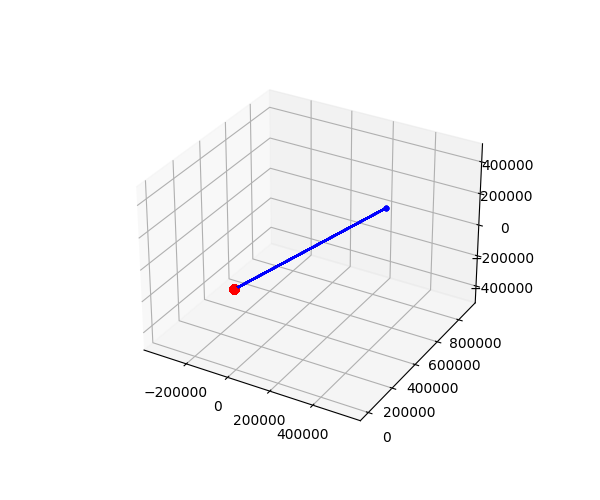

In [11]:
plt.figure(figsize=(6,5))
ax = plt.axes(projection='3d')
ax.scatter3D(views_pos[:,0], views_pos[:,1], views_pos[:,2], c='r', s=10)
if points_gt is not None:
    ax.scatter3D(points_gt[:, 0], points_gt[:, 1], points_gt[:, 2], c='r', s=10)
points_vis = points_lidar
for i in range(points_vis.shape[0]):
    P_w = points_vis[i, :]
    ax.scatter3D(P_w[0], P_w[1], P_w[2], c='b', s=10)
    for k in range(n_views):
        plot_fustrum(ax, views_pos[k], views_rot[k], f=-1.0, scale=10)
    for backprojection in backprojections[i]:
        cam_idx = backprojection[0]
        ax.plot3D([P_w[0], views_pos[cam_idx,0]], 
                     [P_w[1], views_pos[cam_idx,1]], 
                     [P_w[2], views_pos[cam_idx, 2]], 'b-')
set_3d_axes_equal(ax)

## Solution #1

In [12]:
points_hat = []
for k, backprojection_data in enumerate(backprojections):
    print('Triangulate #', k)
    result, P_hat = triangulate(np.array(backprojection_data), pixel2camera, views_rot, views_pos)
    points_hat.append(P_hat)
    
    if points_gt is not None:
        print('Check triangulation (~=0): ', np.linalg.norm(P_hat - points_gt[k]))   
        
points_hat = np.array(points_hat)

print('Points to lidar: ')   
print(points_hat - points_lidar)

points_hat += bundle_mean_offset
#points_hat = np.array([[207554.24,894199.34,58.27],[207526.96,894197.65,55.550000000000004],[207517.34,894196.67,58.58],[207528.51,894214.21,54.61]])

Triangulate # 0
Triangulate # 1
Triangulate # 2
Triangulate # 3
Points to lidar: 
[[-2.07514962e+05 -8.94194759e+05 -1.19277127e+02]
 [-2.07514922e+05 -8.94197063e+05 -1.18976714e+02]
 [-2.07519027e+05 -8.94193770e+05 -1.19358219e+02]
 [-2.07514870e+05 -8.94188390e+05 -1.19979724e+02]]


Input lidar & point cloud coordinates

In [13]:
np.set_printoptions(precision=2, suppress = True)

print('Lidar points')
print(points_lidar)

print('Lidar points in bundle system')
#print(points_lidar + bundle_mean_offset)
print(points_lidar)

print('Triangulated points')
#print(points_hat + bundle_mean_offset)
print(points_hat)

print('Are these points the same (should not be ~=0): ', np.linalg.norm(points_lidar-points_hat))

Lidar points
[[207515.38 894195.39     56.44]
 [207505.78 894196.67     59.1 ]
 [207520.93 894210.84     55.64]
 [207542.34 894190.75     59.89]]
Lidar points in bundle system
[[207515.38 894195.39     56.44]
 [207505.78 894196.67     59.1 ]
 [207520.93 894210.84     55.64]
 [207542.34 894190.75     59.89]]
Triangulated points
[[207527.02 894198.15     55.48]
 [207517.46 894197.13     58.45]
 [207528.51 894214.59     54.6 ]
 [207554.07 894199.88     58.23]]
Are these points the same (should not be ~=0):  24.032498091443042


In [42]:
def find_rigid_transformation(pts_model, pts_target):
    #pts_target = [[207554.24,894199.34,58.27],[207528.51,894214.21,54.61],[207526.96,894197.65,55.550000000000004],[207517.34,894196.67,58.58]]
    
    cog_model = np.mean(pts_model, axis=0)
    cog_target = np.mean(pts_target, axis=0)

    pts_model_cog = pts_model - cog_model
    pts_target_cog = pts_target - cog_target

    s1 = 0
    s2 = 0
    for k in range(pts_model_cog.shape[0]):
        s1 += pts_model_cog[k].dot(pts_model_cog[k]) 
        s2 += pts_target_cog[k].dot(pts_target_cog[k]) 
    scale = np.sqrt(s2/s1)
    pts_model_cog = scale * pts_model_cog

    C = pts_model_cog.T @ pts_target_cog
    [U, S, V] = np.linalg.svd(C)
    V = V.T
    
    R_hat = V @ U.T
    t_hat = cog_target - scale * R_hat @ cog_model
    print(R_hat)
    return True, R_hat, t_hat, scale, {'C': C, 'U': U, 'V': V}

result, R_hat, t_hat, s_hat, _ = find_rigid_transformation(points_lidar, points_hat) 
points_lidar_hat = (s_hat * R_hat @ points_lidar.T).T + t_hat

res_svd = np.linalg.norm(points_lidar_hat - points_hat, axis=1)
print('Check transformation (if synthetic data then ~=0)', np.linalg.norm(res_svd))

def compute_rmse(points_lidar_hat, points_hat):
    dr = np.linalg.norm(points_lidar_hat - points_hat, axis=1)
    return np.sqrt(np.sum(np.power(dr, 2)) / dr.shape[0])

print('Point set to point set distance:')
print('  before:', np.linalg.norm(points_lidar - points_hat))
print('  after: ', np.linalg.norm(points_lidar_hat - points_hat))
print('RMSE: ', compute_rmse(points_lidar_hat, points_hat))
print(' ')
print('R_hat: ', Rotation.from_matrix(R_hat).as_euler('ZYX', degrees=True))
print('t_hat: ', t_hat)
print('scale: ', s_hat)

[[ 0.9717 -0.2348  0.0266]
 [ 0.2348  0.972   0.0015]
 [-0.0262  0.0048  0.9996]]
Check transformation (if synthetic data then ~=0) 0.3013993626111877
Point set to point set distance:
  before: 24.032498091443042
  after:  0.3013993626111877
RMSE:  0.15069968130559386
 
R_hat:  [13.587   1.5025  0.2764]
t_hat:  [215801.5765 -19374.0793   1122.8923]
scale:  0.995263109595246


In [35]:
R_hat

array([[ 0.9713, -0.2362,  0.0267],
       [ 0.2363,  0.9717,  0.0015],
       [-0.0263,  0.0048,  0.9996]])

In [15]:
def get_T(R, t, s):
    T = np.vstack((np.hstack((s*R, np.array([t]).T)), [[0, 0, 0, 1]]))
    for i in range(4):
        row = ''
        for j in range(4):
            row += '{:.8f} '.format(T[i, j])
        print(row)
    return T

T_hat = get_T(R_hat, t_hat, s_hat)

0.96672968 -0.23510421 0.02661586 217143.22165625 
0.23514842 0.96708405 0.00152438 -19360.92708080 
-0.02622237 0.00480778 0.99490599 1141.80034065 
0.00000000 0.00000000 0.00000000 1.00000000 


In [16]:
#for gcp_idx, gcp in enumerate(gcps):
#    print(gcp_idx, gcp['XYZ'])

errors = points_lidar_hat - points_hat
for k in range(errors.shape[0]):
    num2str = lambda x: str(round(x, 3))
    print('dx= ' + num2str(errors[k, 0]) + ' dy= ' + num2str(errors[k, 1]) + ' dz= ' + num2str(errors[k, 2]))

dx= -0.117 dy= 0.015 dz= 0.022
dx= -0.068 dy= 0.022 dz= -0.034
dx= 0.109 dy= -0.18 dz= 0.036
dx= 0.076 dy= 0.143 dz= -0.023


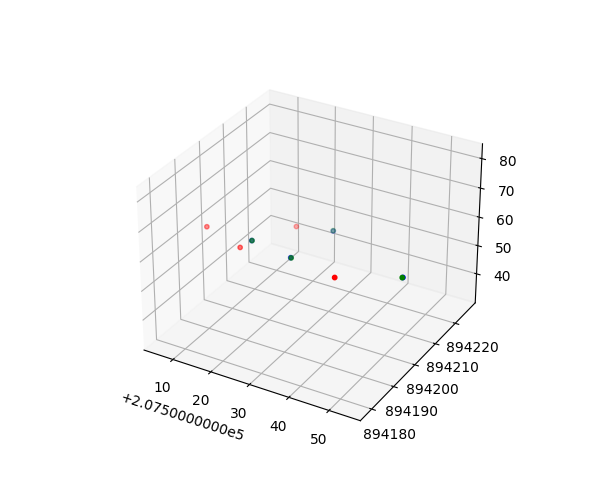

In [17]:
plt.figure(figsize=(6,5))
ax = plt.axes(projection='3d')
if points_gt is not None:
    ax.scatter3D(points_gt[:, 0], points_gt[:, 1], points_gt[:, 2], c='g', s=10)
ax.scatter3D(points_hat[:, 0], points_hat[:, 1], points_hat[:, 2], c='g', s=10)
ax.scatter3D(points_lidar[:, 0], points_lidar[:, 1], points_lidar[:, 2], c='r', s=10)
ax.scatter3D(points_lidar_hat[:, 0], points_lidar_hat[:, 1], points_lidar_hat[:, 2], c='b', s=10)
set_3d_axes_equal(ax)

# Solution #2

$$
\min_{R,\mathbf{t}} \sum_i \frac{ \lVert d_i \times (C_i - (RP_i + t)) \lVert }{ \lVert d_i \lVert}
$$
where $C_i$ is the camera center, $d_i$ is the direction vector of ray corresponging to the $i$th image point and $P_i$ is the lidar point.

In [18]:
from scipy.optimize import least_squares

In [19]:
def get_Rt(x):
    R = Rotation.from_euler('ZYX', x[0:3], degrees=False).as_matrix()
    t = x[3:6]
    s = x[6]
    return R, t, s

def skew(x): return np.array([[0, -x[2], x[1]],
                                 [x[2], 0, -x[0]],
                                 [-x[1], x[0], 0]])

def cost_fn(x):
    R, t, s = get_Rt(x)
    
    residuals = []
    for gcp_idx, backprojection_data in enumerate(backprojections):
        if lcs_shift is not None:
            P = (np.array(gcps[gcp_idx]['XYZ']) - lcs_shift).T
        else:
            P = (np.array(gcps[gcp_idx]['XYZ']) - bundle_mean_offset).T
        for k, backprojection_data in enumerate(backprojection_data):
            cam_idx = int(backprojection_data[0])
            R_view = views_rot[cam_idx]
            C_view = views_pos[cam_idx]
            img_pt = np.array(backprojection_data)[1:3]

            result, p_c = pixel2camera(img_pt)
            x_i = f*p_c[0];
            y_i = f*p_c[1];
            z_i = -f

            d_c = np.array([x_i, y_i, z_i]).T
            d_w = R_view.T @ d_c
            d_w = d_w / np.linalg.norm(d_w)

            #ray_to_point = np.cross(d_w, C_view - (R @ P + t))
            ray_to_point = skew(d_w) @ (C_view - (s * R @ P + t)) # let's use only ordanary matrix operations
            residuals.append(ray_to_point.T)
            
    return np.array(residuals).flatten()
    

In [20]:
ypr = Rotation.from_matrix(R_hat).as_euler('ZYX', degrees=False)
x_hat = [ypr[0], ypr[1], ypr[2], t_hat[0], t_hat[1], t_hat[2], s_hat]

R_test, t_test, s_test = get_Rt(x_hat)
print('~=0: ', np.linalg.norm(R_test - R_hat))
print('~=0: ', np.linalg.norm(t_test - t_hat))
print('~=0: ', np.linalg.norm(s_test - s_hat))

~=0:  2.8436512783209556e-16
~=0:  0.0
~=0:  0.0


In [21]:
#x0 = [0, 0, 0, 0, 0, 0, 1.0]
x0 = x_hat
residuals_0 = cost_fn(x0)
res = least_squares(cost_fn, x0, verbose=1)

`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 8.9361e+11, final cost 3.0756e-01, first-order optimality 1.74e-05.


In [22]:
print('Solution #1')
print('   R_hat: ', Rotation.from_matrix(R_hat).as_euler('ZYX', degrees=True))
print('   t_hat: ', t_hat)
print('   s_hat: ', s_hat)

print('Solution #2')
R_hat_2, t_hat_2, s_hat_2 = get_Rt(res.x)
print('   R_hat: ', Rotation.from_matrix(R_hat_2).as_euler('ZYX', degrees=True))
print('   t_hat: ', t_hat_2)
print('   s_hat: ', s_hat_2)

Solution #1
   R_hat:  [13.67  1.51  0.28]
   t_hat:  [217143.22 -19360.93   1141.8 ]
   s_hat:  0.995263109595246
Solution #2
   R_hat:  [13.66  1.57  0.57]
   t_hat:  [12.42  5.14 -1.59]
   s_hat:  0.9939171517949047


In [23]:
_ = get_T(R_hat_2, t_hat_2, s_hat_2)

0.96544104 -0.23444953 0.02878058 12.42461379 
0.23463645 0.96581927 -0.00318920 5.14335934 
-0.02721468 0.00989214 0.99349525 -1.58593992 
0.00000000 0.00000000 0.00000000 1.00000000 


# Comparison

Statistics at initial guess:

In [24]:
print('Aprior statistics: ')
print('Average distance error', np.mean(residuals_0))
print('Average abs. distance error', np.mean(np.abs(residuals_0)))

def compare_to_triangulation(R, t, s):
    points_lidar_hat = (s * R @ points_lidar.T).T + t
    np.set_printoptions(precision=4, suppress = True)
    print(points_lidar_hat - points_hat)
    print('Norm of the differences: ', np.linalg.norm(points_lidar_hat - points_hat))
    print('Max difference: ', np.max(np.linalg.norm(points_lidar_hat - points_hat, axis=1)))
    print('Avg. difference: ', np.mean(np.linalg.norm(points_lidar_hat - points_hat, axis=1)))

R0, t0, s0 = get_Rt(x0)
compare_to_triangulation(R0, t0, s0)

Aprior statistics: 
Average distance error 70960.4916832188
Average abs. distance error 90191.64685105823
[[-0.1171  0.0146  0.0216]
 [-0.0683  0.0225 -0.0345]
 [ 0.1092 -0.1797  0.0355]
 [ 0.0763  0.1426 -0.0226]]
Norm of the differences:  0.3047713966750558
Max difference:  0.21320569064912337
Avg. difference:  0.1440661152515853


Let's check the average point-ray distance after adjustment and compare the transformation to the triangulated points:

In [25]:
residuals = cost_fn(res.x)
print('Average distance error', np.mean(residuals))
print('Average abs. distance error', np.mean(np.abs(residuals)))
print(' ')
print('Comparison to the triangulated points:')
compare_to_triangulation(R_hat_2, t_hat_2, s_hat_2)

Average distance error 0.0028153061090680194
Average abs. distance error 0.04927115186184368
 
Comparison to the triangulated points:
[[-216812.792    18128.623     3197.0395]
 [-216812.7242   18128.6217    3196.9957]
 [-216812.5645   18128.4102    3197.1275]
 [-216812.6289   18128.7268    3196.94  ]]
Norm of the differences:  435185.4961725353
Max difference:  217592.8647861374
Avg. difference:  217592.7480862484


Let's look at these error metrics in case of the triangulation + SVD approach

In [26]:
residuals = cost_fn(x_hat)
print('Average distance error', np.mean(residuals))
print('Average abs. distance error', np.mean(np.abs(residuals)))
print(' ')
print('Comparison to the triangulated points:')
compare_to_triangulation(R_hat, t_hat, s_hat)

Average distance error 70960.4916832188
Average abs. distance error 90191.64685105823
 
Comparison to the triangulated points:
[[-0.1171  0.0146  0.0216]
 [-0.0683  0.0225 -0.0345]
 [ 0.1092 -0.1797  0.0355]
 [ 0.0763  0.1426 -0.0226]]
Norm of the differences:  0.3047713966676845
Max difference:  0.2132056905871662
Avg. difference:  0.1440661152449761


## Solution #2.1

In [27]:
from collections import defaultdict
import math

class AutoDiffVariable(object):
    
    def __init__(self, value, local_gradients=[]):
        self.value = float(value)
        self.local_gradients = local_gradients

    def __float__(self):
         return self.value
    
    def __add__(self, other):
        if not isinstance(other, AutoDiffVariable):
            return self.__add__(AutoDiffVariable(float(other)))        
        value = self.value + other.value    
        local_gradients = ((self, 1.0), (other, 1.0))
        return AutoDiffVariable(value, local_gradients)
    
    def __mul__(self, other):
        if not isinstance(other, AutoDiffVariable):
            return self.__mul__(AutoDiffVariable(float(other)))
        value = self.value * other.value
        local_gradients = ((self, other.value), (other, self.value))
        return AutoDiffVariable(value, local_gradients)

    def __neg__(self):
        value = -1.0 * self.value
        local_gradients = ((self, -1.0),)
        return AutoDiffVariable(value, local_gradients)
    
    def __sub__(self, other):
        if not isinstance(other, AutoDiffVariable):
            return self.__sub__(AutoDiffVariable(float(other)))        
        return self.__add__(other.__neg__())
    
    def __repr__(self):
        return str(self.value) + 'v' # + ' [' + str(self.local_gradients) + ']'

    def __inv__(self):
        value = 1. / self.value
        local_gradients = (
            (self, -1 / self.value**2),
        )
        return AutoDiffVariable(value, local_gradients)

    def __truediv__(self, other):
        if not isinstance(other, AutoDiffVariable):
            return self.__truediv__(AutoDiffVariable(float(other)))         
        return self.__mul__(other.__inv__()) 
    
    def __pow__(self, other):
        if not isinstance(other, AutoDiffVariable):
            return self.__pow__(AutoDiffVariable(float(other)))                
        value = self.value ** other.value
        local_gradients = ((self,  other.value*self.value**(other.value-1) ), 
                           (other, self.value**other.value*math.log(other.value)))
        return AutoDiffVariable(value, local_gradients)    
    
    __radd__  = __add__
    __rmul__ = __mul__
    __rsub__ = __sub__

class AutoDiffFunctions(object):
    
    @staticmethod
    def sin(a):
        value = np.sin(a.value)
        local_gradients = (
            (a, np.cos(a.value)),
        )
        return AutoDiffVariable(value, local_gradients)
    
    @staticmethod
    def cos(a):
        value = np.cos(a.value)
        local_gradients = (
            (a, -np.sin(a.value)),
        )
        return AutoDiffVariable(value, local_gradients)

    @staticmethod
    def skew(x): 
        var = AutoDiffVariable
        return np.array([[var(0), -x[2], x[1]],
                         [x[2], var(0), -x[0]],
                         [-x[1], x[0], var(0)]])
    @staticmethod
    def matexp(w):
        sin = AutoDiffFunctions.sin
        cos = AutoDiffFunctions.cos
        var = AutoDiffVariable
        if np.sum(np.abs(w.astype('float'))) < 1e-10:
            omega = var(1)
        else:
            omega = (w[0]**2 + w[1]**2 + w[2]**2)**(1/2)
        S = skew(w)
        R = np.eye(3) + S*(sin(omega)/omega) + S@S*((var(1)-cos(omega))/omega**2)
        return R


vf = AutoDiffFunctions
_var = AutoDiffVariable
np2var = lambda vec: np.array([AutoDiffVariable(x) for x in vec])

In [28]:
def get_gradients(variable):
    
    gradients = defaultdict(lambda: 0)
    
    def compute_gradients(variable, path_value):
        for child_variable, local_gradient in variable.local_gradients:
            # "Multiply the edges of a path":
            value_of_path_to_child = path_value * local_gradient
            # "Add together the different paths":
            gradients[child_variable] += value_of_path_to_child
            # recurse through graph:
            compute_gradients(child_variable, value_of_path_to_child)
    
    compute_gradients(variable, path_value=1)
    # (path_value=1 is from `variable` differentiated w.r.t. itself)
    return gradients

def compute_jacobian(r, x):
    m = r.shape[0]
    n = len(x)
    J = np.zeros((m, n))
    for iter_r in range(m):
        grad_iter = get_gradients(r[iter_r])
        for iter_x in range(n):
            J[iter_r, iter_x] = grad_iter[x[iter_x]]
    return J

In [29]:
test_a = _var(3)
test_b = _var(4)
test_c = (test_a**2 + test_b**2)**(_var(1)/_var(2))
print('Test value ( =5): ', test_c.value)
print('Local gradient ( not =[]): ', test_c.local_gradients)

Test value ( =5):  5.0
Local gradient ( not =[]):  ((25.0v, 0.1), (0.5v, -3.4657359027997265))


In [30]:
def Exp_(w):
    omega = (w[0]**2 + w[1]**2 + w[2]**2)**(1/2)
    if omega < 1e-10:
        return np.eye(3)
    S = np.array([[0, -w[2], w[1]], [w[2], 0, -w[0]], [-w[1], w[0], 0]])
    return np.eye(3) + S*(math.sin(omega)/omega) + S@S*((1-math.cos(omega))/omega**2)

rvec_gt = Rotation.from_matrix(R_hat).as_rotvec(degrees=False)
print('Check exponential map: ', np.linalg.norm(Exp_(rvec_gt) - R_hat))

Check exponential map:  2.8401428672742954e-16


In [31]:
def Log_(R):
    omega = np.arccos((np.trace(R)-1)/2)           # input rotation matrix
    S = (omega/(2*np.sin(omega))) * (R-R.T)        # rotation matrix SO(3) -> skew so(3)
    return [S[2, 1], S[0, 2], S[1, 0]]             # so(3) -> R^3, using the def. of skew matrix

In [32]:
method = 1 # 1 - rotation vector optimization, 2 - optimization on manifold
x0 = [0, 0, 0, 0, 0, 0, 1.0]

#w = Log_(R_hat)
#x0 = np.hstack((w, t_hat))

R = Exp_(x0[:3])
t = x0[3:6]
s = x0[6]

dx = np.inf
iter_num = 0

while np.linalg.norm(dx) > 1e-8 and iter_num < 20:
    iter_num += 1
    
    J = []
    dr = []
    for gcp_idx, backprojection_data in enumerate(backprojections):
        P = (np.array(gcps[gcp_idx]['XYZ']) - bundle_mean_offset).T
        for k, backprojection_data in enumerate(backprojection_data):
            cam_idx = int(backprojection_data[0])
            R_view = views_rot[cam_idx]
            C_view = views_pos[cam_idx]
            img_pt = np.array(backprojection_data)[1:3]

            result, p_c = pixel2camera(img_pt)
            d_c = np.array([f*p_c[0], f*p_c[1], -f]).T
            d_w = R_view.T @ d_c
            d_w = d_w / np.linalg.norm(d_w)

            d_w_var = np2var(d_w)           

            if method == 1:
                x = np2var(x0)
                res_entry = vf.skew(d_w_var) @ (C_view - (np.array([x[6]]) * vf.matexp(x[:3]) @ P + x[3:6]))
            else:
                x = np2var([0, 0, 0, 0, 0, 0, 0.0])
                q = vf.matexp(x[:3]) @ P
                dq = skew(-P)
                res_entry = vf.skew(d_w_var) @ (C_view - (np.array([s + x[6]]) * R @ q + (t + x[3:6])))

            jac_entry = compute_jacobian(res_entry, x)

            # Directly optimizing norm has longer convergence
            #res_entry = (res_entry[0]**2 + res_entry[1]**2 + res_entry[2]**2)**0.5
            #dr.append(float(res_entry))
            #jac_entry = compute_jacobian(np.array([res_entry]), x)
            
            dr.append(res_entry.astype('float'))
            J.append(jac_entry)

    dr = np.array(dr).flatten()
    J = np.array(J).reshape(-1, 7) 

    dx = np.linalg.solve(-J.T @ J, J.T @ dr)
    #dx = -np.linalg.inv(J.T @ J) @ J.T @ dr
    if method == 1:
        x0 = x0 + dx
        
    #print(dx)

    if method == 1:
        R = Exp_(x0[:3])
        t = x0[3:6]
        s = x0[6]
    else:
        R = R @ Exp_(dx[:3])
        t = t + dx[3:6]
        s = s + dx[6]
    
    print('Iteration #{:d} \t R: {:.6f} \t t: {:.4f} \t dx: {:.8f}\t dr: {:.8f}'.format(
         iter_num, np.linalg.norm(R - R_hat_2), np.linalg.norm(t - t_hat_2), 
         np.linalg.norm(dx), np.linalg.norm(dr)))


Iteration #1 	 R: 0.057657 	 t: 1.6920 	 dx: 13.73774889	 dr: 72.44471955
Iteration #2 	 R: 0.001690 	 t: 0.0487 	 dx: 1.64412709	 dr: 5.44681567
Iteration #3 	 R: 0.000008 	 t: 0.0003 	 dx: 0.04869632	 dr: 0.80286336
Iteration #4 	 R: 0.000000 	 t: 0.0000 	 dx: 0.00032498	 dr: 0.78429377
Iteration #5 	 R: 0.000000 	 t: 0.0000 	 dx: 0.00001794	 dr: 0.78429375
Iteration #6 	 R: 0.000000 	 t: 0.0000 	 dx: 0.00000094	 dr: 0.78429375
Iteration #7 	 R: 0.000000 	 t: 0.0000 	 dx: 0.00000005	 dr: 0.78429375
Iteration #8 	 R: 0.000000 	 t: 0.0000 	 dx: 0.00000000	 dr: 0.78429375


In [33]:
ypr = Rotation.from_matrix(R).as_euler('ZYX', degrees=False)
x_hat = [ypr[0], ypr[1], ypr[2], t[0], t[1], t[2], s]

residuals = cost_fn(x_hat)
print('Average distance error', np.mean(residuals))
print('Average abs. distance error', np.mean(np.abs(residuals)))
print(' ')
print('Comparison to the triangulated points:')
compare_to_triangulation(R, t, s)

Average distance error 0.002815304288392066
Average abs. distance error 0.04927113491409185
 
Comparison to the triangulated points:
[[-216812.7935   18128.6209    3197.08  ]
 [-216812.7257   18128.6195    3197.0362]
 [-216812.5659   18128.408     3197.1681]
 [-216812.6303   18128.7247    3196.9806]]
Norm of the differences:  435185.4999420762
Max difference:  217592.8666709054
Avg. difference:  217592.7499710189
